### Loading libs

In [1]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

### Reading data

In [2]:
class ETTData(Dataset):
  def __init__(self, data, flag='train', pred=0):
    # init
    self.data = data
    self.flag = flag
    if flag!='train':
        self.pred = pred
  
  def __getitem__(self, index):
        if self.flag=='train':
            return self.data[index, :]
        else:
            out = np.empty(self.data[index, :].shape[0])
            out[:-pred] = self.data[index, :-pred]
            out[-pred:] = np.mean(self.data[index, :-pred])
            return out
  
  def __len__(self):
    return self.data.shape[0]

In [3]:
# load
data_train = pd.read_csv('./ETDataset/ETT-small/ETTh1_train.csv', index_col=0).to_numpy(dtype="float32")
data_test = pd.read_csv('./ETDataset/ETT-small/ETTh1_test.csv', index_col=0).to_numpy(dtype="float32")
cov = pd.read_csv('./ETDataset/ETT-small/ETTh1_corr.csv', index_col=0).to_numpy(dtype="float32")

# scale
scaler = StandardScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

# create data loader for training data
data_train = ETTData(data_train)
data_train_loader = DataLoader(data_train, batch_size=10, shuffle=True)

### Define model

In [4]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        x = self.g(z)
        return x

In [5]:
nets = lambda: nn.Sequential(nn.Linear(268, 512), nn.LeakyReLU(), nn.Linear(512, 512), nn.LeakyReLU(), nn.Linear(512, 268), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(268, 512), nn.LeakyReLU(), nn.Linear(512, 512), nn.LeakyReLU(), nn.Linear(512, 268))
masks = torch.from_numpy(np.array([[0]*134 + [1]*134, [1]*134 + [0]*134] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(268), torch.tensor(cov))
flow = RealNVP(nets, nett, masks, prior)

In [6]:
EPOCHS = 4000
TRAIN_STEPS = len(data_train_loader)
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)

for epoch in range(EPOCHS):
    iter_count = 0
    train_loss = []

    epoch_time = time.time()
    curr_time = time.time()

    for i, sample in enumerate(data_train_loader):
        iter_count += 1
        loss = -flow.log_prob(sample).mean()
        train_loss.append(loss.item())

        print('\titers: {0}, epoch: {1} | loss: {2:.7f}'.format(i, epoch + 1, loss.item()))
        speed = (time.time() - curr_time) / iter_count
        left_time = speed * ((EPOCHS - epoch) * TRAIN_STEPS - i)
        print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            for param in flow.parameters():
                param.clamp_(1e-14, 1e14)

    # compute average train loss
    train_loss = np.average(train_loss)
    
    print("epoch: {}, epoch time: {}, loss: {}".format(epoch+1, time.time() - curr_time, train_loss))

	iters: 0, epoch: 1 | loss: 5037.2714844
	speed: 0.0129s/iter; left time: 308.4755s
	iters: 1, epoch: 1 | loss: 761738.8125000
	speed: 0.0420s/iter; left time: 1009.0522s
	iters: 2, epoch: 1 | loss: 1446878.8750000
	speed: 0.0424s/iter; left time: 1017.9720s
	iters: 3, epoch: 1 | loss: 28458636.0000000
	speed: 0.0426s/iter; left time: 1023.1670s
	iters: 4, epoch: 1 | loss: 2059443.3750000
	speed: 0.0427s/iter; left time: 1023.5263s
	iters: 5, epoch: 1 | loss: 33442890.0000000
	speed: 0.0430s/iter; left time: 1032.6818s
epoch: 1, epoch time: 0.2930312156677246, loss: 11029104.055664062
	iters: 0, epoch: 2 | loss: 14318614.0000000
	speed: 0.0078s/iter; left time: 186.5035s
	iters: 1, epoch: 2 | loss: 1080600.2500000
	speed: 0.0251s/iter; left time: 602.7990s
	iters: 2, epoch: 2 | loss: 32917628.0000000
	speed: 0.0307s/iter; left time: 735.8253s
	iters: 3, epoch: 2 | loss: 1369363.3750000
	speed: 0.0335s/iter; left time: 802.8452s
	iters: 4, epoch: 2 | loss: 473744.0000000
	speed: 0.0355s

	iters: 1, epoch: 15 | loss: 1359583.0000000
	speed: 0.0255s/iter; left time: 610.1047s
	iters: 2, epoch: 15 | loss: 300093.5937500
	speed: 0.0315s/iter; left time: 752.9627s
	iters: 3, epoch: 15 | loss: 1068578.7500000
	speed: 0.0340s/iter; left time: 814.2188s
	iters: 4, epoch: 15 | loss: 34707.6445312
	speed: 0.0358s/iter; left time: 855.1974s
	iters: 5, epoch: 15 | loss: 2611502.2500000
	speed: 0.0368s/iter; left time: 879.0713s
epoch: 15, epoch time: 0.2564878463745117, loss: 1239099.3313802083
	iters: 0, epoch: 16 | loss: 1474641.2500000
	speed: 0.0079s/iter; left time: 187.8173s
	iters: 1, epoch: 16 | loss: 3468352.7500000
	speed: 0.0260s/iter; left time: 621.2042s
	iters: 2, epoch: 16 | loss: 1031376.6875000
	speed: 0.0322s/iter; left time: 770.2523s
	iters: 3, epoch: 16 | loss: 276505.5625000
	speed: 0.0353s/iter; left time: 843.2834s
	iters: 4, epoch: 16 | loss: 299910.3125000
	speed: 0.0372s/iter; left time: 890.2738s
	iters: 5, epoch: 16 | loss: 510172.3125000
	speed: 0.038

	iters: 2, epoch: 29 | loss: 407664.0937500
	speed: 0.0325s/iter; left time: 775.0154s
	iters: 3, epoch: 29 | loss: 580572.0625000
	speed: 0.0348s/iter; left time: 828.3798s
	iters: 4, epoch: 29 | loss: 769109.3125000
	speed: 0.0366s/iter; left time: 872.4052s
	iters: 5, epoch: 29 | loss: 1307758.7500000
	speed: 0.0376s/iter; left time: 896.7454s
epoch: 29, epoch time: 0.26416516304016113, loss: 616466.158203125
	iters: 0, epoch: 30 | loss: 35166.3632812
	speed: 0.0083s/iter; left time: 196.7803s
	iters: 1, epoch: 30 | loss: 522811.1875000
	speed: 0.0264s/iter; left time: 629.5416s
	iters: 2, epoch: 30 | loss: 1200288.5000000
	speed: 0.0319s/iter; left time: 759.5579s
	iters: 3, epoch: 30 | loss: 172943.2812500
	speed: 0.0343s/iter; left time: 818.1548s
	iters: 4, epoch: 30 | loss: 1070011.0000000
	speed: 0.0360s/iter; left time: 857.9547s
	iters: 5, epoch: 30 | loss: 571715.0000000
	speed: 0.0369s/iter; left time: 879.5118s
epoch: 30, epoch time: 0.2573721408843994, loss: 595489.22200

	iters: 2, epoch: 43 | loss: 391391.0000000
	speed: 0.0356s/iter; left time: 845.5394s
	iters: 3, epoch: 43 | loss: 931968.3125000
	speed: 0.0386s/iter; left time: 916.7884s
	iters: 4, epoch: 43 | loss: 386961.5625000
	speed: 0.0399s/iter; left time: 948.1083s
	iters: 5, epoch: 43 | loss: 403829.1250000
	speed: 0.0404s/iter; left time: 959.1065s
epoch: 43, epoch time: 0.2793619632720947, loss: 383241.8811848958
	iters: 0, epoch: 44 | loss: 707992.6250000
	speed: 0.0075s/iter; left time: 177.1351s
	iters: 1, epoch: 44 | loss: 126291.8281250
	speed: 0.0259s/iter; left time: 614.4505s
	iters: 2, epoch: 44 | loss: 379026.7187500
	speed: 0.0312s/iter; left time: 741.7863s
	iters: 3, epoch: 44 | loss: 296826.5625000
	speed: 0.0340s/iter; left time: 807.8967s
	iters: 4, epoch: 44 | loss: 248262.7500000
	speed: 0.0357s/iter; left time: 847.2754s
	iters: 5, epoch: 44 | loss: 481543.4062500
	speed: 0.0369s/iter; left time: 874.9682s
epoch: 44, epoch time: 0.25664377212524414, loss: 373323.981770

	iters: 3, epoch: 57 | loss: 119460.4140625
	speed: 0.0343s/iter; left time: 811.5899s
	iters: 4, epoch: 57 | loss: 88050.7656250
	speed: 0.0482s/iter; left time: 1140.0518s
	iters: 5, epoch: 57 | loss: 253029.0312500
	speed: 0.0477s/iter; left time: 1127.5323s
epoch: 57, epoch time: 0.33284878730773926, loss: 260997.73665364584
	iters: 0, epoch: 58 | loss: 427811.3437500
	speed: 0.0082s/iter; left time: 194.4508s
	iters: 1, epoch: 58 | loss: 227414.3281250
	speed: 0.0271s/iter; left time: 642.0402s
	iters: 2, epoch: 58 | loss: 12107.1933594
	speed: 0.0325s/iter; left time: 768.1965s
	iters: 3, epoch: 58 | loss: 83978.5859375
	speed: 0.0350s/iter; left time: 828.5164s
	iters: 4, epoch: 58 | loss: 13490.6640625
	speed: 0.0367s/iter; left time: 867.8088s
	iters: 5, epoch: 58 | loss: 757874.1875000
	speed: 0.0381s/iter; left time: 901.0177s
epoch: 58, epoch time: 0.26785922050476074, loss: 253779.3837890625
	iters: 0, epoch: 59 | loss: 287252.1250000
	speed: 0.0075s/iter; left time: 177.4

	iters: 4, epoch: 71 | loss: 188360.0468750
	speed: 0.0371s/iter; left time: 873.7552s
	iters: 5, epoch: 71 | loss: 126311.1484375
	speed: 0.0381s/iter; left time: 898.0240s
epoch: 71, epoch time: 0.2637612819671631, loss: 186346.4308268229
	iters: 0, epoch: 72 | loss: 232076.1718750
	speed: 0.0075s/iter; left time: 176.0503s
	iters: 1, epoch: 72 | loss: 309847.7187500
	speed: 0.0247s/iter; left time: 582.7375s
	iters: 2, epoch: 72 | loss: 22028.3007812
	speed: 0.0307s/iter; left time: 723.0564s
	iters: 3, epoch: 72 | loss: 196129.5468750
	speed: 0.0344s/iter; left time: 811.5558s
	iters: 4, epoch: 72 | loss: 25818.5312500
	speed: 0.0364s/iter; left time: 858.0005s
	iters: 5, epoch: 72 | loss: 301971.3437500
	speed: 0.0378s/iter; left time: 890.8809s
epoch: 72, epoch time: 0.26359128952026367, loss: 181311.935546875
	iters: 0, epoch: 73 | loss: 21696.8320312
	speed: 0.0076s/iter; left time: 180.2928s
	iters: 1, epoch: 73 | loss: 175985.0937500
	speed: 0.0260s/iter; left time: 611.6581s

	iters: 5, epoch: 85 | loss: 8169.0053711
	speed: 0.0368s/iter; left time: 865.1593s
epoch: 85, epoch time: 0.25671815872192383, loss: 133007.31990559897
	iters: 0, epoch: 86 | loss: 318126.0937500
	speed: 0.0076s/iter; left time: 178.5536s
	iters: 1, epoch: 86 | loss: 89584.0000000
	speed: 0.0250s/iter; left time: 586.1324s
	iters: 2, epoch: 86 | loss: 157166.8906250
	speed: 0.0309s/iter; left time: 724.8254s
	iters: 3, epoch: 86 | loss: 15127.5126953
	speed: 0.0340s/iter; left time: 798.1361s
	iters: 4, epoch: 86 | loss: 35916.6171875
	speed: 0.0359s/iter; left time: 842.8668s
	iters: 5, epoch: 86 | loss: 163093.4062500
	speed: 0.0371s/iter; left time: 870.5347s
epoch: 86, epoch time: 0.25819921493530273, loss: 129835.75341796875
	iters: 0, epoch: 87 | loss: 275395.7500000
	speed: 0.0075s/iter; left time: 176.1788s
	iters: 1, epoch: 87 | loss: 23007.8886719
	speed: 0.0249s/iter; left time: 585.0925s
	iters: 2, epoch: 87 | loss: 51193.4257812
	speed: 0.0310s/iter; left time: 727.5589s

epoch: 99, epoch time: 0.25398874282836914, loss: 96231.7578125
	iters: 0, epoch: 100 | loss: 207973.5000000
	speed: 0.0076s/iter; left time: 176.8772s
	iters: 1, epoch: 100 | loss: 30168.9121094
	speed: 0.0247s/iter; left time: 578.3724s
	iters: 2, epoch: 100 | loss: 133691.0625000
	speed: 0.0307s/iter; left time: 717.3805s
	iters: 3, epoch: 100 | loss: 15656.1611328
	speed: 0.0336s/iter; left time: 785.7864s
	iters: 4, epoch: 100 | loss: 153366.0937500
	speed: 0.0353s/iter; left time: 825.3601s
	iters: 5, epoch: 100 | loss: 23718.3710938
	speed: 0.0367s/iter; left time: 858.4850s
epoch: 100, epoch time: 0.2549138069152832, loss: 94095.68343098958
	iters: 0, epoch: 101 | loss: 18650.6679688
	speed: 0.0074s/iter; left time: 174.0256s
	iters: 1, epoch: 101 | loss: 68987.0000000
	speed: 0.0247s/iter; left time: 577.6858s
	iters: 2, epoch: 101 | loss: 28956.1601562
	speed: 0.0303s/iter; left time: 709.6767s
	iters: 3, epoch: 101 | loss: 233010.2031250
	speed: 0.0332s/iter; left time: 776.

	iters: 1, epoch: 114 | loss: 38962.0156250
	speed: 0.0253s/iter; left time: 589.5660s
	iters: 2, epoch: 114 | loss: 122032.2343750
	speed: 0.0311s/iter; left time: 724.6838s
	iters: 3, epoch: 114 | loss: 17608.5195312
	speed: 0.0340s/iter; left time: 791.7489s
	iters: 4, epoch: 114 | loss: 51608.6718750
	speed: 0.0355s/iter; left time: 828.2505s
	iters: 5, epoch: 114 | loss: 121576.2734375
	speed: 0.0366s/iter; left time: 853.5883s
epoch: 114, epoch time: 0.2565038204193115, loss: 67668.83919270833
	iters: 0, epoch: 115 | loss: 58170.3671875
	speed: 0.0076s/iter; left time: 177.8758s
	iters: 1, epoch: 115 | loss: 69960.8281250
	speed: 0.0249s/iter; left time: 581.3486s
	iters: 2, epoch: 115 | loss: 38520.1875000
	speed: 0.0310s/iter; left time: 723.6506s
	iters: 3, epoch: 115 | loss: 106021.2500000
	speed: 0.0340s/iter; left time: 791.9481s
	iters: 4, epoch: 115 | loss: 121242.3984375
	speed: 0.0357s/iter; left time: 832.6338s
	iters: 5, epoch: 115 | loss: 3560.0581055
	speed: 0.0372s

	iters: 2, epoch: 128 | loss: 53710.1484375
	speed: 0.0307s/iter; left time: 714.1108s
	iters: 3, epoch: 128 | loss: 19263.9902344
	speed: 0.0336s/iter; left time: 780.0320s
	iters: 4, epoch: 128 | loss: 149742.1875000
	speed: 0.0358s/iter; left time: 831.9629s
	iters: 5, epoch: 128 | loss: 15427.9453125
	speed: 0.0368s/iter; left time: 856.0893s
epoch: 128, epoch time: 0.25601673126220703, loss: 49478.7158203125
	iters: 0, epoch: 129 | loss: 75748.5625000
	speed: 0.0073s/iter; left time: 169.6190s
	iters: 1, epoch: 129 | loss: 36972.9492188
	speed: 0.0251s/iter; left time: 583.3887s
	iters: 2, epoch: 129 | loss: 37705.4335938
	speed: 0.0308s/iter; left time: 714.9049s
	iters: 3, epoch: 129 | loss: 129301.1015625
	speed: 0.0336s/iter; left time: 781.0171s
	iters: 4, epoch: 129 | loss: 6189.1562500
	speed: 0.0354s/iter; left time: 822.2581s
	iters: 5, epoch: 129 | loss: 5668.4873047
	speed: 0.0365s/iter; left time: 848.2381s
epoch: 129, epoch time: 0.25531911849975586, loss: 48597.61507

	iters: 3, epoch: 142 | loss: 64177.8632812
	speed: 0.0337s/iter; left time: 779.1535s
	iters: 4, epoch: 142 | loss: 41595.8007812
	speed: 0.0354s/iter; left time: 820.0986s
	iters: 5, epoch: 142 | loss: 62558.8945312
	speed: 0.0368s/iter; left time: 851.6833s
epoch: 142, epoch time: 0.25655126571655273, loss: 37798.223571777344
	iters: 0, epoch: 143 | loss: 53126.6015625
	speed: 0.0073s/iter; left time: 170.0212s
	iters: 1, epoch: 143 | loss: 9641.3691406
	speed: 0.0251s/iter; left time: 581.6601s
	iters: 2, epoch: 143 | loss: 25278.4921875
	speed: 0.0309s/iter; left time: 716.3206s
	iters: 3, epoch: 143 | loss: 58588.7890625
	speed: 0.0338s/iter; left time: 782.3480s
	iters: 4, epoch: 143 | loss: 31280.5878906
	speed: 0.0354s/iter; left time: 818.6632s
	iters: 5, epoch: 143 | loss: 45295.6015625
	speed: 0.0365s/iter; left time: 845.4170s
epoch: 143, epoch time: 0.25398802757263184, loss: 37201.906901041664
	iters: 0, epoch: 144 | loss: 30705.9023438
	speed: 0.0074s/iter; left time: 1

	iters: 4, epoch: 156 | loss: 23238.9238281
	speed: 0.0359s/iter; left time: 828.1810s
	iters: 5, epoch: 156 | loss: 56462.0742188
	speed: 0.0370s/iter; left time: 853.0288s
epoch: 156, epoch time: 0.2585148811340332, loss: 30695.880045572918
	iters: 0, epoch: 157 | loss: 87752.2031250
	speed: 0.0075s/iter; left time: 173.5613s
	iters: 1, epoch: 157 | loss: 3504.9558105
	speed: 0.0256s/iter; left time: 589.2928s
	iters: 2, epoch: 157 | loss: 15943.7314453
	speed: 0.0312s/iter; left time: 719.3880s
	iters: 3, epoch: 157 | loss: 61778.9765625
	speed: 0.0345s/iter; left time: 795.0850s
	iters: 4, epoch: 157 | loss: 4764.2221680
	speed: 0.0362s/iter; left time: 835.2283s
	iters: 5, epoch: 157 | loss: 8677.5966797
	speed: 0.0373s/iter; left time: 860.9462s
epoch: 157, epoch time: 0.25964903831481934, loss: 30403.614298502605
	iters: 0, epoch: 158 | loss: 15600.5214844
	speed: 0.0075s/iter; left time: 171.8560s
	iters: 1, epoch: 158 | loss: 12353.0722656
	speed: 0.0247s/iter; left time: 569.

	iters: 5, epoch: 170 | loss: 50386.7812500
	speed: 0.0365s/iter; left time: 839.3347s
epoch: 170, epoch time: 0.2542729377746582, loss: 26269.024576822918
	iters: 0, epoch: 171 | loss: 5745.2875977
	speed: 0.0075s/iter; left time: 171.7732s
	iters: 1, epoch: 171 | loss: 16361.8857422
	speed: 0.0246s/iter; left time: 566.2702s
	iters: 2, epoch: 171 | loss: 24246.6894531
	speed: 0.0306s/iter; left time: 704.1602s
	iters: 3, epoch: 171 | loss: 21181.1523438
	speed: 0.0334s/iter; left time: 767.9084s
	iters: 4, epoch: 171 | loss: 65022.4179688
	speed: 0.0352s/iter; left time: 809.6366s
	iters: 5, epoch: 171 | loss: 23559.6757812
	speed: 0.0364s/iter; left time: 835.1826s
epoch: 171, epoch time: 0.2536959648132324, loss: 26019.518147786457
	iters: 0, epoch: 172 | loss: 15328.7216797
	speed: 0.0074s/iter; left time: 170.1234s
	iters: 1, epoch: 172 | loss: 7985.5405273
	speed: 0.0249s/iter; left time: 571.4544s
	iters: 2, epoch: 172 | loss: 37392.4843750
	speed: 0.0307s/iter; left time: 706.

epoch: 184, epoch time: 0.2581138610839844, loss: 23335.73388671875
	iters: 0, epoch: 185 | loss: 44721.6484375
	speed: 0.0075s/iter; left time: 172.3135s
	iters: 1, epoch: 185 | loss: 8092.1655273
	speed: 0.0248s/iter; left time: 568.2887s
	iters: 2, epoch: 185 | loss: 32890.5664062
	speed: 0.0306s/iter; left time: 701.3586s
	iters: 3, epoch: 185 | loss: 24645.1601562
	speed: 0.0334s/iter; left time: 765.7137s
	iters: 4, epoch: 185 | loss: 26895.0371094
	speed: 0.0353s/iter; left time: 808.8706s
	iters: 5, epoch: 185 | loss: 1679.6179199
	speed: 0.0366s/iter; left time: 838.5891s
epoch: 185, epoch time: 0.2558021545410156, loss: 23154.032592773438
	iters: 0, epoch: 186 | loss: 64718.5507812
	speed: 0.0073s/iter; left time: 166.8218s
	iters: 1, epoch: 186 | loss: 21945.8867188
	speed: 0.0252s/iter; left time: 576.7239s
	iters: 2, epoch: 186 | loss: 14967.5078125
	speed: 0.0319s/iter; left time: 730.6167s
	iters: 3, epoch: 186 | loss: 8732.5507812
	speed: 0.0352s/iter; left time: 805.03

	iters: 1, epoch: 199 | loss: 39607.9023438
	speed: 0.0250s/iter; left time: 571.3595s
	iters: 2, epoch: 199 | loss: 39693.9062500
	speed: 0.0308s/iter; left time: 702.1443s
	iters: 3, epoch: 199 | loss: 13441.5576172
	speed: 0.0337s/iter; left time: 768.7147s
	iters: 4, epoch: 199 | loss: 3620.7963867
	speed: 0.0356s/iter; left time: 811.6232s
	iters: 5, epoch: 199 | loss: 26688.5429688
	speed: 0.0367s/iter; left time: 836.1734s
epoch: 199, epoch time: 0.2554750442504883, loss: 21005.247599283855
	iters: 0, epoch: 200 | loss: 11248.7128906
	speed: 0.0076s/iter; left time: 173.1641s
	iters: 1, epoch: 200 | loss: 22721.0898438
	speed: 0.0248s/iter; left time: 566.0194s
	iters: 2, epoch: 200 | loss: 50354.8789062
	speed: 0.0306s/iter; left time: 697.7279s
	iters: 3, epoch: 200 | loss: 15347.1279297
	speed: 0.0335s/iter; left time: 763.5815s
	iters: 4, epoch: 200 | loss: 6532.2880859
	speed: 0.0352s/iter; left time: 803.3148s
	iters: 5, epoch: 200 | loss: 19032.7070312
	speed: 0.0364s/ite

	iters: 2, epoch: 213 | loss: 20874.8613281
	speed: 0.0315s/iter; left time: 715.5137s
	iters: 3, epoch: 213 | loss: 6165.0463867
	speed: 0.0344s/iter; left time: 780.9663s
	iters: 4, epoch: 213 | loss: 9551.9111328
	speed: 0.0360s/iter; left time: 818.8640s
	iters: 5, epoch: 213 | loss: 7456.0498047
	speed: 0.0372s/iter; left time: 845.9244s
epoch: 213, epoch time: 0.259397029876709, loss: 19316.655843098957
	iters: 0, epoch: 214 | loss: 8902.2646484
	speed: 0.0076s/iter; left time: 172.1850s
	iters: 1, epoch: 214 | loss: 30592.7539062
	speed: 0.0252s/iter; left time: 573.4091s
	iters: 2, epoch: 214 | loss: 30954.9375000
	speed: 0.0308s/iter; left time: 700.2225s
	iters: 3, epoch: 214 | loss: 18999.4003906
	speed: 0.0337s/iter; left time: 764.6077s
	iters: 4, epoch: 214 | loss: 18292.3984375
	speed: 0.0354s/iter; left time: 803.2544s
	iters: 5, epoch: 214 | loss: 7426.9453125
	speed: 0.0365s/iter; left time: 828.9624s
epoch: 214, epoch time: 0.25489377975463867, loss: 19194.7833658854

	iters: 3, epoch: 227 | loss: 18670.0000000
	speed: 0.0336s/iter; left time: 759.6560s
	iters: 4, epoch: 227 | loss: 21898.9570312
	speed: 0.0353s/iter; left time: 799.8066s
	iters: 5, epoch: 227 | loss: 5786.2485352
	speed: 0.0365s/iter; left time: 825.7041s
epoch: 227, epoch time: 0.2542908191680908, loss: 17907.814534505207
	iters: 0, epoch: 228 | loss: 9021.6650391
	speed: 0.0075s/iter; left time: 168.7688s
	iters: 1, epoch: 228 | loss: 5602.4111328
	speed: 0.0244s/iter; left time: 551.9811s
	iters: 2, epoch: 228 | loss: 3320.3198242
	speed: 0.0305s/iter; left time: 690.2094s
	iters: 3, epoch: 228 | loss: 28933.4589844
	speed: 0.0334s/iter; left time: 755.5503s
	iters: 4, epoch: 228 | loss: 12481.9375000
	speed: 0.0352s/iter; left time: 796.9839s
	iters: 5, epoch: 228 | loss: 47498.7578125
	speed: 0.0364s/iter; left time: 823.5957s
epoch: 228, epoch time: 0.2529628276824951, loss: 17809.758382161457
	iters: 0, epoch: 229 | loss: 61499.9765625
	speed: 0.0072s/iter; left time: 163.75

	iters: 4, epoch: 241 | loss: 16220.9013672
	speed: 0.0354s/iter; left time: 799.3624s
	iters: 5, epoch: 241 | loss: 7100.9282227
	speed: 0.0366s/iter; left time: 825.6374s
epoch: 241, epoch time: 0.2552368640899658, loss: 16730.789794921875
	iters: 0, epoch: 242 | loss: 6711.0419922
	speed: 0.0074s/iter; left time: 167.0617s
	iters: 1, epoch: 242 | loss: 1146.2590332
	speed: 0.0248s/iter; left time: 560.2433s
	iters: 2, epoch: 242 | loss: 35622.2304688
	speed: 0.0309s/iter; left time: 696.7690s
	iters: 3, epoch: 242 | loss: 4478.3022461
	speed: 0.0340s/iter; left time: 765.7429s
	iters: 4, epoch: 242 | loss: 36323.2382812
	speed: 0.0356s/iter; left time: 801.8842s
	iters: 5, epoch: 242 | loss: 15520.4941406
	speed: 0.0367s/iter; left time: 828.0485s
epoch: 242, epoch time: 0.25531911849975586, loss: 16633.594360351562
	iters: 0, epoch: 243 | loss: 29778.0585938
	speed: 0.0075s/iter; left time: 168.0978s
	iters: 1, epoch: 243 | loss: 8925.8613281
	speed: 0.0247s/iter; left time: 556.42

	iters: 5, epoch: 255 | loss: 30523.8808594
	speed: 0.0377s/iter; left time: 846.3222s
epoch: 255, epoch time: 0.26219606399536133, loss: 15679.782796223959
	iters: 0, epoch: 256 | loss: 1447.5965576
	speed: 0.0080s/iter; left time: 179.2648s
	iters: 1, epoch: 256 | loss: 20686.2402344
	speed: 0.0256s/iter; left time: 576.1268s
	iters: 2, epoch: 256 | loss: 36035.1562500
	speed: 0.0317s/iter; left time: 712.5957s
	iters: 3, epoch: 256 | loss: 7833.5117188
	speed: 0.0347s/iter; left time: 779.7570s
	iters: 4, epoch: 256 | loss: 10828.2109375
	speed: 0.0368s/iter; left time: 826.0301s
	iters: 5, epoch: 256 | loss: 16858.2714844
	speed: 0.0380s/iter; left time: 853.5992s
epoch: 256, epoch time: 0.26448488235473633, loss: 15614.831197102865
	iters: 0, epoch: 257 | loss: 35984.2343750
	speed: 0.0075s/iter; left time: 168.7195s
	iters: 1, epoch: 257 | loss: 17247.5468750
	speed: 0.0255s/iter; left time: 572.4570s
	iters: 2, epoch: 257 | loss: 2785.6196289
	speed: 0.0316s/iter; left time: 710

epoch: 269, epoch time: 0.25460028648376465, loss: 14776.669901529947
	iters: 0, epoch: 270 | loss: 17611.3320312
	speed: 0.0075s/iter; left time: 167.7814s
	iters: 1, epoch: 270 | loss: 33536.9140625
	speed: 0.0249s/iter; left time: 556.5797s
	iters: 2, epoch: 270 | loss: 11845.2929688
	speed: 0.0307s/iter; left time: 686.7398s
	iters: 3, epoch: 270 | loss: 12085.2675781
	speed: 0.0337s/iter; left time: 754.7431s
	iters: 4, epoch: 270 | loss: 4948.1518555
	speed: 0.0354s/iter; left time: 793.1053s
	iters: 5, epoch: 270 | loss: 8274.0478516
	speed: 0.0370s/iter; left time: 829.1780s
epoch: 270, epoch time: 0.2595689296722412, loss: 14716.834391276041
	iters: 0, epoch: 271 | loss: 6274.4184570
	speed: 0.0079s/iter; left time: 177.7464s
	iters: 1, epoch: 271 | loss: 13011.1230469
	speed: 0.0256s/iter; left time: 572.9494s
	iters: 2, epoch: 271 | loss: 34567.7460938
	speed: 0.0319s/iter; left time: 714.8063s
	iters: 3, epoch: 271 | loss: 16016.1201172
	speed: 0.0346s/iter; left time: 773.

epoch: 283, epoch time: 0.2926976680755615, loss: 13959.067464192709
	iters: 0, epoch: 284 | loss: 19925.4082031
	speed: 0.0080s/iter; left time: 178.9295s
	iters: 1, epoch: 284 | loss: 24259.9335938
	speed: 0.0272s/iter; left time: 606.3874s
	iters: 2, epoch: 284 | loss: 10858.0722656
	speed: 0.0340s/iter; left time: 759.0560s
	iters: 3, epoch: 284 | loss: 5403.0156250
	speed: 0.0390s/iter; left time: 869.4837s
	iters: 4, epoch: 284 | loss: 14600.0517578
	speed: 0.0405s/iter; left time: 902.2933s
	iters: 5, epoch: 284 | loss: 8436.1376953
	speed: 0.0416s/iter; left time: 928.6625s
epoch: 284, epoch time: 0.2868340015411377, loss: 13913.769856770834
	iters: 0, epoch: 285 | loss: 3693.0649414
	speed: 0.0075s/iter; left time: 167.8458s
	iters: 1, epoch: 285 | loss: 7100.2436523
	speed: 0.0258s/iter; left time: 574.4427s
	iters: 2, epoch: 285 | loss: 5696.5371094
	speed: 0.0316s/iter; left time: 705.3231s
	iters: 3, epoch: 285 | loss: 27388.7226562
	speed: 0.0348s/iter; left time: 775.183

epoch: 297, epoch time: 0.2688441276550293, loss: 13222.98817952474
	iters: 0, epoch: 298 | loss: 5192.2993164
	speed: 0.0079s/iter; left time: 175.0349s
	iters: 1, epoch: 298 | loss: 14562.9687500
	speed: 0.0254s/iter; left time: 565.2238s
	iters: 2, epoch: 298 | loss: 22635.8671875
	speed: 0.0312s/iter; left time: 692.2373s
	iters: 3, epoch: 298 | loss: 3743.9328613
	speed: 0.0343s/iter; left time: 761.0085s
	iters: 4, epoch: 298 | loss: 6762.6586914
	speed: 0.0361s/iter; left time: 802.7200s
	iters: 5, epoch: 298 | loss: 26139.1386719
	speed: 0.0374s/iter; left time: 830.1008s
epoch: 298, epoch time: 0.26091694831848145, loss: 13172.810913085938
	iters: 0, epoch: 299 | loss: 24258.9375000
	speed: 0.0073s/iter; left time: 162.8391s
	iters: 1, epoch: 299 | loss: 14315.1503906
	speed: 0.0250s/iter; left time: 556.3733s
	iters: 2, epoch: 299 | loss: 1903.6945801
	speed: 0.0317s/iter; left time: 704.7890s
	iters: 3, epoch: 299 | loss: 11830.7851562
	speed: 0.0347s/iter; left time: 770.50

	iters: 1, epoch: 312 | loss: 39476.8203125
	speed: 0.0255s/iter; left time: 563.8255s
	iters: 2, epoch: 312 | loss: 1427.6583252
	speed: 0.0315s/iter; left time: 696.5218s
	iters: 3, epoch: 312 | loss: 7562.4907227
	speed: 0.0342s/iter; left time: 755.9993s
	iters: 4, epoch: 312 | loss: 11165.3525391
	speed: 0.0357s/iter; left time: 789.9964s
	iters: 5, epoch: 312 | loss: 3030.2492676
	speed: 0.0367s/iter; left time: 812.5179s
epoch: 312, epoch time: 0.25650906562805176, loss: 12504.429829915365
	iters: 0, epoch: 313 | loss: 9726.0068359
	speed: 0.0077s/iter; left time: 170.7436s
	iters: 1, epoch: 313 | loss: 10271.6093750
	speed: 0.0249s/iter; left time: 550.2650s
	iters: 2, epoch: 313 | loss: 16495.6582031
	speed: 0.0308s/iter; left time: 682.5733s
	iters: 3, epoch: 313 | loss: 16230.8046875
	speed: 0.0339s/iter; left time: 749.1360s
	iters: 4, epoch: 313 | loss: 3218.1940918
	speed: 0.0355s/iter; left time: 784.9284s
	iters: 5, epoch: 313 | loss: 18817.0078125
	speed: 0.0367s/iter;

	iters: 2, epoch: 326 | loss: 8855.8535156
	speed: 0.0315s/iter; left time: 695.0346s
	iters: 3, epoch: 326 | loss: 12927.3535156
	speed: 0.0346s/iter; left time: 762.2918s
	iters: 4, epoch: 326 | loss: 18725.6835938
	speed: 0.0361s/iter; left time: 795.4066s
	iters: 5, epoch: 326 | loss: 19386.3300781
	speed: 0.0371s/iter; left time: 817.5988s
epoch: 326, epoch time: 0.25713109970092773, loss: 11896.438191731771
	iters: 0, epoch: 327 | loss: 1864.1452637
	speed: 0.0074s/iter; left time: 162.8373s
	iters: 1, epoch: 327 | loss: 24652.3828125
	speed: 0.0253s/iter; left time: 557.3784s
	iters: 2, epoch: 327 | loss: 8221.2656250
	speed: 0.0307s/iter; left time: 676.5573s
	iters: 3, epoch: 327 | loss: 2317.9692383
	speed: 0.0335s/iter; left time: 738.6655s
	iters: 4, epoch: 327 | loss: 19395.9863281
	speed: 0.0352s/iter; left time: 775.6141s
	iters: 5, epoch: 327 | loss: 14658.7548828
	speed: 0.0364s/iter; left time: 801.5479s
epoch: 327, epoch time: 0.2538938522338867, loss: 11851.75069173

	iters: 3, epoch: 340 | loss: 1891.0056152
	speed: 0.0337s/iter; left time: 739.4826s
	iters: 4, epoch: 340 | loss: 26757.9062500
	speed: 0.0354s/iter; left time: 776.3617s
	iters: 5, epoch: 340 | loss: 10269.2734375
	speed: 0.0364s/iter; left time: 799.8351s
epoch: 340, epoch time: 0.2535879611968994, loss: 11334.266072591146
	iters: 0, epoch: 341 | loss: 5670.8750000
	speed: 0.0076s/iter; left time: 167.7300s
	iters: 1, epoch: 341 | loss: 12631.9609375
	speed: 0.0247s/iter; left time: 543.2993s
	iters: 2, epoch: 341 | loss: 11774.6845703
	speed: 0.0309s/iter; left time: 678.4132s
	iters: 3, epoch: 341 | loss: 19165.0605469
	speed: 0.0337s/iter; left time: 739.7701s
	iters: 4, epoch: 341 | loss: 9620.2949219
	speed: 0.0355s/iter; left time: 779.3815s
	iters: 5, epoch: 341 | loss: 8875.5175781
	speed: 0.0369s/iter; left time: 810.9518s
epoch: 341, epoch time: 0.2573859691619873, loss: 11289.732259114584
	iters: 0, epoch: 342 | loss: 4981.6992188
	speed: 0.0076s/iter; left time: 166.742

	iters: 4, epoch: 354 | loss: 5214.9516602
	speed: 0.0352s/iter; left time: 771.0242s
	iters: 5, epoch: 354 | loss: 16792.0000000
	speed: 0.0364s/iter; left time: 796.9609s
epoch: 354, epoch time: 0.2535979747772217, loss: 10812.159016927084
	iters: 0, epoch: 355 | loss: 4812.0039062
	speed: 0.0073s/iter; left time: 158.7747s
	iters: 1, epoch: 355 | loss: 1557.1257324
	speed: 0.0254s/iter; left time: 556.0301s
	iters: 2, epoch: 355 | loss: 13469.8574219
	speed: 0.0309s/iter; left time: 674.9505s
	iters: 3, epoch: 355 | loss: 8780.7275391
	speed: 0.0339s/iter; left time: 741.1549s
	iters: 4, epoch: 355 | loss: 18218.3144531
	speed: 0.0355s/iter; left time: 777.4260s
	iters: 5, epoch: 355 | loss: 17806.8593750
	speed: 0.0366s/iter; left time: 799.7780s
epoch: 355, epoch time: 0.2547628879547119, loss: 10774.148071289062
	iters: 0, epoch: 356 | loss: 3460.4770508
	speed: 0.0075s/iter; left time: 164.8735s
	iters: 1, epoch: 356 | loss: 9375.0703125
	speed: 0.0248s/iter; left time: 541.5939

	iters: 5, epoch: 368 | loss: 5291.7802734
	speed: 0.0364s/iter; left time: 792.2044s
epoch: 368, epoch time: 0.2536790370941162, loss: 10336.99755859375
	iters: 0, epoch: 369 | loss: 11137.1484375
	speed: 0.0074s/iter; left time: 162.2176s
	iters: 1, epoch: 369 | loss: 4341.0546875
	speed: 0.0248s/iter; left time: 539.6674s
	iters: 2, epoch: 369 | loss: 20762.0722656
	speed: 0.0305s/iter; left time: 664.5884s
	iters: 3, epoch: 369 | loss: 10943.1279297
	speed: 0.0334s/iter; left time: 727.8889s
	iters: 4, epoch: 369 | loss: 462.2721252
	speed: 0.0354s/iter; left time: 770.3801s
	iters: 5, epoch: 369 | loss: 14115.5566406
	speed: 0.0365s/iter; left time: 795.6215s
epoch: 369, epoch time: 0.2545461654663086, loss: 10293.538681030273
	iters: 0, epoch: 370 | loss: 2138.1682129
	speed: 0.0074s/iter; left time: 161.4509s
	iters: 1, epoch: 370 | loss: 6868.6625977
	speed: 0.0247s/iter; left time: 539.0670s
	iters: 2, epoch: 370 | loss: 5003.1757812
	speed: 0.0305s/iter; left time: 664.2600s


epoch: 382, epoch time: 0.25316715240478516, loss: 9884.844156901041
	iters: 0, epoch: 383 | loss: 7808.2343750
	speed: 0.0076s/iter; left time: 164.9823s
	iters: 1, epoch: 383 | loss: 10952.1748047
	speed: 0.0248s/iter; left time: 538.7024s
	iters: 2, epoch: 383 | loss: 6178.8925781
	speed: 0.0305s/iter; left time: 662.8855s
	iters: 3, epoch: 383 | loss: 7195.5483398
	speed: 0.0335s/iter; left time: 726.4335s
	iters: 4, epoch: 383 | loss: 1778.5091553
	speed: 0.0352s/iter; left time: 764.3456s
	iters: 5, epoch: 383 | loss: 25144.4199219
	speed: 0.0366s/iter; left time: 794.2253s
epoch: 383, epoch time: 0.2546689510345459, loss: 9842.963195800781
	iters: 0, epoch: 384 | loss: 1991.7849121
	speed: 0.0073s/iter; left time: 157.9257s
	iters: 1, epoch: 384 | loss: 11982.6347656
	speed: 0.0247s/iter; left time: 535.1465s
	iters: 2, epoch: 384 | loss: 6032.5302734
	speed: 0.0304s/iter; left time: 660.7500s
	iters: 3, epoch: 384 | loss: 12409.9404297
	speed: 0.0334s/iter; left time: 724.8876s

	iters: 1, epoch: 397 | loss: 10731.2089844
	speed: 0.0249s/iter; left time: 537.9350s
	iters: 2, epoch: 397 | loss: 3219.1142578
	speed: 0.0307s/iter; left time: 664.7759s
	iters: 3, epoch: 397 | loss: 6646.1748047
	speed: 0.0335s/iter; left time: 725.0655s
	iters: 4, epoch: 397 | loss: 10125.1347656
	speed: 0.0353s/iter; left time: 763.4802s
	iters: 5, epoch: 397 | loss: 11523.4882812
	speed: 0.0364s/iter; left time: 787.6807s
epoch: 397, epoch time: 0.2545638084411621, loss: 9440.670735677084
	iters: 0, epoch: 398 | loss: 5903.8193359
	speed: 0.0075s/iter; left time: 163.1489s
	iters: 1, epoch: 398 | loss: 5017.3095703
	speed: 0.0247s/iter; left time: 534.6959s
	iters: 2, epoch: 398 | loss: 8810.6660156
	speed: 0.0303s/iter; left time: 654.8132s
	iters: 3, epoch: 398 | loss: 24223.0117188
	speed: 0.0333s/iter; left time: 719.3527s
	iters: 4, epoch: 398 | loss: 10217.6074219
	speed: 0.0351s/iter; left time: 758.8510s
	iters: 5, epoch: 398 | loss: 2203.4270020
	speed: 0.0364s/iter; le

	iters: 2, epoch: 411 | loss: 1761.0745850
	speed: 0.0311s/iter; left time: 669.9387s
	iters: 3, epoch: 411 | loss: 4894.0400391
	speed: 0.0340s/iter; left time: 732.8879s
	iters: 4, epoch: 411 | loss: 14963.2343750
	speed: 0.0356s/iter; left time: 767.5862s
	iters: 5, epoch: 411 | loss: 6548.6601562
	speed: 0.0369s/iter; left time: 795.0395s
epoch: 411, epoch time: 0.25703978538513184, loss: 9039.680806477865
	iters: 0, epoch: 412 | loss: 4119.8701172
	speed: 0.0075s/iter; left time: 160.4921s
	iters: 1, epoch: 412 | loss: 14209.8935547
	speed: 0.0254s/iter; left time: 546.3025s
	iters: 2, epoch: 412 | loss: 10722.6679688
	speed: 0.0309s/iter; left time: 666.0712s
	iters: 3, epoch: 412 | loss: 11233.4589844
	speed: 0.0338s/iter; left time: 727.7415s
	iters: 4, epoch: 412 | loss: 2447.3374023
	speed: 0.0356s/iter; left time: 765.4002s
	iters: 5, epoch: 412 | loss: 11303.8320312
	speed: 0.0367s/iter; left time: 789.2599s
epoch: 412, epoch time: 0.2556610107421875, loss: 9006.17667643229

	iters: 3, epoch: 425 | loss: 10454.6533203
	speed: 0.0338s/iter; left time: 724.5259s
	iters: 4, epoch: 425 | loss: 4241.1313477
	speed: 0.0354s/iter; left time: 759.6884s
	iters: 5, epoch: 425 | loss: 8751.6279297
	speed: 0.0368s/iter; left time: 789.8040s
epoch: 425, epoch time: 0.2563588619232178, loss: 8665.084818522135
	iters: 0, epoch: 426 | loss: 14588.1074219
	speed: 0.0074s/iter; left time: 158.1069s
	iters: 1, epoch: 426 | loss: 4827.0283203
	speed: 0.0252s/iter; left time: 541.4380s
	iters: 2, epoch: 426 | loss: 9754.3115234
	speed: 0.0314s/iter; left time: 673.8312s
	iters: 3, epoch: 426 | loss: 12559.5097656
	speed: 0.0340s/iter; left time: 729.8955s
	iters: 4, epoch: 426 | loss: 8272.3867188
	speed: 0.0356s/iter; left time: 763.0664s
	iters: 5, epoch: 426 | loss: 1840.4167480
	speed: 0.0367s/iter; left time: 786.5596s
epoch: 426, epoch time: 0.2606830596923828, loss: 8640.293416341146
	iters: 0, epoch: 427 | loss: 7867.5952148
	speed: 0.0074s/iter; left time: 159.2232s
	

	iters: 4, epoch: 439 | loss: 8551.2675781
	speed: 0.0353s/iter; left time: 755.1150s
	iters: 5, epoch: 439 | loss: 7095.2861328
	speed: 0.0364s/iter; left time: 778.6129s
epoch: 439, epoch time: 0.2532520294189453, loss: 8312.864510854086
	iters: 0, epoch: 440 | loss: 8251.1582031
	speed: 0.0075s/iter; left time: 160.2028s
	iters: 1, epoch: 440 | loss: 6090.1127930
	speed: 0.0247s/iter; left time: 527.0212s
	iters: 2, epoch: 440 | loss: 2061.3247070
	speed: 0.0305s/iter; left time: 652.4920s
	iters: 3, epoch: 440 | loss: 5739.0732422
	speed: 0.0336s/iter; left time: 717.6956s
	iters: 4, epoch: 440 | loss: 18391.8496094
	speed: 0.0354s/iter; left time: 756.2282s
	iters: 5, epoch: 440 | loss: 9194.5878906
	speed: 0.0365s/iter; left time: 779.5733s
epoch: 440, epoch time: 0.2532670497894287, loss: 8288.017740885416
	iters: 0, epoch: 441 | loss: 3016.9995117
	speed: 0.0074s/iter; left time: 157.1685s
	iters: 1, epoch: 441 | loss: 22276.5820312
	speed: 0.0249s/iter; left time: 532.5104s
	i

	iters: 5, epoch: 453 | loss: 9992.9482422
	speed: 0.0364s/iter; left time: 774.7824s
epoch: 453, epoch time: 0.2537229061126709, loss: 7987.485758463542
	iters: 0, epoch: 454 | loss: 2619.9213867
	speed: 0.0075s/iter; left time: 160.1666s
	iters: 1, epoch: 454 | loss: 14526.7451172
	speed: 0.0248s/iter; left time: 527.7574s
	iters: 2, epoch: 454 | loss: 11069.8935547
	speed: 0.0305s/iter; left time: 649.5358s
	iters: 3, epoch: 454 | loss: 9316.7470703
	speed: 0.0334s/iter; left time: 711.4580s
	iters: 4, epoch: 454 | loss: 7687.9287109
	speed: 0.0352s/iter; left time: 749.1728s
	iters: 5, epoch: 454 | loss: 2532.5117188
	speed: 0.0364s/iter; left time: 773.8191s
epoch: 454, epoch time: 0.2530860900878906, loss: 7958.957926432292
	iters: 0, epoch: 455 | loss: 7954.7475586
	speed: 0.0076s/iter; left time: 161.2273s
	iters: 1, epoch: 455 | loss: 8496.8896484
	speed: 0.0249s/iter; left time: 529.6198s
	iters: 2, epoch: 455 | loss: 12107.2089844
	speed: 0.0306s/iter; left time: 651.3883s
	

epoch: 467, epoch time: 0.25540995597839355, loss: 7673.3612874348955
	iters: 0, epoch: 468 | loss: 10366.7304688
	speed: 0.0075s/iter; left time: 158.3670s
	iters: 1, epoch: 468 | loss: 4147.0092773
	speed: 0.0248s/iter; left time: 525.8436s
	iters: 2, epoch: 468 | loss: 14703.6669922
	speed: 0.0305s/iter; left time: 646.9584s
	iters: 3, epoch: 468 | loss: 6983.9702148
	speed: 0.0333s/iter; left time: 705.5228s
	iters: 4, epoch: 468 | loss: 2863.8139648
	speed: 0.0350s/iter; left time: 742.4093s
	iters: 5, epoch: 468 | loss: 6858.3500977
	speed: 0.0363s/iter; left time: 769.3519s
epoch: 468, epoch time: 0.25330686569213867, loss: 7653.923502604167
	iters: 0, epoch: 469 | loss: 8041.7172852
	speed: 0.0073s/iter; left time: 154.9976s
	iters: 1, epoch: 469 | loss: 16466.6464844
	speed: 0.0248s/iter; left time: 525.1541s
	iters: 2, epoch: 469 | loss: 4084.8835449
	speed: 0.0305s/iter; left time: 645.6453s
	iters: 3, epoch: 469 | loss: 8341.7500000
	speed: 0.0336s/iter; left time: 712.7076

	iters: 1, epoch: 482 | loss: 17490.3066406
	speed: 0.0257s/iter; left time: 541.5716s
	iters: 2, epoch: 482 | loss: 8458.1640625
	speed: 0.0311s/iter; left time: 656.1695s
	iters: 3, epoch: 482 | loss: 2241.7773438
	speed: 0.0338s/iter; left time: 713.3632s
	iters: 4, epoch: 482 | loss: 9856.4970703
	speed: 0.0354s/iter; left time: 747.2569s
	iters: 5, epoch: 482 | loss: 4753.0180664
	speed: 0.0366s/iter; left time: 772.2915s
epoch: 482, epoch time: 0.25550222396850586, loss: 7354.164652506511
	iters: 0, epoch: 483 | loss: 15414.7216797
	speed: 0.0074s/iter; left time: 157.0505s
	iters: 1, epoch: 483 | loss: 11738.8369141
	speed: 0.0250s/iter; left time: 526.9373s
	iters: 2, epoch: 483 | loss: 1891.0738525
	speed: 0.0308s/iter; left time: 650.9157s
	iters: 3, epoch: 483 | loss: 4557.8662109
	speed: 0.0339s/iter; left time: 714.9216s
	iters: 4, epoch: 483 | loss: 2931.6484375
	speed: 0.0356s/iter; left time: 750.9521s
	iters: 5, epoch: 483 | loss: 7501.8994141
	speed: 0.0370s/iter; lef

	iters: 2, epoch: 496 | loss: 2984.2995605
	speed: 0.0308s/iter; left time: 647.0312s
	iters: 3, epoch: 496 | loss: 7494.6118164
	speed: 0.0338s/iter; left time: 711.1589s
	iters: 4, epoch: 496 | loss: 13248.6279297
	speed: 0.0355s/iter; left time: 746.2586s
	iters: 5, epoch: 496 | loss: 7096.5039062
	speed: 0.0366s/iter; left time: 768.8523s
epoch: 496, epoch time: 0.2544889450073242, loss: 7079.446105957031
	iters: 0, epoch: 497 | loss: 3065.7766113
	speed: 0.0074s/iter; left time: 155.1573s
	iters: 1, epoch: 497 | loss: 7761.7241211
	speed: 0.0252s/iter; left time: 530.5767s
	iters: 2, epoch: 497 | loss: 14131.5214844
	speed: 0.0313s/iter; left time: 657.6810s
	iters: 3, epoch: 497 | loss: 3927.8051758
	speed: 0.0342s/iter; left time: 718.0401s
	iters: 4, epoch: 497 | loss: 7556.4155273
	speed: 0.0358s/iter; left time: 753.1591s
	iters: 5, epoch: 497 | loss: 5857.8833008
	speed: 0.0370s/iter; left time: 778.0667s
epoch: 497, epoch time: 0.25896596908569336, loss: 7050.1877034505205


	iters: 3, epoch: 510 | loss: 4310.8076172
	speed: 0.0339s/iter; left time: 709.7073s
	iters: 4, epoch: 510 | loss: 6567.4829102
	speed: 0.0364s/iter; left time: 762.5022s
	iters: 5, epoch: 510 | loss: 11080.6923828
	speed: 0.0376s/iter; left time: 786.5936s
epoch: 510, epoch time: 0.26261210441589355, loss: 6810.81884765625
	iters: 0, epoch: 511 | loss: 15643.6855469
	speed: 0.0074s/iter; left time: 154.5024s
	iters: 1, epoch: 511 | loss: 474.1712036
	speed: 0.0255s/iter; left time: 534.6596s
	iters: 2, epoch: 511 | loss: 10715.1406250
	speed: 0.0317s/iter; left time: 664.7192s
	iters: 3, epoch: 511 | loss: 5035.9443359
	speed: 0.0347s/iter; left time: 727.4356s
	iters: 4, epoch: 511 | loss: 8007.4023438
	speed: 0.0366s/iter; left time: 767.0706s
	iters: 5, epoch: 511 | loss: 929.0897217
	speed: 0.0378s/iter; left time: 790.5168s
epoch: 511, epoch time: 0.2627561092376709, loss: 6800.905629475911
	iters: 0, epoch: 512 | loss: 13542.2216797
	speed: 0.0076s/iter; left time: 159.4792s
	i

	iters: 5, epoch: 524 | loss: 4020.2514648
	speed: 0.0412s/iter; left time: 860.1604s
epoch: 524, epoch time: 0.28687119483947754, loss: 6565.3166910807295
	iters: 0, epoch: 525 | loss: 2254.4016113
	speed: 0.0075s/iter; left time: 155.6081s
	iters: 1, epoch: 525 | loss: 8719.6972656
	speed: 0.0283s/iter; left time: 590.6972s
	iters: 2, epoch: 525 | loss: 2621.8188477
	speed: 0.0365s/iter; left time: 761.0180s
	iters: 3, epoch: 525 | loss: 3150.9020996
	speed: 0.0392s/iter; left time: 817.5061s
	iters: 4, epoch: 525 | loss: 19474.6132812
	speed: 0.0408s/iter; left time: 850.4116s
	iters: 5, epoch: 525 | loss: 3038.7797852
	speed: 0.0414s/iter; left time: 862.7077s
epoch: 525, epoch time: 0.28408193588256836, loss: 6543.368815104167
	iters: 0, epoch: 526 | loss: 10012.6044922
	speed: 0.0073s/iter; left time: 153.2220s
	iters: 1, epoch: 526 | loss: 8433.9033203
	speed: 0.0256s/iter; left time: 533.9199s
	iters: 2, epoch: 526 | loss: 7847.6123047
	speed: 0.0317s/iter; left time: 660.6176s

epoch: 538, epoch time: 0.25702714920043945, loss: 6321.474675496419
	iters: 0, epoch: 539 | loss: 11496.1181641
	speed: 0.0075s/iter; left time: 155.6896s
	iters: 1, epoch: 539 | loss: 1884.9017334
	speed: 0.0249s/iter; left time: 516.7538s
	iters: 2, epoch: 539 | loss: 9868.1562500
	speed: 0.0306s/iter; left time: 635.3770s
	iters: 3, epoch: 539 | loss: 3036.5795898
	speed: 0.0336s/iter; left time: 698.2278s
	iters: 4, epoch: 539 | loss: 9472.0810547
	speed: 0.0354s/iter; left time: 734.5279s
	iters: 5, epoch: 539 | loss: 2078.3295898
	speed: 0.0371s/iter; left time: 770.3550s
epoch: 539, epoch time: 0.25860118865966797, loss: 6306.027730305989
	iters: 0, epoch: 540 | loss: 9540.8964844
	speed: 0.0075s/iter; left time: 155.4119s
	iters: 1, epoch: 540 | loss: 1243.8337402
	speed: 0.0248s/iter; left time: 515.3347s
	iters: 2, epoch: 540 | loss: 16348.2919922
	speed: 0.0305s/iter; left time: 634.1538s
	iters: 3, epoch: 540 | loss: 1241.5495605
	speed: 0.0333s/iter; left time: 691.6934s


	iters: 1, epoch: 553 | loss: 14633.0292969
	speed: 0.0250s/iter; left time: 517.9513s
	iters: 2, epoch: 553 | loss: 2528.5744629
	speed: 0.0306s/iter; left time: 633.4271s
	iters: 3, epoch: 553 | loss: 2178.0932617
	speed: 0.0335s/iter; left time: 693.2314s
	iters: 4, epoch: 553 | loss: 10195.0537109
	speed: 0.0353s/iter; left time: 730.4769s
	iters: 5, epoch: 553 | loss: 2242.1960449
	speed: 0.0365s/iter; left time: 755.5323s
epoch: 553, epoch time: 0.2546989917755127, loss: 6084.495524088542
	iters: 0, epoch: 554 | loss: 6977.6025391
	speed: 0.0076s/iter; left time: 157.1402s
	iters: 1, epoch: 554 | loss: 5541.0595703
	speed: 0.0252s/iter; left time: 520.6437s
	iters: 2, epoch: 554 | loss: 2273.7573242
	speed: 0.0307s/iter; left time: 635.4818s
	iters: 3, epoch: 554 | loss: 13881.0263672
	speed: 0.0338s/iter; left time: 698.7642s
	iters: 4, epoch: 554 | loss: 3855.2675781
	speed: 0.0355s/iter; left time: 733.7052s
	iters: 5, epoch: 554 | loss: 3888.3300781
	speed: 0.0367s/iter; left

	iters: 2, epoch: 567 | loss: 4280.4252930
	speed: 0.0309s/iter; left time: 635.8061s
	iters: 3, epoch: 567 | loss: 3444.3398438
	speed: 0.0338s/iter; left time: 696.2832s
	iters: 4, epoch: 567 | loss: 5310.1630859
	speed: 0.0354s/iter; left time: 729.5909s
	iters: 5, epoch: 567 | loss: 8471.5136719
	speed: 0.0366s/iter; left time: 753.1784s
epoch: 567, epoch time: 0.25461292266845703, loss: 5864.210917154948
	iters: 0, epoch: 568 | loss: 4930.6870117
	speed: 0.0074s/iter; left time: 151.7040s
	iters: 1, epoch: 568 | loss: 5589.6850586
	speed: 0.0252s/iter; left time: 519.0765s
	iters: 2, epoch: 568 | loss: 3155.0412598
	speed: 0.0308s/iter; left time: 633.9448s
	iters: 3, epoch: 568 | loss: 2439.2685547
	speed: 0.0337s/iter; left time: 693.4191s
	iters: 4, epoch: 568 | loss: 7100.3037109
	speed: 0.0354s/iter; left time: 729.0857s
	iters: 5, epoch: 568 | loss: 11923.2060547
	speed: 0.0366s/iter; left time: 753.6660s
epoch: 568, epoch time: 0.25543212890625, loss: 5856.3652750651045
	it

	iters: 3, epoch: 581 | loss: 3164.0737305
	speed: 0.0357s/iter; left time: 731.9144s
	iters: 4, epoch: 581 | loss: 5969.5522461
	speed: 0.0375s/iter; left time: 769.1328s
	iters: 5, epoch: 581 | loss: 5220.8222656
	speed: 0.0386s/iter; left time: 792.4400s
epoch: 581, epoch time: 0.2685401439666748, loss: 5659.4431559244795
	iters: 0, epoch: 582 | loss: 13624.1308594
	speed: 0.0075s/iter; left time: 153.0564s
	iters: 1, epoch: 582 | loss: 5657.2368164
	speed: 0.0251s/iter; left time: 514.0765s
	iters: 2, epoch: 582 | loss: 5972.6625977
	speed: 0.0317s/iter; left time: 650.1076s
	iters: 3, epoch: 582 | loss: 3036.2219238
	speed: 0.0344s/iter; left time: 706.0464s
	iters: 4, epoch: 582 | loss: 2051.9812012
	speed: 0.0362s/iter; left time: 741.8928s
	iters: 5, epoch: 582 | loss: 3543.0454102
	speed: 0.0373s/iter; left time: 764.5381s
epoch: 582, epoch time: 0.26094913482666016, loss: 5647.546468098958
	iters: 0, epoch: 583 | loss: 5189.9799805
	speed: 0.0073s/iter; left time: 150.4007s
	

	iters: 2, epoch: 596 | loss: 8374.8652344
	speed: 0.0312s/iter; left time: 637.6866s
	iters: 3, epoch: 596 | loss: 8396.8496094
	speed: 0.0340s/iter; left time: 693.9514s
	iters: 4, epoch: 596 | loss: 2979.3833008
	speed: 0.0357s/iter; left time: 728.6976s
	iters: 5, epoch: 596 | loss: 5980.7705078
	speed: 0.0368s/iter; left time: 750.7721s
epoch: 596, epoch time: 0.25612616539001465, loss: 5444.679280598958
	iters: 0, epoch: 597 | loss: 617.3449097
	speed: 0.0074s/iter; left time: 150.4420s
	iters: 1, epoch: 597 | loss: 6427.6455078
	speed: 0.0256s/iter; left time: 522.1633s
	iters: 2, epoch: 597 | loss: 1742.5238037
	speed: 0.0310s/iter; left time: 633.5993s
	iters: 3, epoch: 597 | loss: 5333.3520508
	speed: 0.0337s/iter; left time: 689.1831s
	iters: 4, epoch: 597 | loss: 4808.0385742
	speed: 0.0353s/iter; left time: 721.5245s
	iters: 5, epoch: 597 | loss: 13660.4667969
	speed: 0.0365s/iter; left time: 744.8614s
epoch: 597, epoch time: 0.2546558380126953, loss: 5431.561940511067
	it

	iters: 3, epoch: 610 | loss: 8330.8798828
	speed: 0.0336s/iter; left time: 682.5833s
	iters: 4, epoch: 610 | loss: 4650.1943359
	speed: 0.0353s/iter; left time: 718.2999s
	iters: 5, epoch: 610 | loss: 2060.3610840
	speed: 0.0365s/iter; left time: 743.3376s
epoch: 610, epoch time: 0.25424790382385254, loss: 5252.666666666667
	iters: 0, epoch: 611 | loss: 3801.8164062
	speed: 0.0075s/iter; left time: 153.1791s
	iters: 1, epoch: 611 | loss: 8716.6308594
	speed: 0.0249s/iter; left time: 506.3215s
	iters: 2, epoch: 611 | loss: 2886.8930664
	speed: 0.0309s/iter; left time: 628.0515s
	iters: 3, epoch: 611 | loss: 12398.2949219
	speed: 0.0339s/iter; left time: 688.8247s
	iters: 4, epoch: 611 | loss: 2160.0683594
	speed: 0.0357s/iter; left time: 726.4594s
	iters: 5, epoch: 611 | loss: 1492.8521729
	speed: 0.0368s/iter; left time: 749.2473s
epoch: 611, epoch time: 0.2568392753601074, loss: 5242.759297688802
	iters: 0, epoch: 612 | loss: 6121.2568359
	speed: 0.0074s/iter; left time: 151.3450s
	i

	iters: 4, epoch: 624 | loss: 2790.4870605
	speed: 0.0360s/iter; left time: 729.2960s
	iters: 5, epoch: 624 | loss: 1086.5233154
	speed: 0.0374s/iter; left time: 757.0517s
epoch: 624, epoch time: 0.2604789733886719, loss: 5070.610941569011
	iters: 0, epoch: 625 | loss: 7622.1850586
	speed: 0.0074s/iter; left time: 149.1273s
	iters: 1, epoch: 625 | loss: 11968.8916016
	speed: 0.0251s/iter; left time: 508.7746s
	iters: 2, epoch: 625 | loss: 1386.5058594
	speed: 0.0310s/iter; left time: 628.7653s
	iters: 3, epoch: 625 | loss: 1858.3636475
	speed: 0.0341s/iter; left time: 691.0063s
	iters: 4, epoch: 625 | loss: 6598.8857422
	speed: 0.0358s/iter; left time: 724.0661s
	iters: 5, epoch: 625 | loss: 944.7843018
	speed: 0.0368s/iter; left time: 745.3556s
epoch: 625, epoch time: 0.255983829498291, loss: 5063.269368489583
	iters: 0, epoch: 626 | loss: 2909.1762695
	speed: 0.0073s/iter; left time: 148.5906s
	iters: 1, epoch: 626 | loss: 4616.3144531
	speed: 0.0249s/iter; left time: 505.0586s
	iter

	iters: 5, epoch: 638 | loss: 3040.5971680
	speed: 0.0368s/iter; left time: 743.1196s
epoch: 638, epoch time: 0.25702977180480957, loss: 4900.377034505208
	iters: 0, epoch: 639 | loss: 240.5153351
	speed: 0.0075s/iter; left time: 150.9664s
	iters: 1, epoch: 639 | loss: 3467.3405762
	speed: 0.0250s/iter; left time: 503.7696s
	iters: 2, epoch: 639 | loss: 4060.6186523
	speed: 0.0308s/iter; left time: 622.0348s
	iters: 3, epoch: 639 | loss: 4422.7333984
	speed: 0.0338s/iter; left time: 682.2305s
	iters: 4, epoch: 639 | loss: 11566.0634766
	speed: 0.0363s/iter; left time: 732.1184s
	iters: 5, epoch: 639 | loss: 5556.2612305
	speed: 0.0378s/iter; left time: 761.6610s
epoch: 639, epoch time: 0.26407694816589355, loss: 4885.588778177897
	iters: 0, epoch: 640 | loss: 8795.2871094
	speed: 0.0075s/iter; left time: 151.6860s
	iters: 1, epoch: 640 | loss: 4746.9350586
	speed: 0.0263s/iter; left time: 529.4732s
	iters: 2, epoch: 640 | loss: 2381.6777344
	speed: 0.0325s/iter; left time: 656.2504s
	i

epoch: 652, epoch time: 0.2583587169647217, loss: 4736.538848876953
	iters: 0, epoch: 653 | loss: 6001.3046875
	speed: 0.0075s/iter; left time: 150.0552s
	iters: 1, epoch: 653 | loss: 13336.7060547
	speed: 0.0252s/iter; left time: 506.2740s
	iters: 2, epoch: 653 | loss: 1211.5236816
	speed: 0.0310s/iter; left time: 623.3360s
	iters: 3, epoch: 653 | loss: 919.0385742
	speed: 0.0343s/iter; left time: 688.9604s
	iters: 4, epoch: 653 | loss: 4287.9287109
	speed: 0.0361s/iter; left time: 725.7029s
	iters: 5, epoch: 653 | loss: 2575.1030273
	speed: 0.0373s/iter; left time: 749.9496s
epoch: 653, epoch time: 0.26030492782592773, loss: 4721.9341227213545
	iters: 0, epoch: 654 | loss: 1381.9216309
	speed: 0.0075s/iter; left time: 151.5760s
	iters: 1, epoch: 654 | loss: 2361.7778320
	speed: 0.0252s/iter; left time: 506.8960s
	iters: 2, epoch: 654 | loss: 5393.1416016
	speed: 0.0312s/iter; left time: 626.5106s
	iters: 3, epoch: 654 | loss: 5865.9521484
	speed: 0.0341s/iter; left time: 684.7142s
	i

	iters: 1, epoch: 667 | loss: 1091.4306641
	speed: 0.0252s/iter; left time: 503.3151s
	iters: 2, epoch: 667 | loss: 7231.2275391
	speed: 0.0307s/iter; left time: 615.0463s
	iters: 3, epoch: 667 | loss: 2256.7023926
	speed: 0.0334s/iter; left time: 668.9931s
	iters: 4, epoch: 667 | loss: 4690.2539062
	speed: 0.0352s/iter; left time: 704.1035s
	iters: 5, epoch: 667 | loss: 8117.4101562
	speed: 0.0364s/iter; left time: 727.2102s
epoch: 667, epoch time: 0.25401973724365234, loss: 4565.3354899088545
	iters: 0, epoch: 668 | loss: 2519.7011719
	speed: 0.0075s/iter; left time: 149.5832s
	iters: 1, epoch: 668 | loss: 1313.7032471
	speed: 0.0248s/iter; left time: 494.9662s
	iters: 2, epoch: 668 | loss: 7577.4633789
	speed: 0.0303s/iter; left time: 604.9520s
	iters: 3, epoch: 668 | loss: 6640.9516602
	speed: 0.0336s/iter; left time: 672.0722s
	iters: 4, epoch: 668 | loss: 4858.4155273
	speed: 0.0421s/iter; left time: 842.4987s
	iters: 5, epoch: 668 | loss: 4400.9169922
	speed: 0.0432s/iter; left 

epoch: 681, epoch time: 0.25936102867126465, loss: 4415.801025390625
	iters: 0, epoch: 682 | loss: 2399.7866211
	speed: 0.0076s/iter; left time: 151.0677s
	iters: 1, epoch: 682 | loss: 5392.5322266
	speed: 0.0260s/iter; left time: 517.2400s
	iters: 2, epoch: 682 | loss: 256.2249756
	speed: 0.0325s/iter; left time: 648.0758s
	iters: 3, epoch: 682 | loss: 3198.2297363
	speed: 0.0360s/iter; left time: 717.7018s
	iters: 4, epoch: 682 | loss: 9182.8623047
	speed: 0.0376s/iter; left time: 747.7120s
	iters: 5, epoch: 682 | loss: 5958.0532227
	speed: 0.0390s/iter; left time: 776.4675s
epoch: 682, epoch time: 0.27932000160217285, loss: 4397.948181152344
	iters: 0, epoch: 683 | loss: 1412.6618652
	speed: 0.0074s/iter; left time: 146.5462s
	iters: 1, epoch: 683 | loss: 913.8701172
	speed: 0.0288s/iter; left time: 573.5235s
	iters: 2, epoch: 683 | loss: 6854.3125000
	speed: 0.0335s/iter; left time: 667.2504s
	iters: 3, epoch: 683 | loss: 14447.4375000
	speed: 0.0366s/iter; left time: 729.2300s
	it

	iters: 2, epoch: 696 | loss: 581.0699463
	speed: 0.0314s/iter; left time: 622.3606s
	iters: 3, epoch: 696 | loss: 3988.9140625
	speed: 0.0343s/iter; left time: 679.9615s
	iters: 4, epoch: 696 | loss: 2041.1103516
	speed: 0.0360s/iter; left time: 714.3101s
	iters: 5, epoch: 696 | loss: 4389.5141602
	speed: 0.0372s/iter; left time: 737.0995s
epoch: 696, epoch time: 0.25871801376342773, loss: 4253.149841308594
	iters: 0, epoch: 697 | loss: 6260.2099609
	speed: 0.0075s/iter; left time: 148.7165s
	iters: 1, epoch: 697 | loss: 5633.7075195
	speed: 0.0257s/iter; left time: 510.0744s
	iters: 2, epoch: 697 | loss: 5038.3212891
	speed: 0.0315s/iter; left time: 624.7494s
	iters: 3, epoch: 697 | loss: 1470.2958984
	speed: 0.0342s/iter; left time: 678.3392s
	iters: 4, epoch: 697 | loss: 4833.2768555
	speed: 0.0363s/iter; left time: 718.9224s
	iters: 5, epoch: 697 | loss: 2195.2326660
	speed: 0.0376s/iter; left time: 745.3031s
epoch: 697, epoch time: 0.26362180709838867, loss: 4238.5073649088545
	i

	iters: 3, epoch: 710 | loss: 8239.6738281
	speed: 0.0358s/iter; left time: 707.7275s
	iters: 4, epoch: 710 | loss: 5179.2275391
	speed: 0.0380s/iter; left time: 749.8799s
	iters: 5, epoch: 710 | loss: 638.3885498
	speed: 0.0391s/iter; left time: 771.1720s
epoch: 710, epoch time: 0.27163100242614746, loss: 4105.492899576823
	iters: 0, epoch: 711 | loss: 3014.6503906
	speed: 0.0075s/iter; left time: 148.9382s
	iters: 1, epoch: 711 | loss: 200.2001648
	speed: 0.0266s/iter; left time: 524.8810s
	iters: 2, epoch: 711 | loss: 3824.8894043
	speed: 0.0330s/iter; left time: 651.6111s
	iters: 3, epoch: 711 | loss: 7905.5327148
	speed: 0.0359s/iter; left time: 708.7653s
	iters: 4, epoch: 711 | loss: 8859.6191406
	speed: 0.0376s/iter; left time: 742.1920s
	iters: 5, epoch: 711 | loss: 762.4721680
	speed: 0.0387s/iter; left time: 762.9874s
epoch: 711, epoch time: 0.26854491233825684, loss: 4094.5606638590493
	iters: 0, epoch: 712 | loss: 4816.0966797
	speed: 0.0078s/iter; left time: 153.6120s
	ite

	iters: 4, epoch: 724 | loss: 5004.2055664
	speed: 0.0361s/iter; left time: 710.3579s
	iters: 5, epoch: 724 | loss: 352.5066528
	speed: 0.0373s/iter; left time: 733.9011s
epoch: 724, epoch time: 0.26006197929382324, loss: 3971.470662434896
	iters: 0, epoch: 725 | loss: 2057.2495117
	speed: 0.0075s/iter; left time: 147.0063s
	iters: 1, epoch: 725 | loss: 1230.0018311
	speed: 0.0251s/iter; left time: 493.1529s
	iters: 2, epoch: 725 | loss: 10263.9433594
	speed: 0.0310s/iter; left time: 609.6594s
	iters: 3, epoch: 725 | loss: 3827.0690918
	speed: 0.0343s/iter; left time: 674.0879s
	iters: 4, epoch: 725 | loss: 1362.8425293
	speed: 0.0360s/iter; left time: 707.8761s
	iters: 5, epoch: 725 | loss: 4984.8554688
	speed: 0.0374s/iter; left time: 735.1170s
epoch: 725, epoch time: 0.25978708267211914, loss: 3954.3269653320312
	iters: 0, epoch: 726 | loss: 73.6965332
	speed: 0.0076s/iter; left time: 148.6339s
	iters: 1, epoch: 726 | loss: 559.8575439
	speed: 0.0251s/iter; left time: 493.5411s
	ite

	iters: 5, epoch: 738 | loss: 4585.4550781
	speed: 0.0369s/iter; left time: 722.0447s
epoch: 738, epoch time: 0.25635313987731934, loss: 3841.3697509765625
	iters: 0, epoch: 739 | loss: 5689.2480469
	speed: 0.0077s/iter; left time: 149.8218s
	iters: 1, epoch: 739 | loss: 4011.5261230
	speed: 0.0254s/iter; left time: 496.3670s
	iters: 2, epoch: 739 | loss: 3660.2121582
	speed: 0.0332s/iter; left time: 649.6514s
	iters: 3, epoch: 739 | loss: 5475.3359375
	speed: 0.0378s/iter; left time: 740.0887s
	iters: 4, epoch: 739 | loss: 2498.7351074
	speed: 0.0392s/iter; left time: 766.3652s
	iters: 5, epoch: 739 | loss: 1624.6003418
	speed: 0.0397s/iter; left time: 776.9590s
epoch: 739, epoch time: 0.27315568923950195, loss: 3826.609619140625
	iters: 0, epoch: 740 | loss: 768.2527466
	speed: 0.0076s/iter; left time: 148.5630s
	iters: 1, epoch: 740 | loss: 256.3981323
	speed: 0.0248s/iter; left time: 485.6727s
	iters: 2, epoch: 740 | loss: 5760.5493164
	speed: 0.0307s/iter; left time: 600.7961s
	it

epoch: 752, epoch time: 0.25693488121032715, loss: 3703.166269938151
	iters: 0, epoch: 753 | loss: 1778.2526855
	speed: 0.0077s/iter; left time: 150.1127s
	iters: 1, epoch: 753 | loss: 3071.6799316
	speed: 0.0249s/iter; left time: 485.0025s
	iters: 2, epoch: 753 | loss: 948.7974854
	speed: 0.0305s/iter; left time: 594.9722s
	iters: 3, epoch: 753 | loss: 10373.6757812
	speed: 0.0333s/iter; left time: 648.5285s
	iters: 4, epoch: 753 | loss: 5095.7060547
	speed: 0.0352s/iter; left time: 686.7440s
	iters: 5, epoch: 753 | loss: 890.8134766
	speed: 0.0367s/iter; left time: 715.3995s
epoch: 753, epoch time: 0.257519006729126, loss: 3693.1542358398438
	iters: 0, epoch: 754 | loss: 1243.2814941
	speed: 0.0073s/iter; left time: 141.6175s
	iters: 1, epoch: 754 | loss: 5520.0224609
	speed: 0.0256s/iter; left time: 498.0137s
	iters: 2, epoch: 754 | loss: 6667.8256836
	speed: 0.0317s/iter; left time: 616.8343s
	iters: 3, epoch: 754 | loss: 711.5827026
	speed: 0.0347s/iter; left time: 675.4344s
	iter

	iters: 1, epoch: 767 | loss: 9251.5722656
	speed: 0.0254s/iter; left time: 492.8648s
	iters: 2, epoch: 767 | loss: 4595.9560547
	speed: 0.0310s/iter; left time: 601.3644s
	iters: 3, epoch: 767 | loss: 2114.5874023
	speed: 0.0338s/iter; left time: 655.6811s
	iters: 4, epoch: 767 | loss: 3331.5495605
	speed: 0.0354s/iter; left time: 686.5705s
	iters: 5, epoch: 767 | loss: 1402.1990967
	speed: 0.0365s/iter; left time: 707.9760s
epoch: 767, epoch time: 0.2547600269317627, loss: 3572.164235432943
	iters: 0, epoch: 768 | loss: 1411.8188477
	speed: 0.0075s/iter; left time: 145.5022s
	iters: 1, epoch: 768 | loss: 4401.3222656
	speed: 0.0249s/iter; left time: 482.0920s
	iters: 2, epoch: 768 | loss: 1734.8962402
	speed: 0.0311s/iter; left time: 603.8421s
	iters: 3, epoch: 768 | loss: 7961.0795898
	speed: 0.0346s/iter; left time: 670.5240s
	iters: 4, epoch: 768 | loss: 4244.3525391
	speed: 0.0370s/iter; left time: 716.7908s
	iters: 5, epoch: 768 | loss: 1628.9990234
	speed: 0.0382s/iter; left ti

	iters: 2, epoch: 781 | loss: 4604.9960938
	speed: 0.0321s/iter; left time: 619.4623s
	iters: 3, epoch: 781 | loss: 1623.1574707
	speed: 0.0349s/iter; left time: 674.6551s
	iters: 4, epoch: 781 | loss: 6101.7333984
	speed: 0.0364s/iter; left time: 703.8555s
	iters: 5, epoch: 781 | loss: 2726.4345703
	speed: 0.0376s/iter; left time: 726.3077s
epoch: 781, epoch time: 0.26102280616760254, loss: 3456.1585693359375
	iters: 0, epoch: 782 | loss: 2391.0791016
	speed: 0.0075s/iter; left time: 144.2182s
	iters: 1, epoch: 782 | loss: 2083.4418945
	speed: 0.0253s/iter; left time: 487.9632s
	iters: 2, epoch: 782 | loss: 10260.5253906
	speed: 0.0310s/iter; left time: 599.5863s
	iters: 3, epoch: 782 | loss: 4777.3974609
	speed: 0.0338s/iter; left time: 652.8615s
	iters: 4, epoch: 782 | loss: 1103.4432373
	speed: 0.0356s/iter; left time: 686.5326s
	iters: 5, epoch: 782 | loss: 43.0959702
	speed: 0.0367s/iter; left time: 708.7111s
epoch: 782, epoch time: 0.25620388984680176, loss: 3443.1638425191245
	

	iters: 3, epoch: 795 | loss: 7146.8476562
	speed: 0.0347s/iter; left time: 668.0977s
	iters: 4, epoch: 795 | loss: 3071.7441406
	speed: 0.0362s/iter; left time: 696.5487s
	iters: 5, epoch: 795 | loss: 4662.1147461
	speed: 0.0374s/iter; left time: 718.9155s
epoch: 795, epoch time: 0.2595179080963135, loss: 3343.669921875
	iters: 0, epoch: 796 | loss: 354.1476440
	speed: 0.0076s/iter; left time: 145.2049s
	iters: 1, epoch: 796 | loss: 6408.5869141
	speed: 0.0253s/iter; left time: 487.2644s
	iters: 2, epoch: 796 | loss: 2464.6777344
	speed: 0.0314s/iter; left time: 604.5868s
	iters: 3, epoch: 796 | loss: 2456.7004395
	speed: 0.0344s/iter; left time: 661.9334s
	iters: 4, epoch: 796 | loss: 3439.8125000
	speed: 0.0361s/iter; left time: 693.8433s
	iters: 5, epoch: 796 | loss: 4900.7412109
	speed: 0.0371s/iter; left time: 714.1092s
epoch: 796, epoch time: 0.25861310958862305, loss: 3337.444407145182
	iters: 0, epoch: 797 | loss: 2657.6918945
	speed: 0.0078s/iter; left time: 150.1142s
	iters:

	iters: 4, epoch: 809 | loss: 2701.2187500
	speed: 0.0357s/iter; left time: 684.1841s
	iters: 5, epoch: 809 | loss: 7535.3032227
	speed: 0.0369s/iter; left time: 705.5832s
epoch: 809, epoch time: 0.2563779354095459, loss: 3233.3027954101562
	iters: 0, epoch: 810 | loss: 2708.3557129
	speed: 0.0075s/iter; left time: 144.3789s
	iters: 1, epoch: 810 | loss: 9382.6757812
	speed: 0.0249s/iter; left time: 475.9726s
	iters: 2, epoch: 810 | loss: 2674.3444824
	speed: 0.0306s/iter; left time: 586.5974s
	iters: 3, epoch: 810 | loss: 673.0040283
	speed: 0.0336s/iter; left time: 643.3960s
	iters: 4, epoch: 810 | loss: 2060.2910156
	speed: 0.0355s/iter; left time: 679.8313s
	iters: 5, epoch: 810 | loss: 1836.8806152
	speed: 0.0366s/iter; left time: 700.4137s
epoch: 810, epoch time: 0.25496387481689453, loss: 3222.5919392903647
	iters: 0, epoch: 811 | loss: 4721.7597656
	speed: 0.0073s/iter; left time: 140.4502s
	iters: 1, epoch: 811 | loss: 3730.9445801
	speed: 0.0248s/iter; left time: 473.8704s
	i

	iters: 5, epoch: 823 | loss: 137.9030457
	speed: 0.0371s/iter; left time: 707.3047s
epoch: 823, epoch time: 0.2606520652770996, loss: 3119.192927042643
	iters: 0, epoch: 824 | loss: 3789.9785156
	speed: 0.0076s/iter; left time: 144.3408s
	iters: 1, epoch: 824 | loss: 5687.0732422
	speed: 0.0262s/iter; left time: 498.5790s
	iters: 2, epoch: 824 | loss: 612.2423096
	speed: 0.0320s/iter; left time: 610.5180s
	iters: 3, epoch: 824 | loss: 3185.4426270
	speed: 0.0352s/iter; left time: 671.4005s
	iters: 4, epoch: 824 | loss: 5308.4296875
	speed: 0.0372s/iter; left time: 708.4318s
	iters: 5, epoch: 824 | loss: 114.3534393
	speed: 0.0383s/iter; left time: 728.9554s
epoch: 824, epoch time: 0.2650771141052246, loss: 3116.253303527832
	iters: 0, epoch: 825 | loss: 632.8160400
	speed: 0.0076s/iter; left time: 144.1590s
	iters: 1, epoch: 825 | loss: 3758.1601562
	speed: 0.0252s/iter; left time: 480.1089s
	iters: 2, epoch: 825 | loss: 4645.9785156
	speed: 0.0309s/iter; left time: 588.8958s
	iters: 

epoch: 837, epoch time: 0.2562100887298584, loss: 3017.234059651693
	iters: 0, epoch: 838 | loss: 1414.7081299
	speed: 0.0074s/iter; left time: 141.2388s
	iters: 1, epoch: 838 | loss: 1465.0988770
	speed: 0.0246s/iter; left time: 466.7872s
	iters: 2, epoch: 838 | loss: 4908.3891602
	speed: 0.0304s/iter; left time: 576.0040s
	iters: 3, epoch: 838 | loss: 782.3917236
	speed: 0.0332s/iter; left time: 629.6187s
	iters: 4, epoch: 838 | loss: 2888.2507324
	speed: 0.0351s/iter; left time: 665.3348s
	iters: 5, epoch: 838 | loss: 6658.1899414
	speed: 0.0363s/iter; left time: 689.0076s
epoch: 838, epoch time: 0.2531609535217285, loss: 3019.5047607421875
	iters: 0, epoch: 839 | loss: 4024.7827148
	speed: 0.0075s/iter; left time: 142.4606s
	iters: 1, epoch: 839 | loss: 1670.1281738
	speed: 0.0248s/iter; left time: 469.9596s
	iters: 2, epoch: 839 | loss: 2044.5292969
	speed: 0.0306s/iter; left time: 581.2914s
	iters: 3, epoch: 839 | loss: 711.2739868
	speed: 0.0335s/iter; left time: 636.2668s
	iter

	iters: 1, epoch: 852 | loss: 5928.0458984
	speed: 0.0253s/iter; left time: 478.4438s
	iters: 2, epoch: 852 | loss: 6677.0224609
	speed: 0.0312s/iter; left time: 589.3045s
	iters: 3, epoch: 852 | loss: 1667.8771973
	speed: 0.0339s/iter; left time: 640.6643s
	iters: 4, epoch: 852 | loss: 1340.7441406
	speed: 0.0356s/iter; left time: 671.7732s
	iters: 5, epoch: 852 | loss: 1149.1356201
	speed: 0.0368s/iter; left time: 694.4184s
epoch: 852, epoch time: 0.25684571266174316, loss: 2911.5556844075522
	iters: 0, epoch: 853 | loss: 535.5584717
	speed: 0.0074s/iter; left time: 140.4339s
	iters: 1, epoch: 853 | loss: 6042.3320312
	speed: 0.0249s/iter; left time: 469.4953s
	iters: 2, epoch: 853 | loss: 1157.0093994
	speed: 0.0305s/iter; left time: 576.3820s
	iters: 3, epoch: 853 | loss: 2352.4477539
	speed: 0.0334s/iter; left time: 630.0600s
	iters: 4, epoch: 853 | loss: 2287.0000000
	speed: 0.0351s/iter; left time: 662.9947s
	iters: 5, epoch: 853 | loss: 5075.9243164
	speed: 0.0365s/iter; left t

	iters: 2, epoch: 866 | loss: 1860.3496094
	speed: 0.0307s/iter; left time: 577.6008s
	iters: 3, epoch: 866 | loss: 2663.2734375
	speed: 0.0336s/iter; left time: 632.4987s
	iters: 4, epoch: 866 | loss: 6686.5639648
	speed: 0.0354s/iter; left time: 665.0448s
	iters: 5, epoch: 866 | loss: 2198.5671387
	speed: 0.0365s/iter; left time: 686.8782s
epoch: 866, epoch time: 0.25408005714416504, loss: 2816.902547200521
	iters: 0, epoch: 867 | loss: 6598.7539062
	speed: 0.0075s/iter; left time: 140.2397s
	iters: 1, epoch: 867 | loss: 2318.4003906
	speed: 0.0252s/iter; left time: 473.5892s
	iters: 2, epoch: 867 | loss: 95.8813934
	speed: 0.0309s/iter; left time: 580.6740s
	iters: 3, epoch: 867 | loss: 611.2225952
	speed: 0.0338s/iter; left time: 636.1642s
	iters: 4, epoch: 867 | loss: 6214.1977539
	speed: 0.0355s/iter; left time: 666.7420s
	iters: 5, epoch: 867 | loss: 1057.8358154
	speed: 0.0365s/iter; left time: 685.6364s
epoch: 867, epoch time: 0.25459885597229004, loss: 2816.0486424764
	iters:

	iters: 3, epoch: 880 | loss: 1460.4372559
	speed: 0.0339s/iter; left time: 634.2838s
	iters: 4, epoch: 880 | loss: 1816.6657715
	speed: 0.0356s/iter; left time: 666.7807s
	iters: 5, epoch: 880 | loss: 1789.3720703
	speed: 0.0368s/iter; left time: 689.8252s
epoch: 880, epoch time: 0.25623106956481934, loss: 2726.3207499186196
	iters: 0, epoch: 881 | loss: 2747.6435547
	speed: 0.0076s/iter; left time: 142.0278s
	iters: 1, epoch: 881 | loss: 4796.3271484
	speed: 0.0251s/iter; left time: 469.4808s
	iters: 2, epoch: 881 | loss: 723.5628052
	speed: 0.0310s/iter; left time: 579.9452s
	iters: 3, epoch: 881 | loss: 4199.7949219
	speed: 0.0338s/iter; left time: 632.1472s
	iters: 4, epoch: 881 | loss: 3044.1875000
	speed: 0.0355s/iter; left time: 663.6202s
	iters: 5, epoch: 881 | loss: 800.0061035
	speed: 0.0365s/iter; left time: 683.0190s
epoch: 881, epoch time: 0.254072904586792, loss: 2718.5870056152344
	iters: 0, epoch: 882 | loss: 3005.6801758
	speed: 0.0077s/iter; left time: 144.2846s
	ite

	iters: 4, epoch: 894 | loss: 4175.4707031
	speed: 0.0353s/iter; left time: 658.6291s
	iters: 5, epoch: 894 | loss: 560.7642822
	speed: 0.0365s/iter; left time: 679.8583s
epoch: 894, epoch time: 0.25405383110046387, loss: 2635.0595906575522
	iters: 0, epoch: 895 | loss: 3324.2785645
	speed: 0.0074s/iter; left time: 138.1070s
	iters: 1, epoch: 895 | loss: 4104.8071289
	speed: 0.0246s/iter; left time: 459.0635s
	iters: 2, epoch: 895 | loss: 4068.8881836
	speed: 0.0305s/iter; left time: 567.7893s
	iters: 3, epoch: 895 | loss: 659.2280273
	speed: 0.0334s/iter; left time: 622.9386s
	iters: 4, epoch: 895 | loss: 2550.1577148
	speed: 0.0353s/iter; left time: 657.6948s
	iters: 5, epoch: 895 | loss: 1051.0549316
	speed: 0.0365s/iter; left time: 680.6063s
epoch: 895, epoch time: 0.25414586067199707, loss: 2626.4024251302085
	iters: 0, epoch: 896 | loss: 327.4018555
	speed: 0.0074s/iter; left time: 137.0276s
	iters: 1, epoch: 896 | loss: 4607.6342773
	speed: 0.0248s/iter; left time: 462.8753s
	it

	iters: 5, epoch: 908 | loss: 3579.8579102
	speed: 0.0366s/iter; left time: 678.4278s
epoch: 908, epoch time: 0.25458502769470215, loss: 2550.6371103922525
	iters: 0, epoch: 909 | loss: 2840.7304688
	speed: 0.0074s/iter; left time: 137.7853s
	iters: 1, epoch: 909 | loss: 272.0455322
	speed: 0.0249s/iter; left time: 461.1319s
	iters: 2, epoch: 909 | loss: 3362.7038574
	speed: 0.0307s/iter; left time: 570.0033s
	iters: 3, epoch: 909 | loss: 5519.2343750
	speed: 0.0337s/iter; left time: 625.5323s
	iters: 4, epoch: 909 | loss: 2284.2792969
	speed: 0.0355s/iter; left time: 658.1392s
	iters: 5, epoch: 909 | loss: 971.2539062
	speed: 0.0367s/iter; left time: 680.1128s
epoch: 909, epoch time: 0.25532984733581543, loss: 2541.7079060872397
	iters: 0, epoch: 910 | loss: 1113.6845703
	speed: 0.0078s/iter; left time: 143.9709s
	iters: 1, epoch: 910 | loss: 4095.6225586
	speed: 0.0250s/iter; left time: 464.5133s
	iters: 2, epoch: 910 | loss: 1870.7375488
	speed: 0.0307s/iter; left time: 569.4962s
	i

epoch: 922, epoch time: 0.2584350109100342, loss: 2465.7772521972656
	iters: 0, epoch: 923 | loss: -67.1821823
	speed: 0.0077s/iter; left time: 142.4628s
	iters: 1, epoch: 923 | loss: 1900.2041016
	speed: 0.0257s/iter; left time: 475.4710s
	iters: 2, epoch: 923 | loss: 3341.3227539
	speed: 0.0315s/iter; left time: 582.2826s
	iters: 3, epoch: 923 | loss: 511.3372192
	speed: 0.0343s/iter; left time: 632.9615s
	iters: 4, epoch: 923 | loss: 4245.6337891
	speed: 0.0359s/iter; left time: 662.6000s
	iters: 5, epoch: 923 | loss: 4807.3876953
	speed: 0.0372s/iter; left time: 686.2824s
epoch: 923, epoch time: 0.2598400115966797, loss: 2456.4505627950034
	iters: 0, epoch: 924 | loss: 1552.7602539
	speed: 0.0074s/iter; left time: 137.4514s
	iters: 1, epoch: 924 | loss: 6541.2343750
	speed: 0.0252s/iter; left time: 465.7896s
	iters: 2, epoch: 924 | loss: 2860.0092773
	speed: 0.0309s/iter; left time: 570.4815s
	iters: 3, epoch: 924 | loss: 978.6676636
	speed: 0.0338s/iter; left time: 623.0000s
	iter

	iters: 1, epoch: 937 | loss: 229.8122101
	speed: 0.0252s/iter; left time: 463.5739s
	iters: 2, epoch: 937 | loss: 1574.4971924
	speed: 0.0309s/iter; left time: 568.4392s
	iters: 3, epoch: 937 | loss: 2016.3830566
	speed: 0.0337s/iter; left time: 619.4351s
	iters: 4, epoch: 937 | loss: 4638.8925781
	speed: 0.0354s/iter; left time: 650.4383s
	iters: 5, epoch: 937 | loss: 3737.4213867
	speed: 0.0365s/iter; left time: 670.6439s
epoch: 937, epoch time: 0.2547149658203125, loss: 2372.326591491699
	iters: 0, epoch: 938 | loss: 4325.2675781
	speed: 0.0075s/iter; left time: 137.8513s
	iters: 1, epoch: 938 | loss: 5627.9951172
	speed: 0.0249s/iter; left time: 458.4146s
	iters: 2, epoch: 938 | loss: 2400.0437012
	speed: 0.0307s/iter; left time: 564.9079s
	iters: 3, epoch: 938 | loss: 868.6950073
	speed: 0.0337s/iter; left time: 619.0434s
	iters: 4, epoch: 938 | loss: 387.0067139
	speed: 0.0355s/iter; left time: 652.5521s
	iters: 5, epoch: 938 | loss: 579.9791260
	speed: 0.0368s/iter; left time: 

	iters: 2, epoch: 951 | loss: 342.6553650
	speed: 0.0310s/iter; left time: 567.9065s
	iters: 3, epoch: 951 | loss: 2094.5090332
	speed: 0.0338s/iter; left time: 617.6469s
	iters: 4, epoch: 951 | loss: 4175.5771484
	speed: 0.0354s/iter; left time: 647.0260s
	iters: 5, epoch: 951 | loss: 2383.7653809
	speed: 0.0364s/iter; left time: 666.3400s
epoch: 951, epoch time: 0.2535429000854492, loss: 2306.652572631836
	iters: 0, epoch: 952 | loss: 658.0913086
	speed: 0.0078s/iter; left time: 143.3711s
	iters: 1, epoch: 952 | loss: 2198.7377930
	speed: 0.0252s/iter; left time: 461.0754s
	iters: 2, epoch: 952 | loss: 3379.0852051
	speed: 0.0308s/iter; left time: 563.9552s
	iters: 3, epoch: 952 | loss: 3666.4616699
	speed: 0.0336s/iter; left time: 614.1203s
	iters: 4, epoch: 952 | loss: 500.7478638
	speed: 0.0353s/iter; left time: 646.1379s
	iters: 5, epoch: 952 | loss: 3333.9167480
	speed: 0.0365s/iter; left time: 666.7930s
epoch: 952, epoch time: 0.25411510467529297, loss: 2289.506764729818
	iters

	iters: 3, epoch: 965 | loss: 1356.4466553
	speed: 0.0361s/iter; left time: 656.9916s
	iters: 4, epoch: 965 | loss: 1968.8039551
	speed: 0.0378s/iter; left time: 688.0745s
	iters: 5, epoch: 965 | loss: 784.1058350
	speed: 0.0389s/iter; left time: 707.8365s
epoch: 965, epoch time: 0.26909375190734863, loss: 2213.950154622396
	iters: 0, epoch: 966 | loss: 828.5025635
	speed: 0.0075s/iter; left time: 137.3726s
	iters: 1, epoch: 966 | loss: 2107.6425781
	speed: 0.0250s/iter; left time: 454.9511s
	iters: 2, epoch: 966 | loss: 3596.6967773
	speed: 0.0311s/iter; left time: 566.4083s
	iters: 3, epoch: 966 | loss: 1487.9963379
	speed: 0.0340s/iter; left time: 618.5688s
	iters: 4, epoch: 966 | loss: 1909.5074463
	speed: 0.0356s/iter; left time: 648.1925s
	iters: 5, epoch: 966 | loss: 3343.4760742
	speed: 0.0367s/iter; left time: 667.4864s
epoch: 966, epoch time: 0.25516390800476074, loss: 2212.3036295572915
	iters: 0, epoch: 967 | loss: 1198.8312988
	speed: 0.0075s/iter; left time: 136.2771s
	it

	iters: 4, epoch: 979 | loss: 1351.0932617
	speed: 0.0357s/iter; left time: 646.5721s
	iters: 5, epoch: 979 | loss: 2174.6606445
	speed: 0.0372s/iter; left time: 674.2339s
epoch: 979, epoch time: 0.26067113876342773, loss: 2141.2734375
	iters: 0, epoch: 980 | loss: 3383.2199707
	speed: 0.0077s/iter; left time: 139.5004s
	iters: 1, epoch: 980 | loss: 221.6199646
	speed: 0.0284s/iter; left time: 513.9539s
	iters: 2, epoch: 980 | loss: 2797.8330078
	speed: 0.0343s/iter; left time: 620.9706s
	iters: 3, epoch: 980 | loss: 2745.7241211
	speed: 0.0367s/iter; left time: 665.9655s
	iters: 4, epoch: 980 | loss: 3484.6113281
	speed: 0.0379s/iter; left time: 686.9140s
	iters: 5, epoch: 980 | loss: 205.3950653
	speed: 0.0387s/iter; left time: 701.7389s
epoch: 980, epoch time: 0.26777005195617676, loss: 2139.7339096069336
	iters: 0, epoch: 981 | loss: 1681.9310303
	speed: 0.0074s/iter; left time: 134.3090s
	iters: 1, epoch: 981 | loss: 754.4832764
	speed: 0.0253s/iter; left time: 457.9662s
	iters: 2

	iters: 5, epoch: 993 | loss: 2197.4897461
	speed: 0.0369s/iter; left time: 666.1417s
epoch: 993, epoch time: 0.25658607482910156, loss: 2067.2573369344077
	iters: 0, epoch: 994 | loss: 2236.6977539
	speed: 0.0076s/iter; left time: 136.3978s
	iters: 1, epoch: 994 | loss: 4871.7167969
	speed: 0.0255s/iter; left time: 460.8939s
	iters: 2, epoch: 994 | loss: 1150.3649902
	speed: 0.0318s/iter; left time: 574.0382s
	iters: 3, epoch: 994 | loss: 2502.3469238
	speed: 0.0348s/iter; left time: 626.8636s
	iters: 4, epoch: 994 | loss: 565.2867432
	speed: 0.0369s/iter; left time: 665.4645s
	iters: 5, epoch: 994 | loss: 1055.1250000
	speed: 0.0381s/iter; left time: 686.3798s
epoch: 994, epoch time: 0.2650289535522461, loss: 2063.5897013346353
	iters: 0, epoch: 995 | loss: 4861.8061523
	speed: 0.0080s/iter; left time: 143.7486s
	iters: 1, epoch: 995 | loss: 2026.6679688
	speed: 0.0253s/iter; left time: 457.1524s
	iters: 2, epoch: 995 | loss: 590.2991943
	speed: 0.0312s/iter; left time: 562.0963s
	it

epoch: 1007, epoch time: 0.2567169666290283, loss: 1993.1170937220256
	iters: 0, epoch: 1008 | loss: 635.2853394
	speed: 0.0076s/iter; left time: 136.1053s
	iters: 1, epoch: 1008 | loss: 1615.2572021
	speed: 0.0249s/iter; left time: 447.3020s
	iters: 2, epoch: 1008 | loss: 2492.8115234
	speed: 0.0306s/iter; left time: 549.5733s
	iters: 3, epoch: 1008 | loss: 2580.2827148
	speed: 0.0336s/iter; left time: 602.6593s
	iters: 4, epoch: 1008 | loss: 827.6751099
	speed: 0.0355s/iter; left time: 637.6436s
	iters: 5, epoch: 1008 | loss: 3806.3745117
	speed: 0.0370s/iter; left time: 663.7912s
epoch: 1008, epoch time: 0.25705695152282715, loss: 1992.947733561198
	iters: 0, epoch: 1009 | loss: 3510.1674805
	speed: 0.0077s/iter; left time: 138.9446s
	iters: 1, epoch: 1009 | loss: 3039.7590332
	speed: 0.0248s/iter; left time: 444.7986s
	iters: 2, epoch: 1009 | loss: 2548.0793457
	speed: 0.0309s/iter; left time: 554.4938s
	iters: 3, epoch: 1009 | loss: 2027.3630371
	speed: 0.0343s/iter; left time: 61

	iters: 0, epoch: 1022 | loss: 258.4889526
	speed: 0.0078s/iter; left time: 138.6861s
	iters: 1, epoch: 1022 | loss: 3719.0356445
	speed: 0.0262s/iter; left time: 467.6642s
	iters: 2, epoch: 1022 | loss: 366.4781799
	speed: 0.0363s/iter; left time: 649.5096s
	iters: 3, epoch: 1022 | loss: 2949.3962402
	speed: 0.0379s/iter; left time: 676.5030s
	iters: 4, epoch: 1022 | loss: 1523.2016602
	speed: 0.0394s/iter; left time: 703.9349s
	iters: 5, epoch: 1022 | loss: 2731.4121094
	speed: 0.0416s/iter; left time: 743.9076s
epoch: 1022, epoch time: 0.28884291648864746, loss: 1924.6687978108723
	iters: 0, epoch: 1023 | loss: 4308.0034180
	speed: 0.0077s/iter; left time: 138.2092s
	iters: 1, epoch: 1023 | loss: 2276.5346680
	speed: 0.0275s/iter; left time: 490.5912s
	iters: 2, epoch: 1023 | loss: 813.6265259
	speed: 0.0336s/iter; left time: 600.4341s
	iters: 3, epoch: 1023 | loss: 1128.0734863
	speed: 0.0362s/iter; left time: 647.3378s
	iters: 4, epoch: 1023 | loss: 1912.7111816
	speed: 0.0387s/it

	iters: 4, epoch: 1036 | loss: 2062.3100586
	speed: 0.0383s/iter; left time: 680.8160s
	iters: 5, epoch: 1036 | loss: 1616.8972168
	speed: 0.0396s/iter; left time: 703.4262s
epoch: 1036, epoch time: 0.2756338119506836, loss: 1850.3027420043945
	iters: 0, epoch: 1037 | loss: 1729.4260254
	speed: 0.0078s/iter; left time: 137.9835s
	iters: 1, epoch: 1037 | loss: 1747.0982666
	speed: 0.0272s/iter; left time: 483.5998s
	iters: 2, epoch: 1037 | loss: 3581.8522949
	speed: 0.0343s/iter; left time: 609.0989s
	iters: 3, epoch: 1037 | loss: 582.4319458
	speed: 0.0373s/iter; left time: 663.7028s
	iters: 4, epoch: 1037 | loss: 1000.5278320
	speed: 0.0391s/iter; left time: 694.3871s
	iters: 5, epoch: 1037 | loss: 2473.1909180
	speed: 0.0401s/iter; left time: 712.9326s
epoch: 1037, epoch time: 0.2776458263397217, loss: 1852.4212137858074
	iters: 0, epoch: 1038 | loss: 200.6994324
	speed: 0.0075s/iter; left time: 133.5118s
	iters: 1, epoch: 1038 | loss: 6097.2592773
	speed: 0.0263s/iter; left time: 46

	iters: 1, epoch: 1051 | loss: 2289.1791992
	speed: 0.0303s/iter; left time: 536.2716s
	iters: 2, epoch: 1051 | loss: 687.7207031
	speed: 0.0373s/iter; left time: 659.3792s
	iters: 3, epoch: 1051 | loss: 591.2397461
	speed: 0.0393s/iter; left time: 695.3638s
	iters: 4, epoch: 1051 | loss: 2248.4243164
	speed: 0.0406s/iter; left time: 718.3296s
	iters: 5, epoch: 1051 | loss: 2191.4538574
	speed: 0.0415s/iter; left time: 733.4666s
epoch: 1051, epoch time: 0.2862520217895508, loss: 1779.7834879557292
	iters: 0, epoch: 1052 | loss: 340.9815979
	speed: 0.0079s/iter; left time: 140.5630s
	iters: 1, epoch: 1052 | loss: 2621.8789062
	speed: 0.0267s/iter; left time: 471.6252s
	iters: 2, epoch: 1052 | loss: 733.5540161
	speed: 0.0326s/iter; left time: 576.0591s
	iters: 3, epoch: 1052 | loss: 1619.7132568
	speed: 0.0356s/iter; left time: 630.2384s
	iters: 4, epoch: 1052 | loss: 3573.9077148
	speed: 0.0376s/iter; left time: 665.1869s
	iters: 5, epoch: 1052 | loss: 1767.9230957
	speed: 0.0388s/iter

	iters: 5, epoch: 1065 | loss: 1090.8039551
	speed: 0.0383s/iter; left time: 673.8295s
epoch: 1065, epoch time: 0.2652311325073242, loss: 1714.352035522461
	iters: 0, epoch: 1066 | loss: 985.6131592
	speed: 0.0079s/iter; left time: 138.5354s
	iters: 1, epoch: 1066 | loss: 2296.2641602
	speed: 0.0251s/iter; left time: 442.3195s
	iters: 2, epoch: 1066 | loss: 1994.1044922
	speed: 0.0313s/iter; left time: 550.8951s
	iters: 3, epoch: 1066 | loss: 465.0945740
	speed: 0.0344s/iter; left time: 605.3101s
	iters: 4, epoch: 1066 | loss: 2178.7331543
	speed: 0.0363s/iter; left time: 638.6250s
	iters: 5, epoch: 1066 | loss: 2349.2246094
	speed: 0.0376s/iter; left time: 661.5374s
epoch: 1066, epoch time: 0.2609579563140869, loss: 1711.5056915283203
	iters: 0, epoch: 1067 | loss: 1637.0494385
	speed: 0.0077s/iter; left time: 135.4663s
	iters: 1, epoch: 1067 | loss: 3601.2390137
	speed: 0.0254s/iter; left time: 447.5933s
	iters: 2, epoch: 1067 | loss: 1167.3033447
	speed: 0.0312s/iter; left time: 548

epoch: 1079, epoch time: 0.260483980178833, loss: 1655.1369934082031
	iters: 0, epoch: 1080 | loss: -40.8603706
	speed: 0.0076s/iter; left time: 132.8353s
	iters: 1, epoch: 1080 | loss: 3439.5297852
	speed: 0.0257s/iter; left time: 450.5257s
	iters: 2, epoch: 1080 | loss: 1852.3099365
	speed: 0.0317s/iter; left time: 554.9853s
	iters: 3, epoch: 1080 | loss: 3726.7250977
	speed: 0.0345s/iter; left time: 603.7592s
	iters: 4, epoch: 1080 | loss: 168.3199310
	speed: 0.0361s/iter; left time: 632.7131s
	iters: 5, epoch: 1080 | loss: 748.4362183
	speed: 0.0373s/iter; left time: 652.9441s
epoch: 1080, epoch time: 0.2601900100708008, loss: 1649.0767663319905
	iters: 0, epoch: 1081 | loss: 2928.1196289
	speed: 0.0074s/iter; left time: 130.4172s
	iters: 1, epoch: 1081 | loss: 3867.5639648
	speed: 0.0253s/iter; left time: 444.0979s
	iters: 2, epoch: 1081 | loss: 613.6756592
	speed: 0.0312s/iter; left time: 546.4616s
	iters: 3, epoch: 1081 | loss: 1734.7056885
	speed: 0.0341s/iter; left time: 596.6

	iters: 1, epoch: 1094 | loss: 1276.8635254
	speed: 0.0256s/iter; left time: 445.9940s
	iters: 2, epoch: 1094 | loss: 1833.6497803
	speed: 0.0315s/iter; left time: 549.0056s
	iters: 3, epoch: 1094 | loss: 1986.4006348
	speed: 0.0344s/iter; left time: 599.8452s
	iters: 4, epoch: 1094 | loss: 1917.0673828
	speed: 0.0362s/iter; left time: 631.4926s
	iters: 5, epoch: 1094 | loss: 864.4601440
	speed: 0.0374s/iter; left time: 652.3996s
epoch: 1094, epoch time: 0.26075100898742676, loss: 1575.5723164876301
	iters: 0, epoch: 1095 | loss: 28.7980194
	speed: 0.0075s/iter; left time: 131.6086s
	iters: 1, epoch: 1095 | loss: 846.6759644
	speed: 0.0253s/iter; left time: 440.3286s
	iters: 2, epoch: 1095 | loss: 1000.2923584
	speed: 0.0311s/iter; left time: 542.0304s
	iters: 3, epoch: 1095 | loss: 1574.3415527
	speed: 0.0343s/iter; left time: 598.2444s
	iters: 4, epoch: 1095 | loss: 5330.9262695
	speed: 0.0361s/iter; left time: 629.0833s
	iters: 5, epoch: 1095 | loss: 638.7744751
	speed: 0.0373s/iter

	iters: 1, epoch: 1108 | loss: 1766.0989990
	speed: 0.0269s/iter; left time: 467.0573s
	iters: 2, epoch: 1108 | loss: 62.7894783
	speed: 0.0332s/iter; left time: 576.9066s
	iters: 3, epoch: 1108 | loss: 1894.7070312
	speed: 0.0362s/iter; left time: 628.1515s
	iters: 4, epoch: 1108 | loss: 2620.0979004
	speed: 0.0380s/iter; left time: 658.8092s
	iters: 5, epoch: 1108 | loss: 1094.9305420
	speed: 0.0395s/iter; left time: 684.6360s
epoch: 1108, epoch time: 0.2743527889251709, loss: 1519.0704021453857
	iters: 0, epoch: 1109 | loss: 1345.8050537
	speed: 0.0078s/iter; left time: 135.0661s
	iters: 1, epoch: 1109 | loss: 2262.3942871
	speed: 0.0256s/iter; left time: 444.2862s
	iters: 2, epoch: 1109 | loss: 2289.4438477
	speed: 0.0318s/iter; left time: 551.0866s
	iters: 3, epoch: 1109 | loss: 348.2218628
	speed: 0.0347s/iter; left time: 601.5197s
	iters: 4, epoch: 1109 | loss: 2197.7592773
	speed: 0.0365s/iter; left time: 633.0800s
	iters: 5, epoch: 1109 | loss: 644.2421875
	speed: 0.0380s/iter

	iters: 2, epoch: 1122 | loss: 1075.0899658
	speed: 0.0318s/iter; left time: 548.9331s
	iters: 3, epoch: 1122 | loss: 1373.4799805
	speed: 0.0346s/iter; left time: 597.9043s
	iters: 4, epoch: 1122 | loss: 2148.1875000
	speed: 0.0365s/iter; left time: 629.8440s
	iters: 5, epoch: 1122 | loss: 231.3514099
	speed: 0.0376s/iter; left time: 649.9793s
epoch: 1122, epoch time: 0.2611219882965088, loss: 1459.0089060465496
	iters: 0, epoch: 1123 | loss: 937.0789185
	speed: 0.0075s/iter; left time: 130.1511s
	iters: 1, epoch: 1123 | loss: 2325.0505371
	speed: 0.0262s/iter; left time: 452.2585s
	iters: 2, epoch: 1123 | loss: 494.1970825
	speed: 0.0319s/iter; left time: 550.5674s
	iters: 3, epoch: 1123 | loss: 1331.5417480
	speed: 0.0347s/iter; left time: 598.5137s
	iters: 4, epoch: 1123 | loss: 1352.5330811
	speed: 0.0363s/iter; left time: 627.3054s
	iters: 5, epoch: 1123 | loss: 2297.5434570
	speed: 0.0373s/iter; left time: 644.5141s
epoch: 1123, epoch time: 0.2618391513824463, loss: 1456.3241373

	iters: 3, epoch: 1136 | loss: 310.6976013
	speed: 0.0346s/iter; left time: 594.9789s
	iters: 4, epoch: 1136 | loss: 219.7581024
	speed: 0.0362s/iter; left time: 622.5274s
	iters: 5, epoch: 1136 | loss: 1458.8316650
	speed: 0.0376s/iter; left time: 645.6343s
epoch: 1136, epoch time: 0.2617008686065674, loss: 1402.6304346720378
	iters: 0, epoch: 1137 | loss: 436.5090332
	speed: 0.0074s/iter; left time: 127.6784s
	iters: 1, epoch: 1137 | loss: 2126.7241211
	speed: 0.0252s/iter; left time: 432.4607s
	iters: 2, epoch: 1137 | loss: 3491.2114258
	speed: 0.0313s/iter; left time: 538.5802s
	iters: 3, epoch: 1137 | loss: 1355.9154053
	speed: 0.0342s/iter; left time: 587.7748s
	iters: 4, epoch: 1137 | loss: 382.6044617
	speed: 0.0360s/iter; left time: 617.7208s
	iters: 5, epoch: 1137 | loss: 571.1440430
	speed: 0.0373s/iter; left time: 640.5649s
epoch: 1137, epoch time: 0.25906801223754883, loss: 1394.018081665039
	iters: 0, epoch: 1138 | loss: 2151.4892578
	speed: 0.0074s/iter; left time: 127.8

	iters: 4, epoch: 1150 | loss: 915.4871826
	speed: 0.0380s/iter; left time: 649.2809s
	iters: 5, epoch: 1150 | loss: 1852.8400879
	speed: 0.0393s/iter; left time: 671.4503s
epoch: 1150, epoch time: 0.27321290969848633, loss: 1345.0896250406902
	iters: 0, epoch: 1151 | loss: 275.4706421
	speed: 0.0082s/iter; left time: 140.5287s
	iters: 1, epoch: 1151 | loss: 484.5496216
	speed: 0.0270s/iter; left time: 461.9983s
	iters: 2, epoch: 1151 | loss: 154.7295837
	speed: 0.0337s/iter; left time: 575.4279s
	iters: 3, epoch: 1151 | loss: 2463.6149902
	speed: 0.0369s/iter; left time: 630.2686s
	iters: 4, epoch: 1151 | loss: 2804.1130371
	speed: 0.0386s/iter; left time: 659.8105s
	iters: 5, epoch: 1151 | loss: 1852.4566650
	speed: 0.0398s/iter; left time: 680.2303s
epoch: 1151, epoch time: 0.2783780097961426, loss: 1339.155756632487
	iters: 0, epoch: 1152 | loss: 231.8863068
	speed: 0.0075s/iter; left time: 127.7148s
	iters: 1, epoch: 1152 | loss: 1553.2531738
	speed: 0.0266s/iter; left time: 454.9

	iters: 5, epoch: 1164 | loss: 370.1751404
	speed: 0.0396s/iter; left time: 673.9357s
epoch: 1164, epoch time: 0.27541208267211914, loss: 1289.0585632324219
	iters: 0, epoch: 1165 | loss: 2368.0358887
	speed: 0.0085s/iter; left time: 144.4998s
	iters: 1, epoch: 1165 | loss: 1358.5913086
	speed: 0.0273s/iter; left time: 464.4507s
	iters: 2, epoch: 1165 | loss: 72.9705658
	speed: 0.0336s/iter; left time: 571.7612s
	iters: 3, epoch: 1165 | loss: 161.1983337
	speed: 0.0375s/iter; left time: 638.0761s
	iters: 4, epoch: 1165 | loss: 1273.8990479
	speed: 0.0406s/iter; left time: 691.0143s
	iters: 5, epoch: 1165 | loss: 2493.6235352
	speed: 0.0425s/iter; left time: 722.8624s
epoch: 1165, epoch time: 0.29381418228149414, loss: 1288.053113301595
	iters: 0, epoch: 1166 | loss: 1721.1484375
	speed: 0.0079s/iter; left time: 133.6814s
	iters: 1, epoch: 1166 | loss: 1219.4727783
	speed: 0.0281s/iter; left time: 477.5030s
	iters: 2, epoch: 1166 | loss: 1521.6850586
	speed: 0.0342s/iter; left time: 581

	iters: 5, epoch: 1178 | loss: 2540.1831055
	speed: 0.0401s/iter; left time: 678.2230s
epoch: 1178, epoch time: 0.27963900566101074, loss: 1239.724323272705
	iters: 0, epoch: 1179 | loss: 788.7678833
	speed: 0.0077s/iter; left time: 129.6290s
	iters: 1, epoch: 1179 | loss: 1725.1933594
	speed: 0.0266s/iter; left time: 449.7188s
	iters: 2, epoch: 1179 | loss: 1689.2340088
	speed: 0.0331s/iter; left time: 560.6866s
	iters: 3, epoch: 1179 | loss: 34.5641251
	speed: 0.0362s/iter; left time: 612.3382s
	iters: 4, epoch: 1179 | loss: 1711.3218994
	speed: 0.0386s/iter; left time: 654.0030s
	iters: 5, epoch: 1179 | loss: 1483.5596924
	speed: 0.0401s/iter; left time: 677.9908s
epoch: 1179, epoch time: 0.2778759002685547, loss: 1238.773494720459
	iters: 0, epoch: 1180 | loss: 873.4172974
	speed: 0.0085s/iter; left time: 143.9050s
	iters: 1, epoch: 1180 | loss: 1941.8587646
	speed: 0.0273s/iter; left time: 461.3847s
	iters: 2, epoch: 1180 | loss: 391.3510437
	speed: 0.0332s/iter; left time: 561.74

epoch: 1192, epoch time: 0.27803897857666016, loss: 1186.5046793619792
	iters: 0, epoch: 1193 | loss: 265.5952759
	speed: 0.0083s/iter; left time: 139.4177s
	iters: 1, epoch: 1193 | loss: 1020.4052734
	speed: 0.0269s/iter; left time: 453.2957s
	iters: 2, epoch: 1193 | loss: 797.0147705
	speed: 0.0336s/iter; left time: 566.2507s
	iters: 3, epoch: 1193 | loss: 1948.1008301
	speed: 0.0368s/iter; left time: 620.0902s
	iters: 4, epoch: 1193 | loss: 1464.9410400
	speed: 0.0386s/iter; left time: 649.6799s
	iters: 5, epoch: 1193 | loss: 1605.6536865
	speed: 0.0399s/iter; left time: 671.9772s
epoch: 1193, epoch time: 0.28005504608154297, loss: 1183.6184794108074
	iters: 0, epoch: 1194 | loss: 1710.9587402
	speed: 0.0078s/iter; left time: 132.0961s
	iters: 1, epoch: 1194 | loss: 605.8433838
	speed: 0.0278s/iter; left time: 468.2976s
	iters: 2, epoch: 1194 | loss: 1849.8326416
	speed: 0.0339s/iter; left time: 571.0062s
	iters: 3, epoch: 1194 | loss: 611.7587891
	speed: 0.0368s/iter; left time: 61

epoch: 1206, epoch time: 0.26914095878601074, loss: 1138.226863861084
	iters: 0, epoch: 1207 | loss: 212.4259796
	speed: 0.0079s/iter; left time: 132.1358s
	iters: 1, epoch: 1207 | loss: 453.7799377
	speed: 0.0255s/iter; left time: 426.8960s
	iters: 2, epoch: 1207 | loss: 3332.5148926
	speed: 0.0315s/iter; left time: 527.2107s
	iters: 3, epoch: 1207 | loss: 88.3211212
	speed: 0.0353s/iter; left time: 591.0602s
	iters: 4, epoch: 1207 | loss: 1510.8785400
	speed: 0.0372s/iter; left time: 623.5595s
	iters: 5, epoch: 1207 | loss: 1176.6433105
	speed: 0.0388s/iter; left time: 650.5116s
epoch: 1207, epoch time: 0.2701420783996582, loss: 1129.0939636230469
	iters: 0, epoch: 1208 | loss: 1106.4573975
	speed: 0.0079s/iter; left time: 132.1045s
	iters: 1, epoch: 1208 | loss: 128.7243347
	speed: 0.0259s/iter; left time: 433.9485s
	iters: 2, epoch: 1208 | loss: 2730.4980469
	speed: 0.0322s/iter; left time: 539.6607s
	iters: 3, epoch: 1208 | loss: 1514.3270264
	speed: 0.0347s/iter; left time: 581.6

epoch: 1220, epoch time: 0.2573728561401367, loss: 1083.9435806274414
	iters: 0, epoch: 1221 | loss: 140.4719696
	speed: 0.0074s/iter; left time: 124.1166s
	iters: 1, epoch: 1221 | loss: 1054.9539795
	speed: 0.0251s/iter; left time: 418.0185s
	iters: 2, epoch: 1221 | loss: 1409.7390137
	speed: 0.0308s/iter; left time: 513.1274s
	iters: 3, epoch: 1221 | loss: 1781.0351562
	speed: 0.0337s/iter; left time: 561.9700s
	iters: 4, epoch: 1221 | loss: 1617.4025879
	speed: 0.0354s/iter; left time: 590.8045s
	iters: 5, epoch: 1221 | loss: 486.9664001
	speed: 0.0371s/iter; left time: 619.2401s
epoch: 1221, epoch time: 0.2582821846008301, loss: 1081.7615178426106
	iters: 0, epoch: 1222 | loss: 1795.3072510
	speed: 0.0076s/iter; left time: 125.9563s
	iters: 1, epoch: 1222 | loss: 739.3183594
	speed: 0.0250s/iter; left time: 416.7650s
	iters: 2, epoch: 1222 | loss: 1629.8753662
	speed: 0.0308s/iter; left time: 512.7083s
	iters: 3, epoch: 1222 | loss: 598.8053589
	speed: 0.0336s/iter; left time: 559.

	iters: 1, epoch: 1235 | loss: 1451.9156494
	speed: 0.0254s/iter; left time: 422.0023s
	iters: 2, epoch: 1235 | loss: 847.6527100
	speed: 0.0313s/iter; left time: 518.7392s
	iters: 3, epoch: 1235 | loss: 2063.2270508
	speed: 0.0343s/iter; left time: 568.7626s
	iters: 4, epoch: 1235 | loss: 408.1630249
	speed: 0.0360s/iter; left time: 597.9895s
	iters: 5, epoch: 1235 | loss: 1383.3084717
	speed: 0.0372s/iter; left time: 616.5354s
epoch: 1235, epoch time: 0.26034092903137207, loss: 1033.1526145935059
	iters: 0, epoch: 1236 | loss: 1136.6696777
	speed: 0.0075s/iter; left time: 125.2189s
	iters: 1, epoch: 1236 | loss: 1630.2443848
	speed: 0.0252s/iter; left time: 417.9085s
	iters: 2, epoch: 1236 | loss: 896.9611206
	speed: 0.0311s/iter; left time: 516.6322s
	iters: 3, epoch: 1236 | loss: 547.1004639
	speed: 0.0340s/iter; left time: 564.1564s
	iters: 4, epoch: 1236 | loss: 1009.4860229
	speed: 0.0362s/iter; left time: 600.9312s
	iters: 5, epoch: 1236 | loss: 965.4992065
	speed: 0.0373s/iter

	iters: 2, epoch: 1249 | loss: 106.5716782
	speed: 0.0310s/iter; left time: 511.4370s
	iters: 3, epoch: 1249 | loss: 1931.2897949
	speed: 0.0337s/iter; left time: 556.6641s
	iters: 4, epoch: 1249 | loss: 1178.1883545
	speed: 0.0355s/iter; left time: 586.7346s
	iters: 5, epoch: 1249 | loss: -18.8184853
	speed: 0.0367s/iter; left time: 605.1472s
epoch: 1249, epoch time: 0.2553720474243164, loss: 985.9108715057373
	iters: 0, epoch: 1250 | loss: 1458.8415527
	speed: 0.0075s/iter; left time: 123.9592s
	iters: 1, epoch: 1250 | loss: 854.6399536
	speed: 0.0252s/iter; left time: 416.1996s
	iters: 2, epoch: 1250 | loss: 1467.1441650
	speed: 0.0309s/iter; left time: 509.6274s
	iters: 3, epoch: 1250 | loss: 754.6865845
	speed: 0.0338s/iter; left time: 558.1851s
	iters: 4, epoch: 1250 | loss: 250.9104462
	speed: 0.0360s/iter; left time: 593.5371s
	iters: 5, epoch: 1250 | loss: 1124.9307861
	speed: 0.0374s/iter; left time: 616.8569s
epoch: 1250, epoch time: 0.262296199798584, loss: 985.192248026529

	iters: 3, epoch: 1263 | loss: 296.7478027
	speed: 0.0352s/iter; left time: 578.0004s
	iters: 4, epoch: 1263 | loss: 42.3608551
	speed: 0.0371s/iter; left time: 609.7413s
	iters: 5, epoch: 1263 | loss: 1834.8726807
	speed: 0.0382s/iter; left time: 626.9211s
epoch: 1263, epoch time: 0.2666308879852295, loss: 941.2505111694336
	iters: 0, epoch: 1264 | loss: 134.4091492
	speed: 0.0075s/iter; left time: 123.6102s
	iters: 1, epoch: 1264 | loss: -12.1947384
	speed: 0.0258s/iter; left time: 423.6303s
	iters: 2, epoch: 1264 | loss: 211.6067657
	speed: 0.0321s/iter; left time: 527.3332s
	iters: 3, epoch: 1264 | loss: 1616.1406250
	speed: 0.0351s/iter; left time: 576.6922s
	iters: 4, epoch: 1264 | loss: 2673.8244629
	speed: 0.0367s/iter; left time: 602.8257s
	iters: 5, epoch: 1264 | loss: 991.7868042
	speed: 0.0381s/iter; left time: 625.2692s
epoch: 1264, epoch time: 0.26470518112182617, loss: 935.9288447697958
	iters: 0, epoch: 1265 | loss: 992.0218506
	speed: 0.0077s/iter; left time: 125.9134s

	iters: 4, epoch: 1277 | loss: 515.4063721
	speed: 0.0369s/iter; left time: 602.4005s
	iters: 5, epoch: 1277 | loss: 790.1405029
	speed: 0.0379s/iter; left time: 619.0976s
epoch: 1277, epoch time: 0.264725923538208, loss: 896.7831776936849
	iters: 0, epoch: 1278 | loss: 1019.7809448
	speed: 0.0076s/iter; left time: 124.2167s
	iters: 1, epoch: 1278 | loss: 543.9639893
	speed: 0.0260s/iter; left time: 424.5910s
	iters: 2, epoch: 1278 | loss: 843.1972656
	speed: 0.0321s/iter; left time: 524.4356s
	iters: 3, epoch: 1278 | loss: 1089.6666260
	speed: 0.0354s/iter; left time: 578.4718s
	iters: 4, epoch: 1278 | loss: 21.5727787
	speed: 0.0373s/iter; left time: 609.0333s
	iters: 5, epoch: 1278 | loss: 1839.4558105
	speed: 0.0387s/iter; left time: 632.4010s
epoch: 1278, epoch time: 0.2702972888946533, loss: 892.9395691553751
	iters: 0, epoch: 1279 | loss: 362.9064026
	speed: 0.0076s/iter; left time: 123.9919s
	iters: 1, epoch: 1279 | loss: 1001.1529541
	speed: 0.0261s/iter; left time: 425.8056s


	iters: 5, epoch: 1291 | loss: 564.0191040
	speed: 0.0365s/iter; left time: 592.6703s
epoch: 1291, epoch time: 0.25439882278442383, loss: 852.8274129231771
	iters: 0, epoch: 1292 | loss: 793.2399902
	speed: 0.0075s/iter; left time: 121.2412s
	iters: 1, epoch: 1292 | loss: 502.5136108
	speed: 0.0249s/iter; left time: 404.0926s
	iters: 2, epoch: 1292 | loss: 97.0595474
	speed: 0.0308s/iter; left time: 500.1616s
	iters: 3, epoch: 1292 | loss: 889.2808838
	speed: 0.0336s/iter; left time: 546.6066s
	iters: 4, epoch: 1292 | loss: 1366.2561035
	speed: 0.0357s/iter; left time: 579.5049s
	iters: 5, epoch: 1292 | loss: 1446.4158936
	speed: 0.0368s/iter; left time: 597.5982s
epoch: 1292, epoch time: 0.2558751106262207, loss: 849.1276715596517
	iters: 0, epoch: 1293 | loss: 528.9458008
	speed: 0.0074s/iter; left time: 119.7942s
	iters: 1, epoch: 1293 | loss: 544.0072021
	speed: 0.0250s/iter; left time: 406.4593s
	iters: 2, epoch: 1293 | loss: 31.9219246
	speed: 0.0307s/iter; left time: 498.0261s
	

epoch: 1305, epoch time: 0.2623720169067383, loss: 808.347401936849
	iters: 0, epoch: 1306 | loss: 1274.3328857
	speed: 0.0076s/iter; left time: 122.8122s
	iters: 1, epoch: 1306 | loss: -85.1512909
	speed: 0.0249s/iter; left time: 402.4957s
	iters: 2, epoch: 1306 | loss: 333.6895447
	speed: 0.0305s/iter; left time: 493.3889s
	iters: 3, epoch: 1306 | loss: 2139.9846191
	speed: 0.0334s/iter; left time: 540.4259s
	iters: 4, epoch: 1306 | loss: 59.8164749
	speed: 0.0352s/iter; left time: 569.3697s
	iters: 5, epoch: 1306 | loss: 1134.1284180
	speed: 0.0364s/iter; left time: 588.8987s
epoch: 1306, epoch time: 0.2537970542907715, loss: 809.4667752583822
	iters: 0, epoch: 1307 | loss: -25.3803978
	speed: 0.0077s/iter; left time: 124.7667s
	iters: 1, epoch: 1307 | loss: 553.7001343
	speed: 0.0247s/iter; left time: 400.0322s
	iters: 2, epoch: 1307 | loss: 2281.3022461
	speed: 0.0305s/iter; left time: 493.1930s
	iters: 3, epoch: 1307 | loss: 502.8922424
	speed: 0.0334s/iter; left time: 539.1503s


	iters: 1, epoch: 1320 | loss: 1333.4423828
	speed: 0.0252s/iter; left time: 404.9395s
	iters: 2, epoch: 1320 | loss: 66.0240326
	speed: 0.0310s/iter; left time: 498.1806s
	iters: 3, epoch: 1320 | loss: 854.1929932
	speed: 0.0337s/iter; left time: 541.5991s
	iters: 4, epoch: 1320 | loss: -48.8576927
	speed: 0.0355s/iter; left time: 570.4640s
	iters: 5, epoch: 1320 | loss: 1819.9355469
	speed: 0.0366s/iter; left time: 589.1920s
epoch: 1320, epoch time: 0.2572000026702881, loss: 765.94034131368
	iters: 0, epoch: 1321 | loss: 429.9008789
	speed: 0.0077s/iter; left time: 124.2142s
	iters: 1, epoch: 1321 | loss: 842.8439331
	speed: 0.0249s/iter; left time: 400.0924s
	iters: 2, epoch: 1321 | loss: 1393.9661865
	speed: 0.0307s/iter; left time: 493.9634s
	iters: 3, epoch: 1321 | loss: 1603.6127930
	speed: 0.0337s/iter; left time: 542.2518s
	iters: 4, epoch: 1321 | loss: 489.0363770
	speed: 0.0354s/iter; left time: 568.4850s
	iters: 5, epoch: 1321 | loss: -194.6677246
	speed: 0.0367s/iter; left

	iters: 2, epoch: 1334 | loss: 996.8873901
	speed: 0.0313s/iter; left time: 500.2772s
	iters: 3, epoch: 1334 | loss: 211.9589081
	speed: 0.0342s/iter; left time: 546.7531s
	iters: 4, epoch: 1334 | loss: 437.2117615
	speed: 0.0362s/iter; left time: 578.8240s
	iters: 5, epoch: 1334 | loss: -114.1405487
	speed: 0.0374s/iter; left time: 598.4901s
epoch: 1334, epoch time: 0.26012706756591797, loss: 726.2550862630209
	iters: 0, epoch: 1335 | loss: 1307.5335693
	speed: 0.0075s/iter; left time: 119.2062s
	iters: 1, epoch: 1335 | loss: 1030.4465332
	speed: 0.0255s/iter; left time: 408.5217s
	iters: 2, epoch: 1335 | loss: 1133.0512695
	speed: 0.0314s/iter; left time: 501.8653s
	iters: 3, epoch: 1335 | loss: 65.9344330
	speed: 0.0342s/iter; left time: 547.5127s
	iters: 4, epoch: 1335 | loss: 200.7196655
	speed: 0.0358s/iter; left time: 572.5911s
	iters: 5, epoch: 1335 | loss: 601.6323242
	speed: 0.0371s/iter; left time: 592.6243s
epoch: 1335, epoch time: 0.25875210762023926, loss: 723.21963246663

	iters: 3, epoch: 1348 | loss: -92.0229340
	speed: 0.0334s/iter; left time: 531.2223s
	iters: 4, epoch: 1348 | loss: 1735.5585938
	speed: 0.0352s/iter; left time: 560.8410s
	iters: 5, epoch: 1348 | loss: -109.9939423
	speed: 0.0363s/iter; left time: 577.3792s
epoch: 1348, epoch time: 0.25318384170532227, loss: 686.6933441162109
	iters: 0, epoch: 1349 | loss: 836.3618164
	speed: 0.0073s/iter; left time: 115.3821s
	iters: 1, epoch: 1349 | loss: 782.6254883
	speed: 0.0247s/iter; left time: 392.7483s
	iters: 2, epoch: 1349 | loss: 111.6642303
	speed: 0.0306s/iter; left time: 486.0569s
	iters: 3, epoch: 1349 | loss: 1053.3015137
	speed: 0.0335s/iter; left time: 532.6379s
	iters: 4, epoch: 1349 | loss: 130.8232727
	speed: 0.0352s/iter; left time: 560.2806s
	iters: 5, epoch: 1349 | loss: 1199.6362305
	speed: 0.0365s/iter; left time: 580.2455s
epoch: 1349, epoch time: 0.253878116607666, loss: 685.7354253133138
	iters: 0, epoch: 1350 | loss: 1419.5726318
	speed: 0.0081s/iter; left time: 128.046

	iters: 4, epoch: 1362 | loss: 757.8138428
	speed: 0.0353s/iter; left time: 558.7766s
	iters: 5, epoch: 1362 | loss: 449.8446655
	speed: 0.0364s/iter; left time: 576.4102s
epoch: 1362, epoch time: 0.25356578826904297, loss: 650.3432668050131
	iters: 0, epoch: 1363 | loss: 804.8721924
	speed: 0.0073s/iter; left time: 116.1881s
	iters: 1, epoch: 1363 | loss: 113.7036972
	speed: 0.0250s/iter; left time: 395.3897s
	iters: 2, epoch: 1363 | loss: 751.4984131
	speed: 0.0307s/iter; left time: 486.1319s
	iters: 3, epoch: 1363 | loss: 347.4048462
	speed: 0.0338s/iter; left time: 534.9870s
	iters: 4, epoch: 1363 | loss: 957.6116943
	speed: 0.0354s/iter; left time: 560.9130s
	iters: 5, epoch: 1363 | loss: 923.7275391
	speed: 0.0365s/iter; left time: 577.1751s
epoch: 1363, epoch time: 0.25406479835510254, loss: 649.8030637105306
	iters: 0, epoch: 1364 | loss: 1465.0908203
	speed: 0.0075s/iter; left time: 118.8262s
	iters: 1, epoch: 1364 | loss: 569.9655151
	speed: 0.0250s/iter; left time: 395.0192s

	iters: 5, epoch: 1376 | loss: 359.7734680
	speed: 0.0367s/iter; left time: 577.6127s
epoch: 1376, epoch time: 0.2552347183227539, loss: 615.3845907847086
	iters: 0, epoch: 1377 | loss: 1060.1939697
	speed: 0.0073s/iter; left time: 115.4364s
	iters: 1, epoch: 1377 | loss: -54.2233276
	speed: 0.0247s/iter; left time: 389.5434s
	iters: 2, epoch: 1377 | loss: 495.2728882
	speed: 0.0305s/iter; left time: 479.6683s
	iters: 3, epoch: 1377 | loss: 681.9440308
	speed: 0.0336s/iter; left time: 528.9244s
	iters: 4, epoch: 1377 | loss: 755.7390747
	speed: 0.0353s/iter; left time: 556.2542s
	iters: 5, epoch: 1377 | loss: 747.2427979
	speed: 0.0366s/iter; left time: 575.9366s
epoch: 1377, epoch time: 0.2546501159667969, loss: 614.361572265625
	iters: 0, epoch: 1378 | loss: 268.2131348
	speed: 0.0075s/iter; left time: 118.7244s
	iters: 1, epoch: 1378 | loss: 496.4703979
	speed: 0.0251s/iter; left time: 394.5258s
	iters: 2, epoch: 1378 | loss: 791.9641724
	speed: 0.0309s/iter; left time: 486.3787s
	i

epoch: 1390, epoch time: 0.2564530372619629, loss: 579.285016377767
	iters: 0, epoch: 1391 | loss: 65.3772430
	speed: 0.0076s/iter; left time: 118.4832s
	iters: 1, epoch: 1391 | loss: 1077.6201172
	speed: 0.0250s/iter; left time: 392.2269s
	iters: 2, epoch: 1391 | loss: 232.5410919
	speed: 0.0308s/iter; left time: 481.5301s
	iters: 3, epoch: 1391 | loss: 587.0568237
	speed: 0.0337s/iter; left time: 527.3664s
	iters: 4, epoch: 1391 | loss: 1331.8869629
	speed: 0.0354s/iter; left time: 554.2576s
	iters: 5, epoch: 1391 | loss: 161.9185638
	speed: 0.0367s/iter; left time: 574.5747s
epoch: 1391, epoch time: 0.2551841735839844, loss: 576.0668004353842
	iters: 0, epoch: 1392 | loss: 57.4402847
	speed: 0.0075s/iter; left time: 117.8444s
	iters: 1, epoch: 1392 | loss: 650.5177612
	speed: 0.0247s/iter; left time: 386.8799s
	iters: 2, epoch: 1392 | loss: 121.8526001
	speed: 0.0306s/iter; left time: 479.1028s
	iters: 3, epoch: 1392 | loss: 774.4830322
	speed: 0.0336s/iter; left time: 525.5998s
	it

	iters: 1, epoch: 1405 | loss: 827.3554688
	speed: 0.0271s/iter; left time: 422.4013s
	iters: 2, epoch: 1405 | loss: 752.6316528
	speed: 0.0334s/iter; left time: 520.4473s
	iters: 3, epoch: 1405 | loss: 557.5872192
	speed: 0.0374s/iter; left time: 582.2094s
	iters: 4, epoch: 1405 | loss: 139.9455261
	speed: 0.0388s/iter; left time: 604.2003s
	iters: 5, epoch: 1405 | loss: 503.0857849
	speed: 0.0396s/iter; left time: 616.7733s
epoch: 1405, epoch time: 0.2745330333709717, loss: 546.1673227945963
	iters: 0, epoch: 1406 | loss: 745.4359741
	speed: 0.0073s/iter; left time: 114.3017s
	iters: 1, epoch: 1406 | loss: 364.8909302
	speed: 0.0257s/iter; left time: 400.7149s
	iters: 2, epoch: 1406 | loss: 677.1295776
	speed: 0.0338s/iter; left time: 526.9674s
	iters: 3, epoch: 1406 | loss: 207.4434509
	speed: 0.0360s/iter; left time: 560.4326s
	iters: 4, epoch: 1406 | loss: 716.0252686
	speed: 0.0375s/iter; left time: 583.7287s
	iters: 5, epoch: 1406 | loss: 548.3064575
	speed: 0.0385s/iter; left t

	iters: 2, epoch: 1419 | loss: 443.5025330
	speed: 0.0314s/iter; left time: 486.5356s
	iters: 3, epoch: 1419 | loss: 165.1018982
	speed: 0.0343s/iter; left time: 530.8512s
	iters: 4, epoch: 1419 | loss: 744.2589111
	speed: 0.0360s/iter; left time: 558.0667s
	iters: 5, epoch: 1419 | loss: 759.9124756
	speed: 0.0372s/iter; left time: 576.7923s
epoch: 1419, epoch time: 0.2594602108001709, loss: 517.3769378662109
	iters: 0, epoch: 1420 | loss: 912.6816406
	speed: 0.0072s/iter; left time: 111.5140s
	iters: 1, epoch: 1420 | loss: 258.9285278
	speed: 0.0251s/iter; left time: 389.1773s
	iters: 2, epoch: 1420 | loss: 983.6575928
	speed: 0.0308s/iter; left time: 477.1648s
	iters: 3, epoch: 1420 | loss: 179.0688934
	speed: 0.0340s/iter; left time: 526.4881s
	iters: 4, epoch: 1420 | loss: 561.7778320
	speed: 0.0359s/iter; left time: 555.0452s
	iters: 5, epoch: 1420 | loss: 182.4333954
	speed: 0.0370s/iter; left time: 573.0397s
epoch: 1420, epoch time: 0.2588770389556885, loss: 513.0913136800131
	i

	iters: 3, epoch: 1433 | loss: 164.9223328
	speed: 0.0357s/iter; left time: 549.2528s
	iters: 4, epoch: 1433 | loss: 836.0143433
	speed: 0.0371s/iter; left time: 571.6850s
	iters: 5, epoch: 1433 | loss: 675.3530273
	speed: 0.0380s/iter; left time: 585.0800s
epoch: 1433, epoch time: 0.26326608657836914, loss: 486.41382853190106
	iters: 0, epoch: 1434 | loss: -26.5674076
	speed: 0.0076s/iter; left time: 116.6083s
	iters: 1, epoch: 1434 | loss: 448.2854614
	speed: 0.0250s/iter; left time: 384.9181s
	iters: 2, epoch: 1434 | loss: 273.7197571
	speed: 0.0312s/iter; left time: 481.0187s
	iters: 3, epoch: 1434 | loss: 1212.7296143
	speed: 0.0344s/iter; left time: 529.5400s
	iters: 4, epoch: 1434 | loss: 779.9675903
	speed: 0.0362s/iter; left time: 557.7064s
	iters: 5, epoch: 1434 | loss: 210.0980682
	speed: 0.0373s/iter; left time: 574.0541s
epoch: 1434, epoch time: 0.2593879699707031, loss: 483.0388472874959
	iters: 0, epoch: 1435 | loss: 116.9618683
	speed: 0.0075s/iter; left time: 115.5791s

	iters: 4, epoch: 1447 | loss: 239.4304199
	speed: 0.0356s/iter; left time: 544.7695s
	iters: 5, epoch: 1447 | loss: -69.0066147
	speed: 0.0366s/iter; left time: 561.2804s
epoch: 1447, epoch time: 0.2556030750274658, loss: 457.1824811299642
	iters: 0, epoch: 1448 | loss: 448.1448364
	speed: 0.0075s/iter; left time: 114.2850s
	iters: 1, epoch: 1448 | loss: 281.0014954
	speed: 0.0247s/iter; left time: 378.5132s
	iters: 2, epoch: 1448 | loss: 516.2930298
	speed: 0.0308s/iter; left time: 471.7733s
	iters: 3, epoch: 1448 | loss: 1068.9644775
	speed: 0.0339s/iter; left time: 519.7905s
	iters: 4, epoch: 1448 | loss: 346.0830688
	speed: 0.0356s/iter; left time: 545.7114s
	iters: 5, epoch: 1448 | loss: 67.7505035
	speed: 0.0367s/iter; left time: 562.3621s
epoch: 1448, epoch time: 0.25557398796081543, loss: 454.7062352498372
	iters: 0, epoch: 1449 | loss: 634.8253784
	speed: 0.0074s/iter; left time: 112.9151s
	iters: 1, epoch: 1449 | loss: 514.6607666
	speed: 0.0246s/iter; left time: 376.9047s
	

	iters: 5, epoch: 1461 | loss: 65.8089752
	speed: 0.0368s/iter; left time: 561.3331s
epoch: 1461, epoch time: 0.255706787109375, loss: 430.73649342854816
	iters: 0, epoch: 1462 | loss: 994.1744385
	speed: 0.0074s/iter; left time: 113.4331s
	iters: 1, epoch: 1462 | loss: -64.6130142
	speed: 0.0252s/iter; left time: 383.7719s
	iters: 2, epoch: 1462 | loss: 3.0699737
	speed: 0.0308s/iter; left time: 469.5225s
	iters: 3, epoch: 1462 | loss: 551.9757080
	speed: 0.0336s/iter; left time: 512.3368s
	iters: 4, epoch: 1462 | loss: 329.5985107
	speed: 0.0356s/iter; left time: 542.0688s
	iters: 5, epoch: 1462 | loss: 775.3186646
	speed: 0.0368s/iter; left time: 560.3356s
epoch: 1462, epoch time: 0.25603199005126953, loss: 431.5873802105586
	iters: 0, epoch: 1463 | loss: 485.0241699
	speed: 0.0075s/iter; left time: 114.3941s
	iters: 1, epoch: 1463 | loss: 713.0559692
	speed: 0.0251s/iter; left time: 382.3210s
	iters: 2, epoch: 1463 | loss: 428.2502441
	speed: 0.0308s/iter; left time: 468.8390s
	ite

epoch: 1475, epoch time: 0.2555372714996338, loss: 403.9844907124837
	iters: 0, epoch: 1476 | loss: 27.5163765
	speed: 0.0077s/iter; left time: 116.1849s
	iters: 1, epoch: 1476 | loss: 661.1824951
	speed: 0.0251s/iter; left time: 379.5138s
	iters: 2, epoch: 1476 | loss: 346.8990784
	speed: 0.0308s/iter; left time: 466.0845s
	iters: 3, epoch: 1476 | loss: 770.9707031
	speed: 0.0337s/iter; left time: 511.0749s
	iters: 4, epoch: 1476 | loss: 304.2330017
	speed: 0.0354s/iter; left time: 536.0205s
	iters: 5, epoch: 1476 | loss: 303.7587585
	speed: 0.0367s/iter; left time: 555.6303s
epoch: 1476, epoch time: 0.2550971508026123, loss: 402.4267355600993
	iters: 0, epoch: 1477 | loss: 507.3860779
	speed: 0.0073s/iter; left time: 111.0046s
	iters: 1, epoch: 1477 | loss: 805.2128296
	speed: 0.0248s/iter; left time: 375.5853s
	iters: 2, epoch: 1477 | loss: -102.2149734
	speed: 0.0307s/iter; left time: 464.6531s
	iters: 3, epoch: 1477 | loss: 567.2772217
	speed: 0.0337s/iter; left time: 510.5963s
	i

	iters: 1, epoch: 1490 | loss: 375.2937622
	speed: 0.0249s/iter; left time: 374.7641s
	iters: 2, epoch: 1490 | loss: 69.2467499
	speed: 0.0308s/iter; left time: 463.6040s
	iters: 3, epoch: 1490 | loss: 1064.7504883
	speed: 0.0337s/iter; left time: 507.0429s
	iters: 4, epoch: 1490 | loss: 104.0254517
	speed: 0.0353s/iter; left time: 531.3657s
	iters: 5, epoch: 1490 | loss: 90.1506348
	speed: 0.0365s/iter; left time: 550.1876s
epoch: 1490, epoch time: 0.255295991897583, loss: 374.4825210571289
	iters: 0, epoch: 1491 | loss: 410.5673828
	speed: 0.0075s/iter; left time: 113.4624s
	iters: 1, epoch: 1491 | loss: 409.9284668
	speed: 0.0249s/iter; left time: 374.4263s
	iters: 2, epoch: 1491 | loss: 598.7948608
	speed: 0.0310s/iter; left time: 466.7283s
	iters: 3, epoch: 1491 | loss: -4.6558561
	speed: 0.0337s/iter; left time: 508.0122s
	iters: 4, epoch: 1491 | loss: 298.8419800
	speed: 0.0356s/iter; left time: 535.9454s
	iters: 5, epoch: 1491 | loss: 525.8278198
	speed: 0.0368s/iter; left time

	iters: 2, epoch: 1504 | loss: 489.1800842
	speed: 0.0307s/iter; left time: 459.5819s
	iters: 3, epoch: 1504 | loss: 401.6194458
	speed: 0.0336s/iter; left time: 503.1485s
	iters: 4, epoch: 1504 | loss: 577.0934448
	speed: 0.0354s/iter; left time: 530.4220s
	iters: 5, epoch: 1504 | loss: 271.5420227
	speed: 0.0366s/iter; left time: 547.5344s
epoch: 1504, epoch time: 0.25455784797668457, loss: 351.49109903971356
	iters: 0, epoch: 1505 | loss: 392.1966858
	speed: 0.0075s/iter; left time: 112.0334s
	iters: 1, epoch: 1505 | loss: 235.1100769
	speed: 0.0256s/iter; left time: 383.1130s
	iters: 2, epoch: 1505 | loss: 641.8123779
	speed: 0.0312s/iter; left time: 466.6547s
	iters: 3, epoch: 1505 | loss: 4.7107558
	speed: 0.0362s/iter; left time: 541.9100s
	iters: 4, epoch: 1505 | loss: 528.7994385
	speed: 0.0385s/iter; left time: 576.7365s
	iters: 5, epoch: 1505 | loss: 294.9869995
	speed: 0.0391s/iter; left time: 584.9915s
epoch: 1505, epoch time: 0.27047085762023926, loss: 349.60272240638733


	iters: 3, epoch: 1518 | loss: 135.9048615
	speed: 0.0334s/iter; left time: 497.3483s
	iters: 4, epoch: 1518 | loss: 454.3417053
	speed: 0.0352s/iter; left time: 523.8608s
	iters: 5, epoch: 1518 | loss: 93.2320938
	speed: 0.0363s/iter; left time: 540.9340s
epoch: 1518, epoch time: 0.25341224670410156, loss: 330.47848383585614
	iters: 0, epoch: 1519 | loss: -54.4202766
	speed: 0.0075s/iter; left time: 111.9127s
	iters: 1, epoch: 1519 | loss: 344.4987793
	speed: 0.0250s/iter; left time: 371.9764s
	iters: 2, epoch: 1519 | loss: -88.7247772
	speed: 0.0308s/iter; left time: 458.7650s
	iters: 3, epoch: 1519 | loss: 64.4099731
	speed: 0.0336s/iter; left time: 499.9576s
	iters: 4, epoch: 1519 | loss: 787.3798828
	speed: 0.0354s/iter; left time: 527.7616s
	iters: 5, epoch: 1519 | loss: 909.0430908
	speed: 0.0365s/iter; left time: 543.2835s
epoch: 1519, epoch time: 0.2540721893310547, loss: 327.03111203511554
	iters: 0, epoch: 1520 | loss: -132.6806183
	speed: 0.0078s/iter; left time: 116.4211s


	iters: 4, epoch: 1532 | loss: 898.7532349
	speed: 0.0357s/iter; left time: 528.7966s
	iters: 5, epoch: 1532 | loss: 564.6292725
	speed: 0.0367s/iter; left time: 544.0730s
epoch: 1532, epoch time: 0.2557492256164551, loss: 309.39153957366943
	iters: 0, epoch: 1533 | loss: 755.2072754
	speed: 0.0074s/iter; left time: 110.3070s
	iters: 1, epoch: 1533 | loss: 195.5683289
	speed: 0.0247s/iter; left time: 365.4229s
	iters: 2, epoch: 1533 | loss: 398.7937927
	speed: 0.0307s/iter; left time: 454.4167s
	iters: 3, epoch: 1533 | loss: -12.1736698
	speed: 0.0338s/iter; left time: 500.7682s
	iters: 4, epoch: 1533 | loss: 291.7959900
	speed: 0.0355s/iter; left time: 525.8943s
	iters: 5, epoch: 1533 | loss: 226.4427185
	speed: 0.0366s/iter; left time: 541.9009s
epoch: 1533, epoch time: 0.2546570301055908, loss: 309.27240594228107
	iters: 0, epoch: 1534 | loss: 1101.7656250
	speed: 0.0074s/iter; left time: 108.9742s
	iters: 1, epoch: 1534 | loss: 525.5010986
	speed: 0.0248s/iter; left time: 367.2280s

	iters: 5, epoch: 1546 | loss: -103.5836639
	speed: 0.0364s/iter; left time: 536.4265s
epoch: 1546, epoch time: 0.25412797927856445, loss: 289.94018427530926
	iters: 0, epoch: 1547 | loss: -100.0478745
	speed: 0.0074s/iter; left time: 108.7651s
	iters: 1, epoch: 1547 | loss: 293.7710266
	speed: 0.0246s/iter; left time: 362.1792s
	iters: 2, epoch: 1547 | loss: 469.5608826
	speed: 0.0304s/iter; left time: 448.1285s
	iters: 3, epoch: 1547 | loss: 645.4362183
	speed: 0.0334s/iter; left time: 490.9865s
	iters: 4, epoch: 1547 | loss: -8.0994673
	speed: 0.0353s/iter; left time: 519.3369s
	iters: 5, epoch: 1547 | loss: 422.2882385
	speed: 0.0365s/iter; left time: 537.1677s
epoch: 1547, epoch time: 0.25423312187194824, loss: 287.1515040397644
	iters: 0, epoch: 1548 | loss: 208.3211212
	speed: 0.0075s/iter; left time: 110.2261s
	iters: 1, epoch: 1548 | loss: -101.2509003
	speed: 0.0249s/iter; left time: 365.8229s
	iters: 2, epoch: 1548 | loss: 781.8425293
	speed: 0.0306s/iter; left time: 450.398

epoch: 1560, epoch time: 0.25570106506347656, loss: 269.84225845336914
	iters: 0, epoch: 1561 | loss: -72.4978561
	speed: 0.0076s/iter; left time: 110.5914s
	iters: 1, epoch: 1561 | loss: 92.1671448
	speed: 0.0248s/iter; left time: 362.9504s
	iters: 2, epoch: 1561 | loss: 598.4614258
	speed: 0.0308s/iter; left time: 450.1528s
	iters: 3, epoch: 1561 | loss: 268.8391113
	speed: 0.0335s/iter; left time: 490.2595s
	iters: 4, epoch: 1561 | loss: 459.1109009
	speed: 0.0352s/iter; left time: 515.6028s
	iters: 5, epoch: 1561 | loss: 262.9849243
	speed: 0.0366s/iter; left time: 536.2823s
epoch: 1561, epoch time: 0.255687952041626, loss: 268.17760848999023
	iters: 0, epoch: 1562 | loss: 198.9420471
	speed: 0.0074s/iter; left time: 108.0409s
	iters: 1, epoch: 1562 | loss: 208.5065613
	speed: 0.0251s/iter; left time: 366.5765s
	iters: 2, epoch: 1562 | loss: 28.7769966
	speed: 0.0309s/iter; left time: 452.1184s
	iters: 3, epoch: 1562 | loss: -153.6560822
	speed: 0.0338s/iter; left time: 494.1067s
	

	iters: 1, epoch: 1575 | loss: -16.8365326
	speed: 0.0252s/iter; left time: 366.3784s
	iters: 2, epoch: 1575 | loss: 942.2447510
	speed: 0.0309s/iter; left time: 449.1160s
	iters: 3, epoch: 1575 | loss: 447.6238403
	speed: 0.0338s/iter; left time: 491.1750s
	iters: 4, epoch: 1575 | loss: -129.6101379
	speed: 0.0354s/iter; left time: 515.5857s
	iters: 5, epoch: 1575 | loss: 432.3453674
	speed: 0.0367s/iter; left time: 533.8883s
epoch: 1575, epoch time: 0.2556641101837158, loss: 249.32005564371744
	iters: 0, epoch: 1576 | loss: -127.2091827
	speed: 0.0076s/iter; left time: 109.9254s
	iters: 1, epoch: 1576 | loss: -25.2365818
	speed: 0.0252s/iter; left time: 366.9194s
	iters: 2, epoch: 1576 | loss: 216.0380402
	speed: 0.0308s/iter; left time: 447.8903s
	iters: 3, epoch: 1576 | loss: 912.9686279
	speed: 0.0337s/iter; left time: 490.0993s
	iters: 4, epoch: 1576 | loss: 60.4389267
	speed: 0.0354s/iter; left time: 514.3265s
	iters: 5, epoch: 1576 | loss: 451.2684021
	speed: 0.0366s/iter; left

	iters: 2, epoch: 1589 | loss: -87.4036255
	speed: 0.0310s/iter; left time: 448.5214s
	iters: 3, epoch: 1589 | loss: 262.6621094
	speed: 0.0338s/iter; left time: 488.9005s
	iters: 4, epoch: 1589 | loss: 149.9015350
	speed: 0.0355s/iter; left time: 513.2029s
	iters: 5, epoch: 1589 | loss: -80.9514771
	speed: 0.0365s/iter; left time: 528.5947s
epoch: 1589, epoch time: 0.254565954208374, loss: 232.69625091552734
	iters: 0, epoch: 1590 | loss: 407.1084595
	speed: 0.0076s/iter; left time: 109.8564s
	iters: 1, epoch: 1590 | loss: -5.8162475
	speed: 0.0262s/iter; left time: 378.6062s
	iters: 2, epoch: 1590 | loss: 422.3383789
	speed: 0.0315s/iter; left time: 455.8520s
	iters: 3, epoch: 1590 | loss: 292.2141724
	speed: 0.0342s/iter; left time: 494.3994s
	iters: 4, epoch: 1590 | loss: -79.9785385
	speed: 0.0358s/iter; left time: 517.8345s
	iters: 5, epoch: 1590 | loss: 356.8883362
	speed: 0.0369s/iter; left time: 533.7000s
epoch: 1590, epoch time: 0.25728702545166016, loss: 232.12576015790304
	

	iters: 3, epoch: 1603 | loss: -107.3219223
	speed: 0.0337s/iter; left time: 484.8892s
	iters: 4, epoch: 1603 | loss: -89.6495209
	speed: 0.0356s/iter; left time: 511.5154s
	iters: 5, epoch: 1603 | loss: 391.5775757
	speed: 0.0366s/iter; left time: 526.5212s
epoch: 1603, epoch time: 0.25481200218200684, loss: 217.48564020792642
	iters: 0, epoch: 1604 | loss: 254.2877655
	speed: 0.0074s/iter; left time: 106.6399s
	iters: 1, epoch: 1604 | loss: -51.2206039
	speed: 0.0247s/iter; left time: 355.2902s
	iters: 2, epoch: 1604 | loss: 179.6112061
	speed: 0.0309s/iter; left time: 444.9214s
	iters: 3, epoch: 1604 | loss: 514.7133789
	speed: 0.0338s/iter; left time: 485.9777s
	iters: 4, epoch: 1604 | loss: 399.6123352
	speed: 0.0354s/iter; left time: 509.0705s
	iters: 5, epoch: 1604 | loss: 2.0345521
	speed: 0.0366s/iter; left time: 526.1718s
epoch: 1604, epoch time: 0.254472017288208, loss: 216.5064389705658
	iters: 0, epoch: 1605 | loss: -31.1942863
	speed: 0.0075s/iter; left time: 107.1301s
	i

	iters: 4, epoch: 1617 | loss: 518.0149536
	speed: 0.0359s/iter; left time: 513.5496s
	iters: 5, epoch: 1617 | loss: 475.7863159
	speed: 0.0370s/iter; left time: 528.8866s
epoch: 1617, epoch time: 0.25653696060180664, loss: 201.13237889607748
	iters: 0, epoch: 1618 | loss: 398.8766479
	speed: 0.0073s/iter; left time: 104.5581s
	iters: 1, epoch: 1618 | loss: 171.2854767
	speed: 0.0248s/iter; left time: 354.9636s
	iters: 2, epoch: 1618 | loss: 296.9159546
	speed: 0.0306s/iter; left time: 437.4563s
	iters: 3, epoch: 1618 | loss: 10.9656982
	speed: 0.0337s/iter; left time: 482.2875s
	iters: 4, epoch: 1618 | loss: 159.9014740
	speed: 0.0354s/iter; left time: 506.1727s
	iters: 5, epoch: 1618 | loss: 171.2942200
	speed: 0.0366s/iter; left time: 523.8018s
epoch: 1618, epoch time: 0.25502967834472656, loss: 201.53991190592447
	iters: 0, epoch: 1619 | loss: -6.3351011
	speed: 0.0076s/iter; left time: 108.8349s
	iters: 1, epoch: 1619 | loss: 318.1676025
	speed: 0.0249s/iter; left time: 356.4688s


	iters: 5, epoch: 1631 | loss: 327.5258179
	speed: 0.0366s/iter; left time: 520.7592s
epoch: 1631, epoch time: 0.25480008125305176, loss: 189.1734536488851
	iters: 0, epoch: 1632 | loss: 4.7057128
	speed: 0.0074s/iter; left time: 105.6958s
	iters: 1, epoch: 1632 | loss: 302.4856567
	speed: 0.0248s/iter; left time: 353.0356s
	iters: 2, epoch: 1632 | loss: -107.7293930
	speed: 0.0305s/iter; left time: 434.0908s
	iters: 3, epoch: 1632 | loss: 452.9041138
	speed: 0.0334s/iter; left time: 474.4441s
	iters: 4, epoch: 1632 | loss: 21.7245541
	speed: 0.0353s/iter; left time: 501.0136s
	iters: 5, epoch: 1632 | loss: 445.5729370
	speed: 0.0364s/iter; left time: 517.2262s
epoch: 1632, epoch time: 0.25379395484924316, loss: 186.6105968952179
	iters: 0, epoch: 1633 | loss: 459.8057556
	speed: 0.0076s/iter; left time: 108.5204s
	iters: 1, epoch: 1633 | loss: -143.6694946
	speed: 0.0248s/iter; left time: 352.9882s
	iters: 2, epoch: 1633 | loss: 263.0100708
	speed: 0.0307s/iter; left time: 435.4317s
	

epoch: 1645, epoch time: 0.25638318061828613, loss: 172.0854056676229
	iters: 0, epoch: 1646 | loss: 29.0083427
	speed: 0.0074s/iter; left time: 104.7613s
	iters: 1, epoch: 1646 | loss: 106.1184235
	speed: 0.0248s/iter; left time: 350.2653s
	iters: 2, epoch: 1646 | loss: 85.8620148
	speed: 0.0306s/iter; left time: 432.4447s
	iters: 3, epoch: 1646 | loss: 225.9770508
	speed: 0.0335s/iter; left time: 473.4913s
	iters: 4, epoch: 1646 | loss: 185.0656433
	speed: 0.0352s/iter; left time: 497.4107s
	iters: 5, epoch: 1646 | loss: 399.8766785
	speed: 0.0366s/iter; left time: 517.0389s
epoch: 1646, epoch time: 0.254608154296875, loss: 171.98469225565592
	iters: 0, epoch: 1647 | loss: -54.5792351
	speed: 0.0076s/iter; left time: 107.0875s
	iters: 1, epoch: 1647 | loss: 340.5237427
	speed: 0.0251s/iter; left time: 354.2835s
	iters: 2, epoch: 1647 | loss: -65.4711227
	speed: 0.0309s/iter; left time: 436.6246s
	iters: 3, epoch: 1647 | loss: -93.4420776
	speed: 0.0338s/iter; left time: 477.8976s
	it

	iters: 1, epoch: 1660 | loss: 161.1031189
	speed: 0.0256s/iter; left time: 359.2299s
	iters: 2, epoch: 1660 | loss: 187.7505188
	speed: 0.0312s/iter; left time: 437.7321s
	iters: 3, epoch: 1660 | loss: 202.4900970
	speed: 0.0340s/iter; left time: 477.8091s
	iters: 4, epoch: 1660 | loss: 371.9389038
	speed: 0.0356s/iter; left time: 500.1255s
	iters: 5, epoch: 1660 | loss: -97.7091293
	speed: 0.0367s/iter; left time: 515.9364s
epoch: 1660, epoch time: 0.2564849853515625, loss: 157.91042455037436
	iters: 0, epoch: 1661 | loss: 273.6677856
	speed: 0.0076s/iter; left time: 106.5209s
	iters: 1, epoch: 1661 | loss: -60.4402962
	speed: 0.0250s/iter; left time: 350.4977s
	iters: 2, epoch: 1661 | loss: -45.6679497
	speed: 0.0309s/iter; left time: 433.6894s
	iters: 3, epoch: 1661 | loss: 196.1897888
	speed: 0.0337s/iter; left time: 472.9413s
	iters: 4, epoch: 1661 | loss: 122.8337631
	speed: 0.0354s/iter; left time: 496.3016s
	iters: 5, epoch: 1661 | loss: 455.8506470
	speed: 0.0366s/iter; left 

	iters: 2, epoch: 1674 | loss: -130.7952728
	speed: 0.0310s/iter; left time: 432.8939s
	iters: 3, epoch: 1674 | loss: 542.4863281
	speed: 0.0338s/iter; left time: 472.0472s
	iters: 4, epoch: 1674 | loss: 46.9000549
	speed: 0.0354s/iter; left time: 494.7383s
	iters: 5, epoch: 1674 | loss: -44.6161346
	speed: 0.0366s/iter; left time: 510.5765s
epoch: 1674, epoch time: 0.25470590591430664, loss: 144.37733761469522
	iters: 0, epoch: 1675 | loss: 261.7799683
	speed: 0.0076s/iter; left time: 106.7221s
	iters: 1, epoch: 1675 | loss: 284.1615906
	speed: 0.0250s/iter; left time: 348.6451s
	iters: 2, epoch: 1675 | loss: 305.5061951
	speed: 0.0308s/iter; left time: 430.4256s
	iters: 3, epoch: 1675 | loss: 128.3525543
	speed: 0.0335s/iter; left time: 467.9497s
	iters: 4, epoch: 1675 | loss: -37.6030159
	speed: 0.0352s/iter; left time: 491.7940s
	iters: 5, epoch: 1675 | loss: -83.0683441
	speed: 0.0364s/iter; left time: 508.1812s
epoch: 1675, epoch time: 0.25457096099853516, loss: 143.1881580352783

	iters: 3, epoch: 1688 | loss: 218.9258270
	speed: 0.0344s/iter; left time: 477.8928s
	iters: 4, epoch: 1688 | loss: 167.8375244
	speed: 0.0360s/iter; left time: 499.5059s
	iters: 5, epoch: 1688 | loss: 140.7961121
	speed: 0.0370s/iter; left time: 513.1811s
epoch: 1688, epoch time: 0.25710511207580566, loss: 130.2212142944336
	iters: 0, epoch: 1689 | loss: -213.1898499
	speed: 0.0075s/iter; left time: 104.4856s
	iters: 1, epoch: 1689 | loss: -2.7912202
	speed: 0.0252s/iter; left time: 349.7726s
	iters: 2, epoch: 1689 | loss: 214.3584442
	speed: 0.0313s/iter; left time: 433.5588s
	iters: 3, epoch: 1689 | loss: 69.5122070
	speed: 0.0340s/iter; left time: 471.4118s
	iters: 4, epoch: 1689 | loss: 222.6151886
	speed: 0.0357s/iter; left time: 494.5472s
	iters: 5, epoch: 1689 | loss: 483.5919800
	speed: 0.0367s/iter; left time: 508.8177s
epoch: 1689, epoch time: 0.2554001808166504, loss: 129.01612496376038
	iters: 0, epoch: 1690 | loss: -77.2088394
	speed: 0.0075s/iter; left time: 103.7759s
	

	iters: 4, epoch: 1702 | loss: 200.4967499
	speed: 0.0355s/iter; left time: 489.4845s
	iters: 5, epoch: 1702 | loss: 168.3000641
	speed: 0.0366s/iter; left time: 504.9579s
epoch: 1702, epoch time: 0.254910945892334, loss: 117.36898191769917
	iters: 0, epoch: 1703 | loss: -188.8445587
	speed: 0.0074s/iter; left time: 102.4853s
	iters: 1, epoch: 1703 | loss: 122.8121796
	speed: 0.0248s/iter; left time: 341.6621s
	iters: 2, epoch: 1703 | loss: 134.5602570
	speed: 0.0309s/iter; left time: 425.6653s
	iters: 3, epoch: 1703 | loss: 26.0886230
	speed: 0.0339s/iter; left time: 467.6758s
	iters: 4, epoch: 1703 | loss: 115.3962250
	speed: 0.0356s/iter; left time: 491.2782s
	iters: 5, epoch: 1703 | loss: 491.9500122
	speed: 0.0368s/iter; left time: 507.1518s
epoch: 1703, epoch time: 0.2555699348449707, loss: 116.99378967285156
	iters: 0, epoch: 1704 | loss: 79.8065338
	speed: 0.0076s/iter; left time: 104.5109s
	iters: 1, epoch: 1704 | loss: 364.9907227
	speed: 0.0247s/iter; left time: 340.3223s
	i

	iters: 5, epoch: 1716 | loss: -6.2103028
	speed: 0.0367s/iter; left time: 503.1724s
epoch: 1716, epoch time: 0.2557342052459717, loss: 104.17390402158101
	iters: 0, epoch: 1717 | loss: 227.0275574
	speed: 0.0075s/iter; left time: 103.2888s
	iters: 1, epoch: 1717 | loss: 176.8211517
	speed: 0.0249s/iter; left time: 341.7073s
	iters: 2, epoch: 1717 | loss: 268.7623596
	speed: 0.0307s/iter; left time: 421.3098s
	iters: 3, epoch: 1717 | loss: -152.7902374
	speed: 0.0336s/iter; left time: 460.0560s
	iters: 4, epoch: 1717 | loss: 219.5391541
	speed: 0.0355s/iter; left time: 485.6870s
	iters: 5, epoch: 1717 | loss: -116.0723648
	speed: 0.0366s/iter; left time: 501.0845s
epoch: 1717, epoch time: 0.25449395179748535, loss: 103.88127009073894
	iters: 0, epoch: 1718 | loss: -64.0607071
	speed: 0.0074s/iter; left time: 101.0783s
	iters: 1, epoch: 1718 | loss: 359.0337219
	speed: 0.0248s/iter; left time: 340.2547s
	iters: 2, epoch: 1718 | loss: -102.8664322
	speed: 0.0306s/iter; left time: 418.970

epoch: 1730, epoch time: 0.2553892135620117, loss: 91.04424540201823
	iters: 0, epoch: 1731 | loss: -59.7803726
	speed: 0.0075s/iter; left time: 102.1069s
	iters: 1, epoch: 1731 | loss: 412.3291931
	speed: 0.0247s/iter; left time: 336.4500s
	iters: 2, epoch: 1731 | loss: -137.3888855
	speed: 0.0307s/iter; left time: 418.1945s
	iters: 3, epoch: 1731 | loss: -178.7856903
	speed: 0.0334s/iter; left time: 455.3483s
	iters: 4, epoch: 1731 | loss: 198.9820251
	speed: 0.0352s/iter; left time: 479.2913s
	iters: 5, epoch: 1731 | loss: 311.8507385
	speed: 0.0365s/iter; left time: 496.4776s
epoch: 1731, epoch time: 0.25421881675720215, loss: 91.20116806030273
	iters: 0, epoch: 1732 | loss: -139.6545715
	speed: 0.0075s/iter; left time: 102.1593s
	iters: 1, epoch: 1732 | loss: 385.1220703
	speed: 0.0249s/iter; left time: 339.5360s
	iters: 2, epoch: 1732 | loss: 219.9408875
	speed: 0.0306s/iter; left time: 416.1322s
	iters: 3, epoch: 1732 | loss: -96.6099701
	speed: 0.0336s/iter; left time: 457.3641

	iters: 1, epoch: 1745 | loss: 181.9171906
	speed: 0.0251s/iter; left time: 339.0782s
	iters: 2, epoch: 1745 | loss: 174.2052155
	speed: 0.0306s/iter; left time: 414.6049s
	iters: 3, epoch: 1745 | loss: 41.8491440
	speed: 0.0337s/iter; left time: 455.5909s
	iters: 4, epoch: 1745 | loss: -107.0531006
	speed: 0.0353s/iter; left time: 477.8282s
	iters: 5, epoch: 1745 | loss: 65.1674347
	speed: 0.0365s/iter; left time: 493.8591s
epoch: 1745, epoch time: 0.2542400360107422, loss: 79.32187398274739
	iters: 0, epoch: 1746 | loss: -42.8700523
	speed: 0.0075s/iter; left time: 101.5160s
	iters: 1, epoch: 1746 | loss: -78.0617905
	speed: 0.0247s/iter; left time: 334.7411s
	iters: 2, epoch: 1746 | loss: 78.2230530
	speed: 0.0307s/iter; left time: 415.6661s
	iters: 3, epoch: 1746 | loss: -9.6367188
	speed: 0.0337s/iter; left time: 455.5493s
	iters: 4, epoch: 1746 | loss: 520.2365112
	speed: 0.0353s/iter; left time: 477.3919s
	iters: 5, epoch: 1746 | loss: -5.7177796
	speed: 0.0366s/iter; left time:

	iters: 2, epoch: 1759 | loss: 135.2472992
	speed: 0.0309s/iter; left time: 416.1801s
	iters: 3, epoch: 1759 | loss: 66.4053497
	speed: 0.0339s/iter; left time: 455.3130s
	iters: 4, epoch: 1759 | loss: 139.7565918
	speed: 0.0355s/iter; left time: 477.9504s
	iters: 5, epoch: 1759 | loss: 280.4332581
	speed: 0.0367s/iter; left time: 492.9648s
epoch: 1759, epoch time: 0.2551610469818115, loss: 65.86066563924153
	iters: 0, epoch: 1760 | loss: -87.6016235
	speed: 0.0076s/iter; left time: 102.4181s
	iters: 1, epoch: 1760 | loss: 116.5166779
	speed: 0.0255s/iter; left time: 342.6399s
	iters: 2, epoch: 1760 | loss: -59.9952164
	speed: 0.0311s/iter; left time: 418.4315s
	iters: 3, epoch: 1760 | loss: 46.6745071
	speed: 0.0340s/iter; left time: 457.6274s
	iters: 4, epoch: 1760 | loss: -46.5649834
	speed: 0.0357s/iter; left time: 479.8389s
	iters: 5, epoch: 1760 | loss: 419.4098511
	speed: 0.0368s/iter; left time: 494.4251s
epoch: 1760, epoch time: 0.25623130798339844, loss: 64.73986879984538
	it

	iters: 3, epoch: 1773 | loss: -117.3669815
	speed: 0.0335s/iter; left time: 448.2551s
	iters: 4, epoch: 1773 | loss: -14.6217470
	speed: 0.0354s/iter; left time: 472.8799s
	iters: 5, epoch: 1773 | loss: -106.5428314
	speed: 0.0365s/iter; left time: 488.3237s
epoch: 1773, epoch time: 0.2542428970336914, loss: 54.182743549346924
	iters: 0, epoch: 1774 | loss: -135.3803406
	speed: 0.0076s/iter; left time: 102.0172s
	iters: 1, epoch: 1774 | loss: 18.0398445
	speed: 0.0248s/iter; left time: 331.8856s
	iters: 2, epoch: 1774 | loss: 100.8800812
	speed: 0.0308s/iter; left time: 410.8916s
	iters: 3, epoch: 1774 | loss: 441.2963257
	speed: 0.0336s/iter; left time: 449.4027s
	iters: 4, epoch: 1774 | loss: 108.3369598
	speed: 0.0353s/iter; left time: 471.6198s
	iters: 5, epoch: 1774 | loss: -216.6468811
	speed: 0.0364s/iter; left time: 486.2988s
epoch: 1774, epoch time: 0.25390005111694336, loss: 52.75433158874512
	iters: 0, epoch: 1775 | loss: 135.9292908
	speed: 0.0074s/iter; left time: 98.9113

	iters: 4, epoch: 1787 | loss: 278.1049805
	speed: 0.0356s/iter; left time: 472.9750s
	iters: 5, epoch: 1787 | loss: -58.0419426
	speed: 0.0368s/iter; left time: 488.5652s
epoch: 1787, epoch time: 0.2556171417236328, loss: 44.07238642374674
	iters: 0, epoch: 1788 | loss: 95.3312607
	speed: 0.0073s/iter; left time: 97.4188s
	iters: 1, epoch: 1788 | loss: -173.9790802
	speed: 0.0250s/iter; left time: 331.5527s
	iters: 2, epoch: 1788 | loss: -126.9641876
	speed: 0.0307s/iter; left time: 407.2235s
	iters: 3, epoch: 1788 | loss: 14.7552671
	speed: 0.0338s/iter; left time: 448.1135s
	iters: 4, epoch: 1788 | loss: 98.4740982
	speed: 0.0354s/iter; left time: 470.4327s
	iters: 5, epoch: 1788 | loss: 347.6991577
	speed: 0.0365s/iter; left time: 484.8872s
epoch: 1788, epoch time: 0.2538177967071533, loss: 42.55275265375773
	iters: 0, epoch: 1789 | loss: -190.8760376
	speed: 0.0074s/iter; left time: 97.9506s
	iters: 1, epoch: 1789 | loss: 178.1842194
	speed: 0.0247s/iter; left time: 327.1567s
	ite

	iters: 5, epoch: 1801 | loss: 125.5293198
	speed: 0.0366s/iter; left time: 482.8142s
epoch: 1801, epoch time: 0.25437402725219727, loss: 33.7835693359375
	iters: 0, epoch: 1802 | loss: 64.9449234
	speed: 0.0074s/iter; left time: 97.8217s
	iters: 1, epoch: 1802 | loss: -51.1605034
	speed: 0.0248s/iter; left time: 327.6622s
	iters: 2, epoch: 1802 | loss: 184.6497498
	speed: 0.0306s/iter; left time: 403.9351s
	iters: 3, epoch: 1802 | loss: -183.1988068
	speed: 0.0336s/iter; left time: 442.8721s
	iters: 4, epoch: 1802 | loss: 58.0897598
	speed: 0.0355s/iter; left time: 467.6387s
	iters: 5, epoch: 1802 | loss: 120.1844864
	speed: 0.0366s/iter; left time: 482.5019s
epoch: 1802, epoch time: 0.2546870708465576, loss: 32.25160153706869
	iters: 0, epoch: 1803 | loss: -72.1340637
	speed: 0.0076s/iter; left time: 100.7674s
	iters: 1, epoch: 1803 | loss: -19.1325283
	speed: 0.0251s/iter; left time: 331.2891s
	iters: 2, epoch: 1803 | loss: 238.4459686
	speed: 0.0307s/iter; left time: 405.1221s
	ite

epoch: 1815, epoch time: 0.2557189464569092, loss: 22.841748078664143
	iters: 0, epoch: 1816 | loss: -132.7090607
	speed: 0.0077s/iter; left time: 100.3589s
	iters: 1, epoch: 1816 | loss: -19.9937744
	speed: 0.0248s/iter; left time: 325.7010s
	iters: 2, epoch: 1816 | loss: 84.2253571
	speed: 0.0306s/iter; left time: 400.6765s
	iters: 3, epoch: 1816 | loss: -115.1637344
	speed: 0.0333s/iter; left time: 436.7027s
	iters: 4, epoch: 1816 | loss: -115.8867798
	speed: 0.0352s/iter; left time: 461.4078s
	iters: 5, epoch: 1816 | loss: 437.6403198
	speed: 0.0364s/iter; left time: 477.1662s
epoch: 1816, epoch time: 0.2540011405944824, loss: 23.018721262613933
	iters: 0, epoch: 1817 | loss: -47.2272873
	speed: 0.0075s/iter; left time: 97.6918s
	iters: 1, epoch: 1817 | loss: -87.5720978
	speed: 0.0247s/iter; left time: 323.7103s
	iters: 2, epoch: 1817 | loss: -71.4986725
	speed: 0.0306s/iter; left time: 400.7566s
	iters: 3, epoch: 1817 | loss: 6.6585207
	speed: 0.0337s/iter; left time: 441.5699s
	

	iters: 1, epoch: 1830 | loss: -176.6804810
	speed: 0.0253s/iter; left time: 329.2673s
	iters: 2, epoch: 1830 | loss: -84.2326050
	speed: 0.0310s/iter; left time: 403.4146s
	iters: 3, epoch: 1830 | loss: 79.3389893
	speed: 0.0339s/iter; left time: 440.9491s
	iters: 4, epoch: 1830 | loss: 247.1927795
	speed: 0.0355s/iter; left time: 462.8442s
	iters: 5, epoch: 1830 | loss: -196.2106476
	speed: 0.0368s/iter; left time: 479.3579s
epoch: 1830, epoch time: 0.25668931007385254, loss: 14.609998067220053
	iters: 0, epoch: 1831 | loss: 312.0891113
	speed: 0.0075s/iter; left time: 97.6647s
	iters: 1, epoch: 1831 | loss: -51.8482895
	speed: 0.0249s/iter; left time: 323.5223s
	iters: 2, epoch: 1831 | loss: -162.6865997
	speed: 0.0305s/iter; left time: 397.0492s
	iters: 3, epoch: 1831 | loss: -168.2956543
	speed: 0.0335s/iter; left time: 435.6624s
	iters: 4, epoch: 1831 | loss: 79.2257919
	speed: 0.0353s/iter; left time: 459.6078s
	iters: 5, epoch: 1831 | loss: 75.6229935
	speed: 0.0372s/iter; left

	iters: 2, epoch: 1844 | loss: -127.8050690
	speed: 0.0309s/iter; left time: 399.2629s
	iters: 3, epoch: 1844 | loss: -30.0733089
	speed: 0.0338s/iter; left time: 437.0753s
	iters: 4, epoch: 1844 | loss: -142.5427551
	speed: 0.0355s/iter; left time: 459.8031s
	iters: 5, epoch: 1844 | loss: 18.9366074
	speed: 0.0366s/iter; left time: 473.7357s
epoch: 1844, epoch time: 0.2543308734893799, loss: 5.713547070821126
	iters: 0, epoch: 1845 | loss: 155.8537903
	speed: 0.0075s/iter; left time: 97.5774s
	iters: 1, epoch: 1845 | loss: -118.4361420
	speed: 0.0250s/iter; left time: 323.4210s
	iters: 2, epoch: 1845 | loss: 12.6479464
	speed: 0.0307s/iter; left time: 397.2368s
	iters: 3, epoch: 1845 | loss: 64.2904053
	speed: 0.0337s/iter; left time: 435.4442s
	iters: 4, epoch: 1845 | loss: -64.8619080
	speed: 0.0354s/iter; left time: 458.2795s
	iters: 5, epoch: 1845 | loss: -17.1816978
	speed: 0.0365s/iter; left time: 472.5027s
epoch: 1845, epoch time: 0.2539839744567871, loss: 5.3853990236918134
	i

	iters: 3, epoch: 1858 | loss: -98.8912506
	speed: 0.0338s/iter; left time: 434.6301s
	iters: 4, epoch: 1858 | loss: -145.6024017
	speed: 0.0354s/iter; left time: 455.1782s
	iters: 5, epoch: 1858 | loss: 67.3306046
	speed: 0.0365s/iter; left time: 469.0826s
epoch: 1858, epoch time: 0.2530820369720459, loss: -1.1594181060791016
	iters: 0, epoch: 1859 | loss: -134.8846283
	speed: 0.0075s/iter; left time: 96.8518s
	iters: 1, epoch: 1859 | loss: 52.1396675
	speed: 0.0247s/iter; left time: 317.8063s
	iters: 2, epoch: 1859 | loss: 292.3110962
	speed: 0.0307s/iter; left time: 394.5600s
	iters: 3, epoch: 1859 | loss: -81.1230850
	speed: 0.0336s/iter; left time: 431.9512s
	iters: 4, epoch: 1859 | loss: -171.3018494
	speed: 0.0354s/iter; left time: 455.2096s
	iters: 5, epoch: 1859 | loss: 24.6777763
	speed: 0.0368s/iter; left time: 472.5407s
epoch: 1859, epoch time: 0.2557711601257324, loss: -3.030170440673828
	iters: 0, epoch: 1860 | loss: -67.0917969
	speed: 0.0074s/iter; left time: 95.1007s
	

	iters: 4, epoch: 1872 | loss: -64.2383499
	speed: 0.0354s/iter; left time: 452.6195s
	iters: 5, epoch: 1872 | loss: 64.6703110
	speed: 0.0365s/iter; left time: 466.0408s
epoch: 1872, epoch time: 0.25568366050720215, loss: -10.256924947102865
	iters: 0, epoch: 1873 | loss: -110.3966064
	speed: 0.0083s/iter; left time: 106.3588s
	iters: 1, epoch: 1873 | loss: -10.4538288
	speed: 0.0276s/iter; left time: 352.9619s
	iters: 2, epoch: 1873 | loss: 67.0166473
	speed: 0.0326s/iter; left time: 415.6867s
	iters: 3, epoch: 1873 | loss: -129.2901306
	speed: 0.0352s/iter; left time: 449.8385s
	iters: 4, epoch: 1873 | loss: 113.4299774
	speed: 0.0365s/iter; left time: 466.5090s
	iters: 5, epoch: 1873 | loss: 4.2277770
	speed: 0.0375s/iter; left time: 478.8958s
epoch: 1873, epoch time: 0.26087403297424316, loss: -10.911027352015177
	iters: 0, epoch: 1874 | loss: -175.5269775
	speed: 0.0076s/iter; left time: 96.7852s
	iters: 1, epoch: 1874 | loss: -45.2171974
	speed: 0.0246s/iter; left time: 313.3018

	iters: 5, epoch: 1886 | loss: -212.1918030
	speed: 0.0365s/iter; left time: 463.2079s
epoch: 1886, epoch time: 0.2540860176086426, loss: -17.694421927134197
	iters: 0, epoch: 1887 | loss: 53.8524551
	speed: 0.0075s/iter; left time: 94.9779s
	iters: 1, epoch: 1887 | loss: -204.2050781
	speed: 0.0252s/iter; left time: 319.7115s
	iters: 2, epoch: 1887 | loss: 115.3545380
	speed: 0.0307s/iter; left time: 389.0881s
	iters: 3, epoch: 1887 | loss: 46.5205536
	speed: 0.0338s/iter; left time: 428.7509s
	iters: 4, epoch: 1887 | loss: -46.9579544
	speed: 0.0357s/iter; left time: 452.6196s
	iters: 5, epoch: 1887 | loss: -64.5809708
	speed: 0.0367s/iter; left time: 465.6086s
epoch: 1887, epoch time: 0.2551140785217285, loss: -16.669409434000652
	iters: 0, epoch: 1888 | loss: -34.0877380
	speed: 0.0076s/iter; left time: 96.3023s
	iters: 1, epoch: 1888 | loss: 5.0783873
	speed: 0.0247s/iter; left time: 313.6151s
	iters: 2, epoch: 1888 | loss: -119.8664780
	speed: 0.0309s/iter; left time: 391.3630s
	

epoch: 1900, epoch time: 0.25627803802490234, loss: -22.135217666625977
	iters: 0, epoch: 1901 | loss: 36.4558487
	speed: 0.0078s/iter; left time: 98.3684s
	iters: 1, epoch: 1901 | loss: 3.4121795
	speed: 0.0254s/iter; left time: 320.1909s
	iters: 2, epoch: 1901 | loss: -91.3142319
	speed: 0.0311s/iter; left time: 391.9985s
	iters: 3, epoch: 1901 | loss: 57.3612671
	speed: 0.0338s/iter; left time: 425.3815s
	iters: 4, epoch: 1901 | loss: 11.4906864
	speed: 0.0354s/iter; left time: 445.7496s
	iters: 5, epoch: 1901 | loss: -162.8824005
	speed: 0.0367s/iter; left time: 462.4043s
epoch: 1901, epoch time: 0.255828857421875, loss: -24.246108452479046
	iters: 0, epoch: 1902 | loss: -66.0829010
	speed: 0.0073s/iter; left time: 92.0520s
	iters: 1, epoch: 1902 | loss: -104.3175888
	speed: 0.0247s/iter; left time: 311.6467s
	iters: 2, epoch: 1902 | loss: -168.5260468
	speed: 0.0305s/iter; left time: 384.1663s
	iters: 3, epoch: 1902 | loss: 12.2128754
	speed: 0.0334s/iter; left time: 420.0306s
	it

	iters: 1, epoch: 1915 | loss: -160.4871979
	speed: 0.0256s/iter; left time: 319.8329s
	iters: 2, epoch: 1915 | loss: 55.8289680
	speed: 0.0310s/iter; left time: 388.2639s
	iters: 3, epoch: 1915 | loss: 311.3216248
	speed: 0.0339s/iter; left time: 424.1813s
	iters: 4, epoch: 1915 | loss: -112.9572754
	speed: 0.0356s/iter; left time: 445.3543s
	iters: 5, epoch: 1915 | loss: -92.3202057
	speed: 0.0367s/iter; left time: 459.1305s
epoch: 1915, epoch time: 0.2559170722961426, loss: -30.709774653116863
	iters: 0, epoch: 1916 | loss: -80.3987274
	speed: 0.0077s/iter; left time: 96.1387s
	iters: 1, epoch: 1916 | loss: -118.0680389
	speed: 0.0250s/iter; left time: 312.3116s
	iters: 2, epoch: 1916 | loss: 242.0500793
	speed: 0.0307s/iter; left time: 384.1085s
	iters: 3, epoch: 1916 | loss: -101.6878204
	speed: 0.0337s/iter; left time: 421.7646s
	iters: 4, epoch: 1916 | loss: -5.2691345
	speed: 0.0354s/iter; left time: 443.1228s
	iters: 5, epoch: 1916 | loss: -123.5319672
	speed: 0.0367s/iter; le

	iters: 2, epoch: 1929 | loss: -111.1206818
	speed: 0.0307s/iter; left time: 382.0580s
	iters: 3, epoch: 1929 | loss: 75.0982132
	speed: 0.0337s/iter; left time: 418.7120s
	iters: 4, epoch: 1929 | loss: 63.9553604
	speed: 0.0354s/iter; left time: 439.9691s
	iters: 5, epoch: 1929 | loss: -76.0648346
	speed: 0.0365s/iter; left time: 454.1180s
epoch: 1929, epoch time: 0.25421619415283203, loss: -36.64366658528646
	iters: 0, epoch: 1930 | loss: 228.3002167
	speed: 0.0079s/iter; left time: 98.3046s
	iters: 1, epoch: 1930 | loss: -125.1211700
	speed: 0.0251s/iter; left time: 311.3520s
	iters: 2, epoch: 1930 | loss: -263.6476746
	speed: 0.0309s/iter; left time: 384.2541s
	iters: 3, epoch: 1930 | loss: -59.7965813
	speed: 0.0338s/iter; left time: 420.1707s
	iters: 4, epoch: 1930 | loss: -83.2340698
	speed: 0.0355s/iter; left time: 441.0331s
	iters: 5, epoch: 1930 | loss: 91.6819916
	speed: 0.0366s/iter; left time: 454.4037s
epoch: 1930, epoch time: 0.2554621696472168, loss: -35.30288124084473


	iters: 3, epoch: 1943 | loss: -59.7936516
	speed: 0.0339s/iter; left time: 418.5973s
	iters: 4, epoch: 1943 | loss: 21.0767288
	speed: 0.0356s/iter; left time: 439.7330s
	iters: 5, epoch: 1943 | loss: -98.1961670
	speed: 0.0368s/iter; left time: 454.5229s
epoch: 1943, epoch time: 0.25609612464904785, loss: -42.475912729899086
	iters: 0, epoch: 1944 | loss: -21.6364174
	speed: 0.0074s/iter; left time: 91.1988s
	iters: 1, epoch: 1944 | loss: 41.7115250
	speed: 0.0247s/iter; left time: 305.1204s
	iters: 2, epoch: 1944 | loss: 132.6862335
	speed: 0.0307s/iter; left time: 379.0436s
	iters: 3, epoch: 1944 | loss: -110.3979034
	speed: 0.0336s/iter; left time: 414.9240s
	iters: 4, epoch: 1944 | loss: -103.2827530
	speed: 0.0353s/iter; left time: 435.5145s
	iters: 5, epoch: 1944 | loss: -196.6580505
	speed: 0.0366s/iter; left time: 451.0351s
epoch: 1944, epoch time: 0.25476813316345215, loss: -42.92956097920736
	iters: 0, epoch: 1945 | loss: 48.4456902
	speed: 0.0076s/iter; left time: 94.0750s

	iters: 4, epoch: 1957 | loss: -49.7616501
	speed: 0.0353s/iter; left time: 432.9296s
	iters: 5, epoch: 1957 | loss: -195.8470459
	speed: 0.0365s/iter; left time: 447.7679s
epoch: 1957, epoch time: 0.2543518543243408, loss: -48.117663572231926
	iters: 0, epoch: 1958 | loss: -39.4741440
	speed: 0.0075s/iter; left time: 92.4632s
	iters: 1, epoch: 1958 | loss: -149.4222260
	speed: 0.0249s/iter; left time: 305.5860s
	iters: 2, epoch: 1958 | loss: 35.7893562
	speed: 0.0309s/iter; left time: 378.2819s
	iters: 3, epoch: 1958 | loss: -68.2493057
	speed: 0.0339s/iter; left time: 414.8809s
	iters: 4, epoch: 1958 | loss: -115.2876205
	speed: 0.0356s/iter; left time: 435.8339s
	iters: 5, epoch: 1958 | loss: 46.0227432
	speed: 0.0366s/iter; left time: 448.9091s
epoch: 1958, epoch time: 0.2552981376647949, loss: -48.43686612447103
	iters: 0, epoch: 1959 | loss: -71.6073761
	speed: 0.0078s/iter; left time: 95.3945s
	iters: 1, epoch: 1959 | loss: -194.0552063
	speed: 0.0249s/iter; left time: 305.5708s

	iters: 5, epoch: 1971 | loss: -62.0533676
	speed: 0.0366s/iter; left time: 445.2842s
epoch: 1971, epoch time: 0.25528860092163086, loss: -52.13274129231771
	iters: 0, epoch: 1972 | loss: -13.7339296
	speed: 0.0074s/iter; left time: 90.2012s
	iters: 1, epoch: 1972 | loss: -196.9148712
	speed: 0.0245s/iter; left time: 298.7930s
	iters: 2, epoch: 1972 | loss: -27.9666653
	speed: 0.0305s/iter; left time: 371.2230s
	iters: 3, epoch: 1972 | loss: -97.1071548
	speed: 0.0334s/iter; left time: 405.9426s
	iters: 4, epoch: 1972 | loss: -103.6025238
	speed: 0.0353s/iter; left time: 429.5333s
	iters: 5, epoch: 1972 | loss: 117.5033417
	speed: 0.0366s/iter; left time: 444.8665s
epoch: 1972, epoch time: 0.25447511672973633, loss: -53.636967182159424
	iters: 0, epoch: 1973 | loss: -130.3978577
	speed: 0.0075s/iter; left time: 91.1867s
	iters: 1, epoch: 1973 | loss: -14.9098177
	speed: 0.0249s/iter; left time: 303.4568s
	iters: 2, epoch: 1973 | loss: 19.7803764
	speed: 0.0307s/iter; left time: 373.175

epoch: 1985, epoch time: 0.25473999977111816, loss: -58.50511678059896
	iters: 0, epoch: 1986 | loss: -116.7416000
	speed: 0.0076s/iter; left time: 92.2826s
	iters: 1, epoch: 1986 | loss: -163.4772491
	speed: 0.0252s/iter; left time: 304.3705s
	iters: 2, epoch: 1986 | loss: 25.9888725
	speed: 0.0307s/iter; left time: 371.4317s
	iters: 3, epoch: 1986 | loss: -153.5773010
	speed: 0.0337s/iter; left time: 406.8303s
	iters: 4, epoch: 1986 | loss: -35.7445145
	speed: 0.0354s/iter; left time: 428.3349s
	iters: 5, epoch: 1986 | loss: 92.9694061
	speed: 0.0367s/iter; left time: 443.3765s
epoch: 1986, epoch time: 0.25545811653137207, loss: -58.43039766947428
	iters: 0, epoch: 1987 | loss: -63.7714539
	speed: 0.0074s/iter; left time: 89.1570s
	iters: 1, epoch: 1987 | loss: -133.5603180
	speed: 0.0251s/iter; left time: 302.7402s
	iters: 2, epoch: 1987 | loss: -142.6954498
	speed: 0.0307s/iter; left time: 371.2473s
	iters: 3, epoch: 1987 | loss: 60.9437485
	speed: 0.0335s/iter; left time: 404.6050

	iters: 1, epoch: 2000 | loss: -9.4469128
	speed: 0.0250s/iter; left time: 300.6585s
	iters: 2, epoch: 2000 | loss: -28.8100777
	speed: 0.0312s/iter; left time: 374.1433s
	iters: 3, epoch: 2000 | loss: -72.6478729
	speed: 0.0340s/iter; left time: 408.2756s
	iters: 4, epoch: 2000 | loss: -119.5423355
	speed: 0.0357s/iter; left time: 428.1422s
	iters: 5, epoch: 2000 | loss: -69.8589020
	speed: 0.0368s/iter; left time: 441.5322s
epoch: 2000, epoch time: 0.2567019462585449, loss: -63.458118756612144
	iters: 0, epoch: 2001 | loss: 142.3717804
	speed: 0.0077s/iter; left time: 91.9075s
	iters: 1, epoch: 2001 | loss: -123.6739960
	speed: 0.0258s/iter; left time: 309.1707s
	iters: 2, epoch: 2001 | loss: -55.0247574
	speed: 0.0314s/iter; left time: 376.6777s
	iters: 3, epoch: 2001 | loss: -95.8359528
	speed: 0.0343s/iter; left time: 411.7971s
	iters: 4, epoch: 2001 | loss: -142.7609253
	speed: 0.0359s/iter; left time: 430.5989s
	iters: 5, epoch: 2001 | loss: -110.2045746
	speed: 0.0371s/iter; le

	iters: 2, epoch: 2014 | loss: -138.4313507
	speed: 0.0309s/iter; left time: 368.6378s
	iters: 3, epoch: 2014 | loss: 7.7956481
	speed: 0.0338s/iter; left time: 403.0797s
	iters: 4, epoch: 2014 | loss: -84.8013153
	speed: 0.0354s/iter; left time: 422.1860s
	iters: 5, epoch: 2014 | loss: -49.8012314
	speed: 0.0366s/iter; left time: 436.0949s
epoch: 2014, epoch time: 0.2545809745788574, loss: -67.90177130699158
	iters: 0, epoch: 2015 | loss: 13.5855589
	speed: 0.0074s/iter; left time: 88.4885s
	iters: 1, epoch: 2015 | loss: -192.0881348
	speed: 0.0252s/iter; left time: 300.2695s
	iters: 2, epoch: 2015 | loss: -186.6631775
	speed: 0.0309s/iter; left time: 368.2771s
	iters: 3, epoch: 2015 | loss: -37.7766457
	speed: 0.0338s/iter; left time: 403.1658s
	iters: 4, epoch: 2015 | loss: -84.2619781
	speed: 0.0354s/iter; left time: 422.1257s
	iters: 5, epoch: 2015 | loss: 79.0192184
	speed: 0.0366s/iter; left time: 436.5280s
epoch: 2015, epoch time: 0.2553846836090088, loss: -68.03085978825887
	i

	iters: 3, epoch: 2028 | loss: -151.4306641
	speed: 0.0336s/iter; left time: 397.7276s
	iters: 4, epoch: 2028 | loss: -24.6576424
	speed: 0.0353s/iter; left time: 417.5514s
	iters: 5, epoch: 2028 | loss: -22.9811420
	speed: 0.0365s/iter; left time: 431.6287s
epoch: 2028, epoch time: 0.2541539669036865, loss: -71.41841093699138
	iters: 0, epoch: 2029 | loss: -60.4999771
	speed: 0.0075s/iter; left time: 89.1765s
	iters: 1, epoch: 2029 | loss: -156.2851257
	speed: 0.0248s/iter; left time: 293.2431s
	iters: 2, epoch: 2029 | loss: -128.0335846
	speed: 0.0311s/iter; left time: 368.0742s
	iters: 3, epoch: 2029 | loss: -73.3267670
	speed: 0.0338s/iter; left time: 399.9415s
	iters: 4, epoch: 2029 | loss: -64.5606766
	speed: 0.0355s/iter; left time: 420.2651s
	iters: 5, epoch: 2029 | loss: 53.3419800
	speed: 0.0367s/iter; left time: 434.1690s
epoch: 2029, epoch time: 0.2552499771118164, loss: -71.5606918334961
	iters: 0, epoch: 2030 | loss: -15.5806026
	speed: 0.0076s/iter; left time: 89.8784s
	

	iters: 4, epoch: 2042 | loss: 7.4091554
	speed: 0.0354s/iter; left time: 415.4896s
	iters: 5, epoch: 2042 | loss: -3.8515441
	speed: 0.0365s/iter; left time: 428.7640s
epoch: 2042, epoch time: 0.2540102005004883, loss: -75.68264083067577
	iters: 0, epoch: 2043 | loss: -47.8817329
	speed: 0.0075s/iter; left time: 88.2661s
	iters: 1, epoch: 2043 | loss: -26.1859035
	speed: 0.0250s/iter; left time: 294.1396s
	iters: 2, epoch: 2043 | loss: -58.7355766
	speed: 0.0307s/iter; left time: 360.3675s
	iters: 3, epoch: 2043 | loss: -128.8774109
	speed: 0.0338s/iter; left time: 397.1925s
	iters: 4, epoch: 2043 | loss: -157.0294189
	speed: 0.0356s/iter; left time: 417.8545s
	iters: 5, epoch: 2043 | loss: -31.4059944
	speed: 0.0367s/iter; left time: 430.4167s
epoch: 2043, epoch time: 0.2552981376647949, loss: -75.0193395614624
	iters: 0, epoch: 2044 | loss: -147.5770569
	speed: 0.0074s/iter; left time: 87.0060s
	iters: 1, epoch: 2044 | loss: -38.0567627
	speed: 0.0249s/iter; left time: 292.6975s
	it

	iters: 5, epoch: 2056 | loss: -81.1166534
	speed: 0.0366s/iter; left time: 427.4247s
epoch: 2056, epoch time: 0.25547218322753906, loss: -79.1723066965739
	iters: 0, epoch: 2057 | loss: -163.6235657
	speed: 0.0076s/iter; left time: 88.0994s
	iters: 1, epoch: 2057 | loss: -169.4155731
	speed: 0.0246s/iter; left time: 287.4246s
	iters: 2, epoch: 2057 | loss: 120.7642441
	speed: 0.0305s/iter; left time: 355.4465s
	iters: 3, epoch: 2057 | loss: -135.0866394
	speed: 0.0334s/iter; left time: 388.9443s
	iters: 4, epoch: 2057 | loss: -39.9416428
	speed: 0.0354s/iter; left time: 412.9737s
	iters: 5, epoch: 2057 | loss: -93.5604477
	speed: 0.0366s/iter; left time: 426.3658s
epoch: 2057, epoch time: 0.25502514839172363, loss: -80.14393742879231
	iters: 0, epoch: 2058 | loss: -191.9145813
	speed: 0.0074s/iter; left time: 86.1835s
	iters: 1, epoch: 2058 | loss: 17.0014992
	speed: 0.0248s/iter; left time: 288.9818s
	iters: 2, epoch: 2058 | loss: 17.6555233
	speed: 0.0306s/iter; left time: 356.3585s

epoch: 2070, epoch time: 0.2568840980529785, loss: -83.13680585225423
	iters: 0, epoch: 2071 | loss: 26.1654205
	speed: 0.0076s/iter; left time: 88.0530s
	iters: 1, epoch: 2071 | loss: -155.5390320
	speed: 0.0250s/iter; left time: 289.9081s
	iters: 2, epoch: 2071 | loss: -144.3686523
	speed: 0.0308s/iter; left time: 356.1656s
	iters: 3, epoch: 2071 | loss: -81.7754974
	speed: 0.0337s/iter; left time: 390.1213s
	iters: 4, epoch: 2071 | loss: -34.2854538
	speed: 0.0354s/iter; left time: 409.4819s
	iters: 5, epoch: 2071 | loss: -106.7045670
	speed: 0.0366s/iter; left time: 423.8008s
epoch: 2071, epoch time: 0.254802942276001, loss: -82.75129699707031
	iters: 0, epoch: 2072 | loss: 0.1158234
	speed: 0.0075s/iter; left time: 87.2375s
	iters: 1, epoch: 2072 | loss: -106.2804337
	speed: 0.0249s/iter; left time: 288.2210s
	iters: 2, epoch: 2072 | loss: -218.2998505
	speed: 0.0307s/iter; left time: 355.6012s
	iters: 3, epoch: 2072 | loss: -70.8368149
	speed: 0.0337s/iter; left time: 389.8591s
	

	iters: 1, epoch: 2085 | loss: -45.0202637
	speed: 0.0252s/iter; left time: 290.1099s
	iters: 2, epoch: 2085 | loss: -162.4239655
	speed: 0.0310s/iter; left time: 356.6316s
	iters: 3, epoch: 2085 | loss: -199.5815582
	speed: 0.0339s/iter; left time: 389.3739s
	iters: 4, epoch: 2085 | loss: -27.7775173
	speed: 0.0355s/iter; left time: 408.0740s
	iters: 5, epoch: 2085 | loss: -129.4887848
	speed: 0.0368s/iter; left time: 422.3897s
epoch: 2085, epoch time: 0.25650787353515625, loss: -86.332994778951
	iters: 0, epoch: 2086 | loss: -21.2482758
	speed: 0.0075s/iter; left time: 86.2783s
	iters: 1, epoch: 2086 | loss: -19.0003777
	speed: 0.0249s/iter; left time: 286.4153s
	iters: 2, epoch: 2086 | loss: -139.1846466
	speed: 0.0307s/iter; left time: 352.6657s
	iters: 3, epoch: 2086 | loss: 11.2376890
	speed: 0.0340s/iter; left time: 390.1387s
	iters: 4, epoch: 2086 | loss: -198.1544342
	speed: 0.0357s/iter; left time: 410.0824s
	iters: 5, epoch: 2086 | loss: -157.6236420
	speed: 0.0369s/iter; le

	iters: 2, epoch: 2099 | loss: -108.1904144
	speed: 0.0311s/iter; left time: 355.3383s
	iters: 3, epoch: 2099 | loss: -161.3659058
	speed: 0.0340s/iter; left time: 387.9887s
	iters: 4, epoch: 2099 | loss: -94.4188995
	speed: 0.0356s/iter; left time: 406.1840s
	iters: 5, epoch: 2099 | loss: -138.7189636
	speed: 0.0368s/iter; left time: 419.9492s
epoch: 2099, epoch time: 0.2565152645111084, loss: -90.47257232666016
	iters: 0, epoch: 2100 | loss: 14.9642696
	speed: 0.0077s/iter; left time: 87.4859s
	iters: 1, epoch: 2100 | loss: -128.9111786
	speed: 0.0253s/iter; left time: 288.4435s
	iters: 2, epoch: 2100 | loss: -65.6077652
	speed: 0.0310s/iter; left time: 353.9651s
	iters: 3, epoch: 2100 | loss: -61.8480644
	speed: 0.0340s/iter; left time: 387.6508s
	iters: 4, epoch: 2100 | loss: -218.6865234
	speed: 0.0356s/iter; left time: 405.8154s
	iters: 5, epoch: 2100 | loss: -76.7846222
	speed: 0.0367s/iter; left time: 418.6066s
epoch: 2100, epoch time: 0.2562410831451416, loss: -89.478980700174

	iters: 3, epoch: 2113 | loss: -130.4367371
	speed: 0.0336s/iter; left time: 380.3422s
	iters: 4, epoch: 2113 | loss: 58.3439331
	speed: 0.0353s/iter; left time: 399.7935s
	iters: 5, epoch: 2113 | loss: -152.9426880
	speed: 0.0364s/iter; left time: 412.6647s
epoch: 2113, epoch time: 0.25421595573425293, loss: -92.77912839253743
	iters: 0, epoch: 2114 | loss: -116.3761826
	speed: 0.0075s/iter; left time: 84.4176s
	iters: 1, epoch: 2114 | loss: -167.5019836
	speed: 0.0247s/iter; left time: 279.4362s
	iters: 2, epoch: 2114 | loss: 54.9021301
	speed: 0.0307s/iter; left time: 348.0526s
	iters: 3, epoch: 2114 | loss: -83.7658615
	speed: 0.0337s/iter; left time: 380.9637s
	iters: 4, epoch: 2114 | loss: -74.4239960
	speed: 0.0353s/iter; left time: 399.5391s
	iters: 5, epoch: 2114 | loss: -172.3186951
	speed: 0.0364s/iter; left time: 412.0800s
epoch: 2114, epoch time: 0.2534019947052002, loss: -93.24743143717448
	iters: 0, epoch: 2115 | loss: -39.6412430
	speed: 0.0072s/iter; left time: 81.9204

	iters: 4, epoch: 2127 | loss: -145.2328339
	speed: 0.0356s/iter; left time: 399.8583s
	iters: 5, epoch: 2127 | loss: -114.1002960
	speed: 0.0367s/iter; left time: 412.1771s
epoch: 2127, epoch time: 0.255173921585083, loss: -95.10268211364746
	iters: 0, epoch: 2128 | loss: -153.4813232
	speed: 0.0076s/iter; left time: 85.1175s
	iters: 1, epoch: 2128 | loss: -131.6773529
	speed: 0.0250s/iter; left time: 280.9020s
	iters: 2, epoch: 2128 | loss: -111.7213135
	speed: 0.0307s/iter; left time: 344.8172s
	iters: 3, epoch: 2128 | loss: -152.7953796
	speed: 0.0339s/iter; left time: 380.3545s
	iters: 4, epoch: 2128 | loss: -121.8411484
	speed: 0.0356s/iter; left time: 399.5388s
	iters: 5, epoch: 2128 | loss: 96.1639862
	speed: 0.0366s/iter; left time: 411.2603s
epoch: 2128, epoch time: 0.2541358470916748, loss: -95.89208857218425
	iters: 0, epoch: 2129 | loss: -7.8761306
	speed: 0.0078s/iter; left time: 87.3751s
	iters: 1, epoch: 2129 | loss: -89.9340515
	speed: 0.0249s/iter; left time: 279.4774

	iters: 5, epoch: 2141 | loss: -81.7462311
	speed: 0.0364s/iter; left time: 406.2224s
epoch: 2141, epoch time: 0.25398898124694824, loss: -98.39556821187337
	iters: 0, epoch: 2142 | loss: 11.2534122
	speed: 0.0075s/iter; left time: 83.9681s
	iters: 1, epoch: 2142 | loss: -90.3931198
	speed: 0.0249s/iter; left time: 278.0722s
	iters: 2, epoch: 2142 | loss: -141.8797913
	speed: 0.0307s/iter; left time: 342.5336s
	iters: 3, epoch: 2142 | loss: -138.2618561
	speed: 0.0336s/iter; left time: 374.7876s
	iters: 4, epoch: 2142 | loss: -102.3739700
	speed: 0.0356s/iter; left time: 396.4269s
	iters: 5, epoch: 2142 | loss: -129.0104980
	speed: 0.0367s/iter; left time: 409.4821s
epoch: 2142, epoch time: 0.2555708885192871, loss: -98.44430383046468
	iters: 0, epoch: 2143 | loss: -154.2399445
	speed: 0.0077s/iter; left time: 86.1954s
	iters: 1, epoch: 2143 | loss: -34.0722809
	speed: 0.0250s/iter; left time: 278.3625s
	iters: 2, epoch: 2143 | loss: 5.1010008
	speed: 0.0307s/iter; left time: 341.7133s

epoch: 2155, epoch time: 0.254472017288208, loss: -100.9277458190918
	iters: 0, epoch: 2156 | loss: -103.0621567
	speed: 0.0077s/iter; left time: 85.5395s
	iters: 1, epoch: 2156 | loss: -131.4332428
	speed: 0.0248s/iter; left time: 274.2625s
	iters: 2, epoch: 2156 | loss: -197.4552917
	speed: 0.0307s/iter; left time: 339.3193s
	iters: 3, epoch: 2156 | loss: -16.5267525
	speed: 0.0336s/iter; left time: 371.3232s
	iters: 4, epoch: 2156 | loss: -67.5261002
	speed: 0.0353s/iter; left time: 390.7387s
	iters: 5, epoch: 2156 | loss: -91.3460999
	speed: 0.0366s/iter; left time: 405.3518s
epoch: 2156, epoch time: 0.25664615631103516, loss: -101.22494061787923
	iters: 0, epoch: 2157 | loss: -132.0073090
	speed: 0.0074s/iter; left time: 81.4968s
	iters: 1, epoch: 2157 | loss: -138.0468292
	speed: 0.0246s/iter; left time: 272.0116s
	iters: 2, epoch: 2157 | loss: -127.3932037
	speed: 0.0304s/iter; left time: 336.3292s
	iters: 3, epoch: 2157 | loss: -80.9840469
	speed: 0.0335s/iter; left time: 370.5

	iters: 1, epoch: 2170 | loss: -105.3416519
	speed: 0.0252s/iter; left time: 276.8771s
	iters: 2, epoch: 2170 | loss: -111.4340973
	speed: 0.0309s/iter; left time: 339.2747s
	iters: 3, epoch: 2170 | loss: -192.2030792
	speed: 0.0337s/iter; left time: 370.2422s
	iters: 4, epoch: 2170 | loss: 19.0168648
	speed: 0.0353s/iter; left time: 388.1696s
	iters: 5, epoch: 2170 | loss: -149.8000793
	speed: 0.0365s/iter; left time: 401.0026s
epoch: 2170, epoch time: 0.25534796714782715, loss: -102.81201235453288
	iters: 0, epoch: 2171 | loss: -91.3999481
	speed: 0.0075s/iter; left time: 82.8519s
	iters: 1, epoch: 2171 | loss: -92.2212296
	speed: 0.0247s/iter; left time: 271.4933s
	iters: 2, epoch: 2171 | loss: 43.5682068
	speed: 0.0306s/iter; left time: 335.9485s
	iters: 3, epoch: 2171 | loss: -216.8940887
	speed: 0.0335s/iter; left time: 367.5504s
	iters: 4, epoch: 2171 | loss: -170.6164856
	speed: 0.0353s/iter; left time: 387.4697s
	iters: 5, epoch: 2171 | loss: -95.8636703
	speed: 0.0366s/iter; 

	iters: 2, epoch: 2184 | loss: -208.6867218
	speed: 0.0308s/iter; left time: 335.8805s
	iters: 3, epoch: 2184 | loss: 64.2106171
	speed: 0.0337s/iter; left time: 367.8055s
	iters: 4, epoch: 2184 | loss: -107.8097916
	speed: 0.0355s/iter; left time: 386.5891s
	iters: 5, epoch: 2184 | loss: -139.6297607
	speed: 0.0366s/iter; left time: 398.6630s
epoch: 2184, epoch time: 0.2547597885131836, loss: -105.91082223256429
	iters: 0, epoch: 2185 | loss: 87.6460037
	speed: 0.0074s/iter; left time: 81.1607s
	iters: 1, epoch: 2185 | loss: -75.3975143
	speed: 0.0248s/iter; left time: 269.7928s
	iters: 2, epoch: 2185 | loss: -88.9674301
	speed: 0.0307s/iter; left time: 334.6160s
	iters: 3, epoch: 2185 | loss: -164.7736969
	speed: 0.0335s/iter; left time: 365.1676s
	iters: 4, epoch: 2185 | loss: -208.2716980
	speed: 0.0352s/iter; left time: 383.2828s
	iters: 5, epoch: 2185 | loss: -187.4615326
	speed: 0.0364s/iter; left time: 396.0689s
epoch: 2185, epoch time: 0.2542908191680908, loss: -106.2043113708

	iters: 3, epoch: 2198 | loss: -161.2820740
	speed: 0.0336s/iter; left time: 363.7544s
	iters: 4, epoch: 2198 | loss: -203.6487732
	speed: 0.0356s/iter; left time: 384.5308s
	iters: 5, epoch: 2198 | loss: -98.7999725
	speed: 0.0367s/iter; left time: 396.5433s
epoch: 2198, epoch time: 0.25485801696777344, loss: -108.38087399800618
	iters: 0, epoch: 2199 | loss: -72.9033966
	speed: 0.0075s/iter; left time: 80.8083s
	iters: 1, epoch: 2199 | loss: -86.4784393
	speed: 0.0247s/iter; left time: 266.6378s
	iters: 2, epoch: 2199 | loss: -210.2195129
	speed: 0.0305s/iter; left time: 330.0754s
	iters: 3, epoch: 2199 | loss: -131.6083069
	speed: 0.0335s/iter; left time: 362.4096s
	iters: 4, epoch: 2199 | loss: -139.8034363
	speed: 0.0353s/iter; left time: 381.1422s
	iters: 5, epoch: 2199 | loss: -4.8922486
	speed: 0.0364s/iter; left time: 393.8304s
epoch: 2199, epoch time: 0.25376391410827637, loss: -107.65089011192322
	iters: 0, epoch: 2200 | loss: -170.9572601
	speed: 0.0074s/iter; left time: 79

	iters: 4, epoch: 2212 | loss: -54.5120773
	speed: 0.0354s/iter; left time: 380.3420s
	iters: 5, epoch: 2212 | loss: -185.8596954
	speed: 0.0366s/iter; left time: 392.3970s
epoch: 2212, epoch time: 0.25504207611083984, loss: -110.53743362426758
	iters: 0, epoch: 2213 | loss: -54.7180176
	speed: 0.0074s/iter; left time: 79.6229s
	iters: 1, epoch: 2213 | loss: -178.7413483
	speed: 0.0250s/iter; left time: 268.3423s
	iters: 2, epoch: 2213 | loss: -148.4764404
	speed: 0.0307s/iter; left time: 329.3245s
	iters: 3, epoch: 2213 | loss: -190.1532593
	speed: 0.0339s/iter; left time: 363.0791s
	iters: 4, epoch: 2213 | loss: 4.0027590
	speed: 0.0356s/iter; left time: 382.1885s
	iters: 5, epoch: 2213 | loss: -88.4597778
	speed: 0.0367s/iter; left time: 394.0165s
epoch: 2213, epoch time: 0.25577497482299805, loss: -109.42434740066528
	iters: 0, epoch: 2214 | loss: -146.3581238
	speed: 0.0075s/iter; left time: 80.5012s
	iters: 1, epoch: 2214 | loss: 21.1442623
	speed: 0.0247s/iter; left time: 264.98

	iters: 5, epoch: 2226 | loss: 5.1917114
	speed: 0.0366s/iter; left time: 389.5486s
epoch: 2226, epoch time: 0.2546820640563965, loss: -111.34782536824544
	iters: 0, epoch: 2227 | loss: -135.0190125
	speed: 0.0074s/iter; left time: 79.1923s
	iters: 1, epoch: 2227 | loss: -128.8893127
	speed: 0.0246s/iter; left time: 262.3180s
	iters: 2, epoch: 2227 | loss: -117.2808456
	speed: 0.0305s/iter; left time: 324.8154s
	iters: 3, epoch: 2227 | loss: -169.6501923
	speed: 0.0335s/iter; left time: 356.9633s
	iters: 4, epoch: 2227 | loss: -28.2229366
	speed: 0.0355s/iter; left time: 377.3877s
	iters: 5, epoch: 2227 | loss: -92.8665771
	speed: 0.0367s/iter; left time: 389.9428s
epoch: 2227, epoch time: 0.2545750141143799, loss: -111.9881461461385
	iters: 0, epoch: 2228 | loss: -127.1246109
	speed: 0.0077s/iter; left time: 81.6713s
	iters: 1, epoch: 2228 | loss: -172.8873596
	speed: 0.0248s/iter; left time: 263.9200s
	iters: 2, epoch: 2228 | loss: -57.3062248
	speed: 0.0305s/iter; left time: 324.522

epoch: 2240, epoch time: 0.2558400630950928, loss: -112.88372230529785
	iters: 0, epoch: 2241 | loss: -129.8017426
	speed: 0.0076s/iter; left time: 80.6142s
	iters: 1, epoch: 2241 | loss: -74.5480576
	speed: 0.0250s/iter; left time: 263.6991s
	iters: 2, epoch: 2241 | loss: -114.6301117
	speed: 0.0306s/iter; left time: 323.5530s
	iters: 3, epoch: 2241 | loss: -99.7196579
	speed: 0.0336s/iter; left time: 355.1057s
	iters: 4, epoch: 2241 | loss: -150.3350067
	speed: 0.0353s/iter; left time: 372.7322s
	iters: 5, epoch: 2241 | loss: -117.5759506
	speed: 0.0367s/iter; left time: 386.9953s
epoch: 2241, epoch time: 0.255281925201416, loss: -114.43508783976237
	iters: 0, epoch: 2242 | loss: -43.4190979
	speed: 0.0076s/iter; left time: 80.5911s
	iters: 1, epoch: 2242 | loss: -168.0780334
	speed: 0.0248s/iter; left time: 261.9415s
	iters: 2, epoch: 2242 | loss: -187.3426819
	speed: 0.0318s/iter; left time: 335.6026s
	iters: 3, epoch: 2242 | loss: -149.7395325
	speed: 0.0354s/iter; left time: 373.

	iters: 1, epoch: 2255 | loss: -73.3518906
	speed: 0.0256s/iter; left time: 268.2757s
	iters: 2, epoch: 2255 | loss: -114.9329453
	speed: 0.0312s/iter; left time: 326.3494s
	iters: 3, epoch: 2255 | loss: -60.7392693
	speed: 0.0341s/iter; left time: 356.6742s
	iters: 4, epoch: 2255 | loss: -142.2812195
	speed: 0.0359s/iter; left time: 375.8861s
	iters: 5, epoch: 2255 | loss: -160.6053925
	speed: 0.0374s/iter; left time: 391.7411s
epoch: 2255, epoch time: 0.2612020969390869, loss: -117.06750933329265
	iters: 0, epoch: 2256 | loss: -70.7982330
	speed: 0.0077s/iter; left time: 80.0969s
	iters: 1, epoch: 2256 | loss: -173.9073334
	speed: 0.0254s/iter; left time: 265.8082s
	iters: 2, epoch: 2256 | loss: -106.5576401
	speed: 0.0312s/iter; left time: 326.4902s
	iters: 3, epoch: 2256 | loss: -158.1248932
	speed: 0.0342s/iter; left time: 358.2148s
	iters: 4, epoch: 2256 | loss: -48.8158340
	speed: 0.0358s/iter; left time: 375.0973s
	iters: 5, epoch: 2256 | loss: -141.8794861
	speed: 0.0371s/iter

	iters: 2, epoch: 2269 | loss: -9.3826656
	speed: 0.0307s/iter; left time: 318.9867s
	iters: 3, epoch: 2269 | loss: -151.4513397
	speed: 0.0337s/iter; left time: 350.4566s
	iters: 4, epoch: 2269 | loss: -164.8005371
	speed: 0.0355s/iter; left time: 368.4555s
	iters: 5, epoch: 2269 | loss: -173.0788422
	speed: 0.0366s/iter; left time: 380.0601s
epoch: 2269, epoch time: 0.2551138401031494, loss: -116.33128960927327
	iters: 0, epoch: 2270 | loss: -144.6855927
	speed: 0.0074s/iter; left time: 77.1762s
	iters: 1, epoch: 2270 | loss: -144.9900055
	speed: 0.0251s/iter; left time: 260.6882s
	iters: 2, epoch: 2270 | loss: -63.6194344
	speed: 0.0307s/iter; left time: 319.2250s
	iters: 3, epoch: 2270 | loss: -72.0999146
	speed: 0.0336s/iter; left time: 348.7596s
	iters: 4, epoch: 2270 | loss: -94.7689056
	speed: 0.0359s/iter; left time: 373.2205s
	iters: 5, epoch: 2270 | loss: -177.2233124
	speed: 0.0374s/iter; left time: 388.4759s
epoch: 2270, epoch time: 0.2627089023590088, loss: -116.231194178

	iters: 3, epoch: 2283 | loss: -91.4349213
	speed: 0.0339s/iter; left time: 348.9608s
	iters: 4, epoch: 2283 | loss: -105.3562012
	speed: 0.0357s/iter; left time: 368.2384s
	iters: 5, epoch: 2283 | loss: -175.5213318
	speed: 0.0368s/iter; left time: 379.0352s
epoch: 2283, epoch time: 0.2559349536895752, loss: -121.05484517415364
	iters: 0, epoch: 2284 | loss: -142.3783875
	speed: 0.0074s/iter; left time: 76.5103s
	iters: 1, epoch: 2284 | loss: -142.5301819
	speed: 0.0248s/iter; left time: 255.0467s
	iters: 2, epoch: 2284 | loss: -69.7206039
	speed: 0.0308s/iter; left time: 317.0536s
	iters: 3, epoch: 2284 | loss: -63.7768173
	speed: 0.0338s/iter; left time: 348.3451s
	iters: 4, epoch: 2284 | loss: -132.4632568
	speed: 0.0355s/iter; left time: 365.6571s
	iters: 5, epoch: 2284 | loss: -172.7987061
	speed: 0.0366s/iter; left time: 377.0264s
epoch: 2284, epoch time: 0.25510287284851074, loss: -120.61132558186848
	iters: 0, epoch: 2285 | loss: -78.4253769
	speed: 0.0076s/iter; left time: 78

	iters: 4, epoch: 2297 | loss: -138.7723236
	speed: 0.0355s/iter; left time: 362.7155s
	iters: 5, epoch: 2297 | loss: -132.6775665
	speed: 0.0368s/iter; left time: 376.0911s
epoch: 2297, epoch time: 0.2567627429962158, loss: -122.84911982218425
	iters: 0, epoch: 2298 | loss: -105.2123566
	speed: 0.0074s/iter; left time: 75.4284s
	iters: 1, epoch: 2298 | loss: -2.7962861
	speed: 0.0262s/iter; left time: 267.7116s
	iters: 2, epoch: 2298 | loss: -194.8601532
	speed: 0.0316s/iter; left time: 323.1974s
	iters: 3, epoch: 2298 | loss: -130.6090088
	speed: 0.0345s/iter; left time: 352.1113s
	iters: 4, epoch: 2298 | loss: -143.4281006
	speed: 0.0361s/iter; left time: 368.2150s
	iters: 5, epoch: 2298 | loss: -161.9528198
	speed: 0.0372s/iter; left time: 379.6973s
epoch: 2298, epoch time: 0.25849223136901855, loss: -123.14312084515889
	iters: 0, epoch: 2299 | loss: -227.4569855
	speed: 0.0076s/iter; left time: 77.7653s
	iters: 1, epoch: 2299 | loss: -165.6608582
	speed: 0.0248s/iter; left time: 2

	iters: 5, epoch: 2311 | loss: -164.6869659
	speed: 0.0366s/iter; left time: 370.7891s
epoch: 2311, epoch time: 0.25473594665527344, loss: -122.21166229248047
	iters: 0, epoch: 2312 | loss: -109.3842163
	speed: 0.0076s/iter; left time: 76.6857s
	iters: 1, epoch: 2312 | loss: -53.5588875
	speed: 0.0251s/iter; left time: 254.3020s
	iters: 2, epoch: 2312 | loss: -79.8542862
	speed: 0.0308s/iter; left time: 312.1770s
	iters: 3, epoch: 2312 | loss: -116.0727997
	speed: 0.0336s/iter; left time: 340.0668s
	iters: 4, epoch: 2312 | loss: -176.5880432
	speed: 0.0355s/iter; left time: 359.2098s
	iters: 5, epoch: 2312 | loss: -200.3004761
	speed: 0.0365s/iter; left time: 370.1965s
epoch: 2312, epoch time: 0.25504207611083984, loss: -122.62645149230957
	iters: 0, epoch: 2313 | loss: -112.5243912
	speed: 0.0074s/iter; left time: 74.8437s
	iters: 1, epoch: 2313 | loss: -114.5349579
	speed: 0.0249s/iter; left time: 252.6158s
	iters: 2, epoch: 2313 | loss: -109.1372452
	speed: 0.0309s/iter; left time: 

epoch: 2325, epoch time: 0.25476574897766113, loss: -126.37652079264323
	iters: 0, epoch: 2326 | loss: -54.5311394
	speed: 0.0075s/iter; left time: 75.1755s
	iters: 1, epoch: 2326 | loss: -66.6328888
	speed: 0.0249s/iter; left time: 250.2161s
	iters: 2, epoch: 2326 | loss: -127.0751724
	speed: 0.0308s/iter; left time: 309.1712s
	iters: 3, epoch: 2326 | loss: -180.4376526
	speed: 0.0337s/iter; left time: 338.6592s
	iters: 4, epoch: 2326 | loss: -151.3202515
	speed: 0.0354s/iter; left time: 355.6711s
	iters: 5, epoch: 2326 | loss: -179.0794983
	speed: 0.0366s/iter; left time: 367.7024s
epoch: 2326, epoch time: 0.2545490264892578, loss: -126.51276715596516
	iters: 0, epoch: 2327 | loss: -93.7366943
	speed: 0.0074s/iter; left time: 74.0649s
	iters: 1, epoch: 2327 | loss: -180.7484131
	speed: 0.0250s/iter; left time: 251.3812s
	iters: 2, epoch: 2327 | loss: -124.2973480
	speed: 0.0306s/iter; left time: 307.6363s
	iters: 3, epoch: 2327 | loss: -143.9942780
	speed: 0.0337s/iter; left time: 33

	iters: 1, epoch: 2340 | loss: -184.6653137
	speed: 0.0252s/iter; left time: 251.0349s
	iters: 2, epoch: 2340 | loss: -174.0263977
	speed: 0.0309s/iter; left time: 308.0072s
	iters: 3, epoch: 2340 | loss: -180.8902740
	speed: 0.0337s/iter; left time: 336.1746s
	iters: 4, epoch: 2340 | loss: -81.5248413
	speed: 0.0354s/iter; left time: 352.5794s
	iters: 5, epoch: 2340 | loss: -68.4476700
	speed: 0.0366s/iter; left time: 364.1146s
epoch: 2340, epoch time: 0.25507116317749023, loss: -127.80681991577148
	iters: 0, epoch: 2341 | loss: -114.3742676
	speed: 0.0076s/iter; left time: 75.5352s
	iters: 1, epoch: 2341 | loss: -68.5597382
	speed: 0.0252s/iter; left time: 251.2400s
	iters: 2, epoch: 2341 | loss: -110.1949234
	speed: 0.0309s/iter; left time: 307.6682s
	iters: 3, epoch: 2341 | loss: -161.4857178
	speed: 0.0337s/iter; left time: 335.5306s
	iters: 4, epoch: 2341 | loss: -169.3904724
	speed: 0.0354s/iter; left time: 352.7292s
	iters: 5, epoch: 2341 | loss: -145.8773193
	speed: 0.0367s/it

	iters: 2, epoch: 2354 | loss: -92.4516068
	speed: 0.0309s/iter; left time: 304.8476s
	iters: 3, epoch: 2354 | loss: -127.4892349
	speed: 0.0338s/iter; left time: 333.6435s
	iters: 4, epoch: 2354 | loss: -205.4650421
	speed: 0.0355s/iter; left time: 350.2220s
	iters: 5, epoch: 2354 | loss: 7.6398988
	speed: 0.0366s/iter; left time: 361.5064s
epoch: 2354, epoch time: 0.2552618980407715, loss: -128.80571643511453
	iters: 0, epoch: 2355 | loss: -127.1770477
	speed: 0.0075s/iter; left time: 74.5261s
	iters: 1, epoch: 2355 | loss: -134.2350311
	speed: 0.0254s/iter; left time: 251.0667s
	iters: 2, epoch: 2355 | loss: -195.7367706
	speed: 0.0310s/iter; left time: 305.6465s
	iters: 3, epoch: 2355 | loss: -145.5244598
	speed: 0.0338s/iter; left time: 333.3667s
	iters: 4, epoch: 2355 | loss: -80.2778625
	speed: 0.0354s/iter; left time: 349.2834s
	iters: 5, epoch: 2355 | loss: -94.2706680
	speed: 0.0366s/iter; left time: 361.1997s
epoch: 2355, epoch time: 0.2549891471862793, loss: -129.5369733174

	iters: 3, epoch: 2368 | loss: -101.7812347
	speed: 0.0337s/iter; left time: 330.4855s
	iters: 4, epoch: 2368 | loss: -84.8265610
	speed: 0.0355s/iter; left time: 347.2835s
	iters: 5, epoch: 2368 | loss: -174.9291992
	speed: 0.0366s/iter; left time: 358.2650s
epoch: 2368, epoch time: 0.25432682037353516, loss: -130.69693883260092
	iters: 0, epoch: 2369 | loss: -221.9138641
	speed: 0.0074s/iter; left time: 72.5966s
	iters: 1, epoch: 2369 | loss: -120.3942871
	speed: 0.0249s/iter; left time: 244.0990s
	iters: 2, epoch: 2369 | loss: -150.1862488
	speed: 0.0311s/iter; left time: 304.4779s
	iters: 3, epoch: 2369 | loss: -59.8909912
	speed: 0.0340s/iter; left time: 332.7890s
	iters: 4, epoch: 2369 | loss: -154.7008057
	speed: 0.0357s/iter; left time: 349.4824s
	iters: 5, epoch: 2369 | loss: -71.5080566
	speed: 0.0369s/iter; left time: 360.7864s
epoch: 2369, epoch time: 0.2562549114227295, loss: -129.76570892333984
	iters: 0, epoch: 2370 | loss: -142.7220764
	speed: 0.0077s/iter; left time: 7

	iters: 4, epoch: 2382 | loss: -179.9645081
	speed: 0.0355s/iter; left time: 344.8328s
	iters: 5, epoch: 2382 | loss: -76.1445084
	speed: 0.0367s/iter; left time: 356.5368s
epoch: 2382, epoch time: 0.2556018829345703, loss: -131.82830556233725
	iters: 0, epoch: 2383 | loss: -194.6023407
	speed: 0.0075s/iter; left time: 72.7885s
	iters: 1, epoch: 2383 | loss: -57.1376572
	speed: 0.0247s/iter; left time: 239.5493s
	iters: 2, epoch: 2383 | loss: -119.3560181
	speed: 0.0306s/iter; left time: 296.7413s
	iters: 3, epoch: 2383 | loss: -100.1880264
	speed: 0.0337s/iter; left time: 327.4101s
	iters: 4, epoch: 2383 | loss: -163.6613922
	speed: 0.0354s/iter; left time: 343.9460s
	iters: 5, epoch: 2383 | loss: -152.1187592
	speed: 0.0366s/iter; left time: 355.2169s
epoch: 2383, epoch time: 0.25481581687927246, loss: -131.177365620931
	iters: 0, epoch: 2384 | loss: -76.2663040
	speed: 0.0074s/iter; left time: 71.4065s
	iters: 1, epoch: 2384 | loss: -157.8441620
	speed: 0.0252s/iter; left time: 244.

	iters: 5, epoch: 2396 | loss: -217.9434509
	speed: 0.0367s/iter; left time: 352.9102s
epoch: 2396, epoch time: 0.25528717041015625, loss: -133.43665250142416
	iters: 0, epoch: 2397 | loss: 5.4378357
	speed: 0.0074s/iter; left time: 71.1606s
	iters: 1, epoch: 2397 | loss: -186.9412537
	speed: 0.0250s/iter; left time: 241.0038s
	iters: 2, epoch: 2397 | loss: -240.6686707
	speed: 0.0306s/iter; left time: 294.7573s
	iters: 3, epoch: 2397 | loss: -245.4224091
	speed: 0.0336s/iter; left time: 323.1862s
	iters: 4, epoch: 2397 | loss: -58.8203621
	speed: 0.0354s/iter; left time: 340.8518s
	iters: 5, epoch: 2397 | loss: -67.7620087
	speed: 0.0366s/iter; left time: 351.7641s
epoch: 2397, epoch time: 0.25408411026000977, loss: -132.36281140645346
	iters: 0, epoch: 2398 | loss: -201.4465179
	speed: 0.0076s/iter; left time: 72.9438s
	iters: 1, epoch: 2398 | loss: -79.7608566
	speed: 0.0251s/iter; left time: 241.7180s
	iters: 2, epoch: 2398 | loss: -136.1548615
	speed: 0.0309s/iter; left time: 296.

epoch: 2410, epoch time: 0.25449490547180176, loss: -134.1645940144857
	iters: 0, epoch: 2411 | loss: -115.5582275
	speed: 0.0075s/iter; left time: 71.3105s
	iters: 1, epoch: 2411 | loss: -158.0242310
	speed: 0.0246s/iter; left time: 234.9121s
	iters: 2, epoch: 2411 | loss: -140.6371613
	speed: 0.0306s/iter; left time: 291.6429s
	iters: 3, epoch: 2411 | loss: -154.6575317
	speed: 0.0335s/iter; left time: 319.1747s
	iters: 4, epoch: 2411 | loss: -23.4706726
	speed: 0.0353s/iter; left time: 336.7087s
	iters: 5, epoch: 2411 | loss: -210.8870544
	speed: 0.0365s/iter; left time: 348.4501s
epoch: 2411, epoch time: 0.25487208366394043, loss: -133.8724797566732
	iters: 0, epoch: 2412 | loss: -110.7912140
	speed: 0.0076s/iter; left time: 72.6659s
	iters: 1, epoch: 2412 | loss: -197.2315369
	speed: 0.0248s/iter; left time: 236.6417s
	iters: 2, epoch: 2412 | loss: -157.9412537
	speed: 0.0306s/iter; left time: 291.5359s
	iters: 3, epoch: 2412 | loss: -166.8618469
	speed: 0.0334s/iter; left time: 3

	iters: 1, epoch: 2425 | loss: -71.1397476
	speed: 0.0253s/iter; left time: 239.6175s
	iters: 2, epoch: 2425 | loss: -119.1727524
	speed: 0.0310s/iter; left time: 292.7973s
	iters: 3, epoch: 2425 | loss: -188.9663849
	speed: 0.0339s/iter; left time: 320.2822s
	iters: 4, epoch: 2425 | loss: -155.9909973
	speed: 0.0355s/iter; left time: 335.6975s
	iters: 5, epoch: 2425 | loss: -89.2465515
	speed: 0.0367s/iter; left time: 346.5085s
epoch: 2425, epoch time: 0.25551509857177734, loss: -135.84573618570963
	iters: 0, epoch: 2426 | loss: -98.2884827
	speed: 0.0074s/iter; left time: 69.8087s
	iters: 1, epoch: 2426 | loss: -108.4827423
	speed: 0.0249s/iter; left time: 234.9024s
	iters: 2, epoch: 2426 | loss: -146.2421570
	speed: 0.0307s/iter; left time: 290.1734s
	iters: 3, epoch: 2426 | loss: -161.9944305
	speed: 0.0336s/iter; left time: 317.6718s
	iters: 4, epoch: 2426 | loss: -119.1927643
	speed: 0.0353s/iter; left time: 333.3800s
	iters: 5, epoch: 2426 | loss: -181.0824738
	speed: 0.0367s/it

	iters: 2, epoch: 2439 | loss: -116.5130768
	speed: 0.0308s/iter; left time: 288.5985s
	iters: 3, epoch: 2439 | loss: -158.6256866
	speed: 0.0336s/iter; left time: 314.6742s
	iters: 4, epoch: 2439 | loss: -120.9033585
	speed: 0.0353s/iter; left time: 330.8661s
	iters: 5, epoch: 2439 | loss: -111.4295273
	speed: 0.0365s/iter; left time: 342.3527s
epoch: 2439, epoch time: 0.2548370361328125, loss: -136.58116912841797
	iters: 0, epoch: 2440 | loss: -102.1152191
	speed: 0.0076s/iter; left time: 71.2448s
	iters: 1, epoch: 2440 | loss: -140.0896301
	speed: 0.0251s/iter; left time: 235.1072s
	iters: 2, epoch: 2440 | loss: -188.7538605
	speed: 0.0310s/iter; left time: 290.2019s
	iters: 3, epoch: 2440 | loss: -175.9710236
	speed: 0.0337s/iter; left time: 315.8065s
	iters: 4, epoch: 2440 | loss: -66.3146820
	speed: 0.0355s/iter; left time: 332.6131s
	iters: 5, epoch: 2440 | loss: -138.7592468
	speed: 0.0366s/iter; left time: 342.6903s
epoch: 2440, epoch time: 0.2559187412261963, loss: -135.33394

	iters: 3, epoch: 2453 | loss: -26.9066010
	speed: 0.0336s/iter; left time: 312.3034s
	iters: 4, epoch: 2453 | loss: -90.9085236
	speed: 0.0354s/iter; left time: 328.8936s
	iters: 5, epoch: 2453 | loss: -193.5910187
	speed: 0.0366s/iter; left time: 339.5242s
epoch: 2453, epoch time: 0.2549130916595459, loss: -138.4589106241862
	iters: 0, epoch: 2454 | loss: -202.9093323
	speed: 0.0075s/iter; left time: 69.3355s
	iters: 1, epoch: 2454 | loss: -69.4125061
	speed: 0.0250s/iter; left time: 231.9739s
	iters: 2, epoch: 2454 | loss: -108.1193008
	speed: 0.0308s/iter; left time: 285.7313s
	iters: 3, epoch: 2454 | loss: -184.0783997
	speed: 0.0338s/iter; left time: 313.3006s
	iters: 4, epoch: 2454 | loss: -175.0741730
	speed: 0.0355s/iter; left time: 329.2708s
	iters: 5, epoch: 2454 | loss: -84.8382568
	speed: 0.0366s/iter; left time: 339.7284s
epoch: 2454, epoch time: 0.25452399253845215, loss: -137.40532811482748
	iters: 0, epoch: 2455 | loss: -171.7495880
	speed: 0.0075s/iter; left time: 69.

	iters: 4, epoch: 2467 | loss: -127.4595337
	speed: 0.0358s/iter; left time: 329.0821s
	iters: 5, epoch: 2467 | loss: -185.3354797
	speed: 0.0368s/iter; left time: 338.1784s
epoch: 2467, epoch time: 0.25573086738586426, loss: -138.34955024719238
	iters: 0, epoch: 2468 | loss: -209.9475861
	speed: 0.0075s/iter; left time: 68.7717s
	iters: 1, epoch: 2468 | loss: -99.5642548
	speed: 0.0249s/iter; left time: 228.7802s
	iters: 2, epoch: 2468 | loss: -139.2685547
	speed: 0.0307s/iter; left time: 281.9493s
	iters: 3, epoch: 2468 | loss: -86.9784698
	speed: 0.0337s/iter; left time: 309.9980s
	iters: 4, epoch: 2468 | loss: -175.2040863
	speed: 0.0355s/iter; left time: 326.0451s
	iters: 5, epoch: 2468 | loss: -111.9814072
	speed: 0.0365s/iter; left time: 335.9447s
epoch: 2468, epoch time: 0.25460076332092285, loss: -137.15739313761392
	iters: 0, epoch: 2469 | loss: -152.9484558
	speed: 0.0074s/iter; left time: 68.3893s
	iters: 1, epoch: 2469 | loss: -213.5991974
	speed: 0.0249s/iter; left time: 

	iters: 5, epoch: 2481 | loss: -12.3581238
	speed: 0.0366s/iter; left time: 333.4206s
epoch: 2481, epoch time: 0.254763126373291, loss: -140.23015848795572
	iters: 0, epoch: 2482 | loss: -214.8222656
	speed: 0.0076s/iter; left time: 69.4126s
	iters: 1, epoch: 2482 | loss: -76.8715363
	speed: 0.0247s/iter; left time: 225.2186s
	iters: 2, epoch: 2482 | loss: -203.1108093
	speed: 0.0307s/iter; left time: 279.9387s
	iters: 3, epoch: 2482 | loss: -168.9180450
	speed: 0.0337s/iter; left time: 306.8744s
	iters: 4, epoch: 2482 | loss: -31.5906734
	speed: 0.0355s/iter; left time: 323.8186s
	iters: 5, epoch: 2482 | loss: -142.3955994
	speed: 0.0367s/iter; left time: 334.3170s
epoch: 2482, epoch time: 0.2552037239074707, loss: -139.61815484364828
	iters: 0, epoch: 2483 | loss: -145.5310516
	speed: 0.0076s/iter; left time: 69.3126s
	iters: 1, epoch: 2483 | loss: -157.3552246
	speed: 0.0251s/iter; left time: 228.1677s
	iters: 2, epoch: 2483 | loss: -77.5556488
	speed: 0.0309s/iter; left time: 281.1

epoch: 2495, epoch time: 0.25640296936035156, loss: -142.1646588643392
	iters: 0, epoch: 2496 | loss: -102.4173813
	speed: 0.0077s/iter; left time: 69.7761s
	iters: 1, epoch: 2496 | loss: -129.5743408
	speed: 0.0250s/iter; left time: 225.3954s
	iters: 2, epoch: 2496 | loss: -108.1704865
	speed: 0.0309s/iter; left time: 278.6050s
	iters: 3, epoch: 2496 | loss: -200.8308716
	speed: 0.0336s/iter; left time: 303.4199s
	iters: 4, epoch: 2496 | loss: -154.9901123
	speed: 0.0353s/iter; left time: 319.0174s
	iters: 5, epoch: 2496 | loss: -157.0334778
	speed: 0.0366s/iter; left time: 330.2658s
epoch: 2496, epoch time: 0.2552170753479004, loss: -142.1694450378418
	iters: 0, epoch: 2497 | loss: -157.3762970
	speed: 0.0076s/iter; left time: 68.2581s
	iters: 1, epoch: 2497 | loss: -121.5757294
	speed: 0.0250s/iter; left time: 225.9039s
	iters: 2, epoch: 2497 | loss: -199.9486542
	speed: 0.0307s/iter; left time: 276.9120s
	iters: 3, epoch: 2497 | loss: -69.6057281
	speed: 0.0336s/iter; left time: 30

	iters: 1, epoch: 2510 | loss: -166.5165710
	speed: 0.0256s/iter; left time: 229.1665s
	iters: 2, epoch: 2510 | loss: -213.3498993
	speed: 0.0312s/iter; left time: 278.8859s
	iters: 3, epoch: 2510 | loss: -200.5211182
	speed: 0.0341s/iter; left time: 305.3560s
	iters: 4, epoch: 2510 | loss: -30.8941898
	speed: 0.0358s/iter; left time: 319.7051s
	iters: 5, epoch: 2510 | loss: -138.8812561
	speed: 0.0368s/iter; left time: 329.3207s
epoch: 2510, epoch time: 0.2572610378265381, loss: -142.17356522878012
	iters: 0, epoch: 2511 | loss: -83.0438156
	speed: 0.0076s/iter; left time: 67.8274s
	iters: 1, epoch: 2511 | loss: -144.5664215
	speed: 0.0250s/iter; left time: 223.5867s
	iters: 2, epoch: 2511 | loss: -154.0738831
	speed: 0.0308s/iter; left time: 275.6209s
	iters: 3, epoch: 2511 | loss: -210.5605774
	speed: 0.0336s/iter; left time: 300.4081s
	iters: 4, epoch: 2511 | loss: -150.0345154
	speed: 0.0354s/iter; left time: 316.2143s
	iters: 5, epoch: 2511 | loss: -112.8946304
	speed: 0.0366s/it

	iters: 2, epoch: 2524 | loss: -145.5182800
	speed: 0.0322s/iter; left time: 285.2429s
	iters: 3, epoch: 2524 | loss: -180.1273651
	speed: 0.0347s/iter; left time: 307.3279s
	iters: 4, epoch: 2524 | loss: -127.1463470
	speed: 0.0361s/iter; left time: 319.9867s
	iters: 5, epoch: 2524 | loss: -125.0408936
	speed: 0.0371s/iter; left time: 328.8266s
epoch: 2524, epoch time: 0.25789809226989746, loss: -143.55816904703775
	iters: 0, epoch: 2525 | loss: -47.8931427
	speed: 0.0074s/iter; left time: 65.7818s
	iters: 1, epoch: 2525 | loss: -200.3573761
	speed: 0.0254s/iter; left time: 225.3502s
	iters: 2, epoch: 2525 | loss: -108.5095596
	speed: 0.0312s/iter; left time: 276.2977s
	iters: 3, epoch: 2525 | loss: -221.0034637
	speed: 0.0338s/iter; left time: 299.5122s
	iters: 4, epoch: 2525 | loss: -199.7615509
	speed: 0.0354s/iter; left time: 313.7750s
	iters: 5, epoch: 2525 | loss: -81.0488663
	speed: 0.0366s/iter; left time: 323.9346s
epoch: 2525, epoch time: 0.25565004348754883, loss: -143.0956

	iters: 3, epoch: 2538 | loss: -166.6119843
	speed: 0.0336s/iter; left time: 295.2587s
	iters: 4, epoch: 2538 | loss: -173.2913513
	speed: 0.0354s/iter; left time: 310.3135s
	iters: 5, epoch: 2538 | loss: -98.3008957
	speed: 0.0365s/iter; left time: 320.6079s
epoch: 2538, epoch time: 0.25435423851013184, loss: -143.53327560424805
	iters: 0, epoch: 2539 | loss: -145.5721283
	speed: 0.0078s/iter; left time: 68.1590s
	iters: 1, epoch: 2539 | loss: -189.4852905
	speed: 0.0249s/iter; left time: 218.5387s
	iters: 2, epoch: 2539 | loss: -216.0478821
	speed: 0.0311s/iter; left time: 272.4608s
	iters: 3, epoch: 2539 | loss: -103.7234116
	speed: 0.0340s/iter; left time: 297.9754s
	iters: 4, epoch: 2539 | loss: -68.9381790
	speed: 0.0355s/iter; left time: 311.5395s
	iters: 5, epoch: 2539 | loss: -140.0317688
	speed: 0.0366s/iter; left time: 321.0341s
epoch: 2539, epoch time: 0.2547299861907959, loss: -143.96644337972006
	iters: 0, epoch: 2540 | loss: -128.9507141
	speed: 0.0074s/iter; left time: 

	iters: 4, epoch: 2552 | loss: -136.4003448
	speed: 0.0354s/iter; left time: 307.7359s
	iters: 5, epoch: 2552 | loss: -102.4132690
	speed: 0.0366s/iter; left time: 318.1855s
epoch: 2552, epoch time: 0.25488901138305664, loss: -145.384396870931
	iters: 0, epoch: 2553 | loss: -46.3039856
	speed: 0.0075s/iter; left time: 65.0124s
	iters: 1, epoch: 2553 | loss: -144.8662567
	speed: 0.0248s/iter; left time: 215.1202s
	iters: 2, epoch: 2553 | loss: -122.1162338
	speed: 0.0305s/iter; left time: 265.3056s
	iters: 3, epoch: 2553 | loss: -173.6517029
	speed: 0.0337s/iter; left time: 292.5757s
	iters: 4, epoch: 2553 | loss: -236.0636444
	speed: 0.0354s/iter; left time: 307.7056s
	iters: 5, epoch: 2553 | loss: -154.1916199
	speed: 0.0367s/iter; left time: 318.5851s
epoch: 2553, epoch time: 0.25522303581237793, loss: -146.19890721638998
	iters: 0, epoch: 2554 | loss: -177.0977173
	speed: 0.0075s/iter; left time: 65.4104s
	iters: 1, epoch: 2554 | loss: -74.2726288
	speed: 0.0249s/iter; left time: 21

	iters: 5, epoch: 2566 | loss: -169.0302429
	speed: 0.0365s/iter; left time: 314.3668s
epoch: 2566, epoch time: 0.2546570301055908, loss: -144.11270650227866
	iters: 0, epoch: 2567 | loss: -164.4218903
	speed: 0.0076s/iter; left time: 65.6146s
	iters: 1, epoch: 2567 | loss: -162.7220917
	speed: 0.0249s/iter; left time: 213.7928s
	iters: 2, epoch: 2567 | loss: -108.1248016
	speed: 0.0305s/iter; left time: 262.0624s
	iters: 3, epoch: 2567 | loss: -161.1951141
	speed: 0.0334s/iter; left time: 286.9725s
	iters: 4, epoch: 2567 | loss: -213.2430878
	speed: 0.0354s/iter; left time: 304.1994s
	iters: 5, epoch: 2567 | loss: -62.4612198
	speed: 0.0365s/iter; left time: 313.5954s
epoch: 2567, epoch time: 0.25417208671569824, loss: -145.36136754353842
	iters: 0, epoch: 2568 | loss: -103.0165558
	speed: 0.0076s/iter; left time: 65.4048s
	iters: 1, epoch: 2568 | loss: -148.3130646
	speed: 0.0248s/iter; left time: 213.3260s
	iters: 2, epoch: 2568 | loss: -73.4231033
	speed: 0.0307s/iter; left time: 2

epoch: 2580, epoch time: 0.25719118118286133, loss: -147.53589566548666
	iters: 0, epoch: 2581 | loss: -112.2873764
	speed: 0.0077s/iter; left time: 65.1853s
	iters: 1, epoch: 2581 | loss: -216.9324036
	speed: 0.0250s/iter; left time: 213.0266s
	iters: 2, epoch: 2581 | loss: -148.4092255
	speed: 0.0308s/iter; left time: 262.3797s
	iters: 3, epoch: 2581 | loss: -147.7111053
	speed: 0.0337s/iter; left time: 287.0888s
	iters: 4, epoch: 2581 | loss: -170.3536072
	speed: 0.0354s/iter; left time: 301.5193s
	iters: 5, epoch: 2581 | loss: -89.0104218
	speed: 0.0367s/iter; left time: 312.5162s
epoch: 2581, epoch time: 0.2553839683532715, loss: -147.45068995157877
	iters: 0, epoch: 2582 | loss: -157.5180054
	speed: 0.0075s/iter; left time: 63.8382s
	iters: 1, epoch: 2582 | loss: -88.7848663
	speed: 0.0248s/iter; left time: 210.9687s
	iters: 2, epoch: 2582 | loss: -138.4636688
	speed: 0.0306s/iter; left time: 260.5943s
	iters: 3, epoch: 2582 | loss: -170.2660065
	speed: 0.0335s/iter; left time: 2

	iters: 1, epoch: 2595 | loss: -204.4440918
	speed: 0.0252s/iter; left time: 212.5279s
	iters: 2, epoch: 2595 | loss: -209.5843811
	speed: 0.0309s/iter; left time: 260.7815s
	iters: 3, epoch: 2595 | loss: -174.2996521
	speed: 0.0337s/iter; left time: 284.5167s
	iters: 4, epoch: 2595 | loss: -126.9959717
	speed: 0.0355s/iter; left time: 299.6094s
	iters: 5, epoch: 2595 | loss: -29.5117378
	speed: 0.0366s/iter; left time: 308.7447s
epoch: 2595, epoch time: 0.2616121768951416, loss: -148.8311595916748
	iters: 0, epoch: 2596 | loss: -147.9371796
	speed: 0.0079s/iter; left time: 66.9085s
	iters: 1, epoch: 2596 | loss: -179.6210175
	speed: 0.0253s/iter; left time: 213.5272s
	iters: 2, epoch: 2596 | loss: -159.8573914
	speed: 0.0310s/iter; left time: 260.9028s
	iters: 3, epoch: 2596 | loss: -73.0645905
	speed: 0.0338s/iter; left time: 284.4323s
	iters: 4, epoch: 2596 | loss: -140.8122864
	speed: 0.0354s/iter; left time: 298.1993s
	iters: 5, epoch: 2596 | loss: -194.0481262
	speed: 0.0367s/ite

	iters: 2, epoch: 2609 | loss: -147.2505951
	speed: 0.0311s/iter; left time: 259.6933s
	iters: 3, epoch: 2609 | loss: -208.2964325
	speed: 0.0338s/iter; left time: 282.5406s
	iters: 4, epoch: 2609 | loss: -132.2749176
	speed: 0.0354s/iter; left time: 295.8182s
	iters: 5, epoch: 2609 | loss: -135.5303650
	speed: 0.0366s/iter; left time: 305.4769s
epoch: 2609, epoch time: 0.25495100021362305, loss: -148.70715840657553
	iters: 0, epoch: 2610 | loss: -185.6441956
	speed: 0.0074s/iter; left time: 61.4443s
	iters: 1, epoch: 2610 | loss: -77.4659576
	speed: 0.0254s/iter; left time: 212.1434s
	iters: 2, epoch: 2610 | loss: -128.1602325
	speed: 0.0312s/iter; left time: 260.2102s
	iters: 3, epoch: 2610 | loss: -141.6774902
	speed: 0.0341s/iter; left time: 284.9050s
	iters: 4, epoch: 2610 | loss: -186.8885651
	speed: 0.0361s/iter; left time: 301.0011s
	iters: 5, epoch: 2610 | loss: -178.2888184
	speed: 0.0371s/iter; left time: 309.7653s
epoch: 2610, epoch time: 0.2589728832244873, loss: -149.6875

	iters: 3, epoch: 2623 | loss: -166.3080902
	speed: 0.0338s/iter; left time: 279.2743s
	iters: 4, epoch: 2623 | loss: -166.3950500
	speed: 0.0355s/iter; left time: 293.5139s
	iters: 5, epoch: 2623 | loss: -101.8893280
	speed: 0.0366s/iter; left time: 302.1421s
epoch: 2623, epoch time: 0.2552058696746826, loss: -150.96382904052734
	iters: 0, epoch: 2624 | loss: -154.7030640
	speed: 0.0074s/iter; left time: 61.1155s
	iters: 1, epoch: 2624 | loss: -148.1931915
	speed: 0.0251s/iter; left time: 206.9680s
	iters: 2, epoch: 2624 | loss: -146.1360168
	speed: 0.0311s/iter; left time: 256.9388s
	iters: 3, epoch: 2624 | loss: -139.4333496
	speed: 0.0340s/iter; left time: 280.6901s
	iters: 4, epoch: 2624 | loss: -143.0046387
	speed: 0.0356s/iter; left time: 293.6725s
	iters: 5, epoch: 2624 | loss: -170.7221375
	speed: 0.0366s/iter; left time: 302.5146s
epoch: 2624, epoch time: 0.25454211235046387, loss: -150.3653996785482
	iters: 0, epoch: 2625 | loss: -112.0094376
	speed: 0.0075s/iter; left time:

	iters: 4, epoch: 2637 | loss: -160.6727753
	speed: 0.0353s/iter; left time: 289.0810s
	iters: 5, epoch: 2637 | loss: -193.2707672
	speed: 0.0366s/iter; left time: 299.1401s
epoch: 2637, epoch time: 0.2548208236694336, loss: -151.09522501627603
	iters: 0, epoch: 2638 | loss: -57.4127502
	speed: 0.0076s/iter; left time: 61.8979s
	iters: 1, epoch: 2638 | loss: -200.3036194
	speed: 0.0251s/iter; left time: 204.8459s
	iters: 2, epoch: 2638 | loss: -170.6953735
	speed: 0.0308s/iter; left time: 251.4474s
	iters: 3, epoch: 2638 | loss: -154.5064697
	speed: 0.0338s/iter; left time: 276.1577s
	iters: 4, epoch: 2638 | loss: -186.4767914
	speed: 0.0354s/iter; left time: 289.6504s
	iters: 5, epoch: 2638 | loss: -133.6277924
	speed: 0.0366s/iter; left time: 299.1015s
epoch: 2638, epoch time: 0.25456905364990234, loss: -150.50379943847656
	iters: 0, epoch: 2639 | loss: -150.6818390
	speed: 0.0075s/iter; left time: 61.2661s
	iters: 1, epoch: 2639 | loss: -122.4449921
	speed: 0.0251s/iter; left time: 

	iters: 5, epoch: 2651 | loss: -83.1832047
	speed: 0.0366s/iter; left time: 296.6076s
epoch: 2651, epoch time: 0.25465917587280273, loss: -150.33156712849936
	iters: 0, epoch: 2652 | loss: -118.2702866
	speed: 0.0073s/iter; left time: 58.7940s
	iters: 1, epoch: 2652 | loss: -169.4911957
	speed: 0.0248s/iter; left time: 201.0504s
	iters: 2, epoch: 2652 | loss: -150.0531921
	speed: 0.0305s/iter; left time: 246.4582s
	iters: 3, epoch: 2652 | loss: -213.3349915
	speed: 0.0336s/iter; left time: 271.7079s
	iters: 4, epoch: 2652 | loss: -193.8727875
	speed: 0.0355s/iter; left time: 287.2448s
	iters: 5, epoch: 2652 | loss: -55.5702133
	speed: 0.0366s/iter; left time: 296.1827s
epoch: 2652, epoch time: 0.25524187088012695, loss: -150.0987777709961
	iters: 0, epoch: 2653 | loss: -216.9476776
	speed: 0.0076s/iter; left time: 61.5176s
	iters: 1, epoch: 2653 | loss: -43.8983078
	speed: 0.0249s/iter; left time: 201.3824s
	iters: 2, epoch: 2653 | loss: -119.1098633
	speed: 0.0307s/iter; left time: 24

epoch: 2665, epoch time: 0.25556182861328125, loss: -153.49493281046549
	iters: 0, epoch: 2666 | loss: -170.8163605
	speed: 0.0075s/iter; left time: 59.9465s
	iters: 1, epoch: 2666 | loss: -158.0993347
	speed: 0.0248s/iter; left time: 198.7392s
	iters: 2, epoch: 2666 | loss: -123.8006363
	speed: 0.0307s/iter; left time: 245.6722s
	iters: 3, epoch: 2666 | loss: -162.8887482
	speed: 0.0336s/iter; left time: 268.9553s
	iters: 4, epoch: 2666 | loss: -121.1886978
	speed: 0.0353s/iter; left time: 282.9368s
	iters: 5, epoch: 2666 | loss: -181.2294006
	speed: 0.0366s/iter; left time: 292.9002s
epoch: 2666, epoch time: 0.2553091049194336, loss: -153.0038630167643
	iters: 0, epoch: 2667 | loss: -197.4293518
	speed: 0.0074s/iter; left time: 59.5734s
	iters: 1, epoch: 2667 | loss: -81.2927704
	speed: 0.0250s/iter; left time: 200.2275s
	iters: 2, epoch: 2667 | loss: -164.0210876
	speed: 0.0306s/iter; left time: 244.7918s
	iters: 3, epoch: 2667 | loss: -172.5524750
	speed: 0.0335s/iter; left time: 2

	iters: 1, epoch: 2680 | loss: -199.9577789
	speed: 0.0253s/iter; left time: 200.8787s
	iters: 2, epoch: 2680 | loss: -155.1274109
	speed: 0.0309s/iter; left time: 244.7351s
	iters: 3, epoch: 2680 | loss: -169.5108948
	speed: 0.0339s/iter; left time: 268.6475s
	iters: 4, epoch: 2680 | loss: -217.9952698
	speed: 0.0356s/iter; left time: 282.1044s
	iters: 5, epoch: 2680 | loss: -90.8576050
	speed: 0.0367s/iter; left time: 290.8975s
epoch: 2680, epoch time: 0.25588417053222656, loss: -153.61196899414062
	iters: 0, epoch: 2681 | loss: -164.3511200
	speed: 0.0076s/iter; left time: 60.1925s
	iters: 1, epoch: 2681 | loss: -183.9978943
	speed: 0.0248s/iter; left time: 196.0547s
	iters: 2, epoch: 2681 | loss: -141.4848938
	speed: 0.0307s/iter; left time: 242.9005s
	iters: 3, epoch: 2681 | loss: -164.4761963
	speed: 0.0335s/iter; left time: 265.3720s
	iters: 4, epoch: 2681 | loss: -145.9912567
	speed: 0.0353s/iter; left time: 279.2432s
	iters: 5, epoch: 2681 | loss: -124.9204712
	speed: 0.0365s/

	iters: 2, epoch: 2694 | loss: -189.7937317
	speed: 0.0320s/iter; left time: 250.5584s
	iters: 3, epoch: 2694 | loss: -129.1630554
	speed: 0.0346s/iter; left time: 271.4080s
	iters: 4, epoch: 2694 | loss: -132.1725159
	speed: 0.0361s/iter; left time: 282.9974s
	iters: 5, epoch: 2694 | loss: -125.0638046
	speed: 0.0372s/iter; left time: 291.4073s
epoch: 2694, epoch time: 0.25789690017700195, loss: -154.0680046081543
	iters: 0, epoch: 2695 | loss: -87.1265717
	speed: 0.0076s/iter; left time: 59.5149s
	iters: 1, epoch: 2695 | loss: -196.6056976
	speed: 0.0254s/iter; left time: 198.9692s
	iters: 2, epoch: 2695 | loss: -118.3291473
	speed: 0.0313s/iter; left time: 245.1306s
	iters: 3, epoch: 2695 | loss: -216.0474091
	speed: 0.0340s/iter; left time: 266.0889s
	iters: 4, epoch: 2695 | loss: -130.8567047
	speed: 0.0357s/iter; left time: 279.9298s
	iters: 5, epoch: 2695 | loss: -179.5091553
	speed: 0.0368s/iter; left time: 288.1966s
epoch: 2695, epoch time: 0.25685882568359375, loss: -154.7457

	iters: 3, epoch: 2708 | loss: -105.6595230
	speed: 0.0337s/iter; left time: 261.0725s
	iters: 4, epoch: 2708 | loss: -183.7339630
	speed: 0.0354s/iter; left time: 274.8189s
	iters: 5, epoch: 2708 | loss: -158.0001221
	speed: 0.0366s/iter; left time: 283.8260s
epoch: 2708, epoch time: 0.2544252872467041, loss: -155.06438573201498
	iters: 0, epoch: 2709 | loss: -174.5386200
	speed: 0.0074s/iter; left time: 57.3115s
	iters: 1, epoch: 2709 | loss: -178.9853973
	speed: 0.0250s/iter; left time: 194.0123s
	iters: 2, epoch: 2709 | loss: -142.5138855
	speed: 0.0311s/iter; left time: 241.1799s
	iters: 3, epoch: 2709 | loss: -155.4351501
	speed: 0.0340s/iter; left time: 263.7993s
	iters: 4, epoch: 2709 | loss: -193.7894440
	speed: 0.0357s/iter; left time: 276.8285s
	iters: 5, epoch: 2709 | loss: -87.4849014
	speed: 0.0369s/iter; left time: 285.7972s
epoch: 2709, epoch time: 0.2564208507537842, loss: -155.4578997294108
	iters: 0, epoch: 2710 | loss: -168.5882416
	speed: 0.0077s/iter; left time: 5

	iters: 4, epoch: 2722 | loss: -137.6986084
	speed: 0.0356s/iter; left time: 273.2392s
	iters: 5, epoch: 2722 | loss: -56.5480042
	speed: 0.0367s/iter; left time: 281.3284s
epoch: 2722, epoch time: 0.2551460266113281, loss: -154.84000396728516
	iters: 0, epoch: 2723 | loss: -120.4233398
	speed: 0.0077s/iter; left time: 59.0214s
	iters: 1, epoch: 2723 | loss: -197.7633057
	speed: 0.0247s/iter; left time: 189.1943s
	iters: 2, epoch: 2723 | loss: -168.9626770
	speed: 0.0305s/iter; left time: 234.1299s
	iters: 3, epoch: 2723 | loss: -150.8358459
	speed: 0.0335s/iter; left time: 256.7776s
	iters: 4, epoch: 2723 | loss: -98.9410858
	speed: 0.0353s/iter; left time: 270.3413s
	iters: 5, epoch: 2723 | loss: -194.2709351
	speed: 0.0364s/iter; left time: 278.5894s
epoch: 2723, epoch time: 0.25372791290283203, loss: -155.19953155517578
	iters: 0, epoch: 2724 | loss: -193.5041962
	speed: 0.0073s/iter; left time: 56.0177s
	iters: 1, epoch: 2724 | loss: -178.2305450
	speed: 0.0249s/iter; left time: 1

	iters: 5, epoch: 2736 | loss: -146.2204132
	speed: 0.0365s/iter; left time: 277.1281s
epoch: 2736, epoch time: 0.25423622131347656, loss: -155.560183207194
	iters: 0, epoch: 2737 | loss: -128.3016815
	speed: 0.0075s/iter; left time: 56.7764s
	iters: 1, epoch: 2737 | loss: -125.5143051
	speed: 0.0251s/iter; left time: 190.1289s
	iters: 2, epoch: 2737 | loss: -68.7034607
	speed: 0.0308s/iter; left time: 233.7686s
	iters: 3, epoch: 2737 | loss: -219.8124084
	speed: 0.0338s/iter; left time: 256.1434s
	iters: 4, epoch: 2737 | loss: -225.6774902
	speed: 0.0358s/iter; left time: 271.1947s
	iters: 5, epoch: 2737 | loss: -169.7681122
	speed: 0.0370s/iter; left time: 280.5472s
epoch: 2737, epoch time: 0.25775909423828125, loss: -156.29624303181967
	iters: 0, epoch: 2738 | loss: -144.0093231
	speed: 0.0074s/iter; left time: 56.3051s
	iters: 1, epoch: 2738 | loss: -175.8262177
	speed: 0.0247s/iter; left time: 186.8569s
	iters: 2, epoch: 2738 | loss: -160.9919281
	speed: 0.0307s/iter; left time: 2

epoch: 2750, epoch time: 0.2613198757171631, loss: -156.87627665201822
	iters: 0, epoch: 2751 | loss: -170.3884125
	speed: 0.0078s/iter; left time: 58.1557s
	iters: 1, epoch: 2751 | loss: -192.6402588
	speed: 0.0251s/iter; left time: 187.9209s
	iters: 2, epoch: 2751 | loss: -106.7592773
	speed: 0.0310s/iter; left time: 232.6673s
	iters: 3, epoch: 2751 | loss: -202.3047791
	speed: 0.0339s/iter; left time: 254.0394s
	iters: 4, epoch: 2751 | loss: -135.0431213
	speed: 0.0357s/iter; left time: 267.5456s
	iters: 5, epoch: 2751 | loss: -129.8569031
	speed: 0.0370s/iter; left time: 277.2139s
epoch: 2751, epoch time: 0.2567160129547119, loss: -156.16545867919922
	iters: 0, epoch: 2752 | loss: -131.1216888
	speed: 0.0074s/iter; left time: 55.2004s
	iters: 1, epoch: 2752 | loss: -177.7077179
	speed: 0.0250s/iter; left time: 187.4302s
	iters: 2, epoch: 2752 | loss: -87.5521774
	speed: 0.0309s/iter; left time: 231.7576s
	iters: 3, epoch: 2752 | loss: -92.2599792
	speed: 0.0338s/iter; left time: 25

	iters: 1, epoch: 2765 | loss: -210.1997070
	speed: 0.0252s/iter; left time: 187.1029s
	iters: 2, epoch: 2765 | loss: -181.7522888
	speed: 0.0311s/iter; left time: 230.3117s
	iters: 3, epoch: 2765 | loss: -69.4177628
	speed: 0.0339s/iter; left time: 251.4750s
	iters: 4, epoch: 2765 | loss: -92.4631577
	speed: 0.0355s/iter; left time: 263.4303s
	iters: 5, epoch: 2765 | loss: -205.1745300
	speed: 0.0366s/iter; left time: 271.1574s
epoch: 2765, epoch time: 0.255324125289917, loss: -155.93138376871744
	iters: 0, epoch: 2766 | loss: -207.8410339
	speed: 0.0074s/iter; left time: 54.6117s
	iters: 1, epoch: 2766 | loss: -122.9855499
	speed: 0.0249s/iter; left time: 184.7505s
	iters: 2, epoch: 2766 | loss: -67.6189270
	speed: 0.0308s/iter; left time: 227.9540s
	iters: 3, epoch: 2766 | loss: -191.2296448
	speed: 0.0335s/iter; left time: 248.1973s
	iters: 4, epoch: 2766 | loss: -193.6770172
	speed: 0.0352s/iter; left time: 260.8704s
	iters: 5, epoch: 2766 | loss: -126.7450714
	speed: 0.0365s/iter

	iters: 2, epoch: 2779 | loss: -200.6915588
	speed: 0.0307s/iter; left time: 224.8211s
	iters: 3, epoch: 2779 | loss: -128.0166626
	speed: 0.0337s/iter; left time: 246.8889s
	iters: 4, epoch: 2779 | loss: -169.4316711
	speed: 0.0354s/iter; left time: 259.3204s
	iters: 5, epoch: 2779 | loss: -116.6263809
	speed: 0.0364s/iter; left time: 266.9118s
epoch: 2779, epoch time: 0.2535991668701172, loss: -158.1470578511556
	iters: 0, epoch: 2780 | loss: -184.2850342
	speed: 0.0074s/iter; left time: 54.0887s
	iters: 1, epoch: 2780 | loss: -178.0988922
	speed: 0.0253s/iter; left time: 185.6667s
	iters: 2, epoch: 2780 | loss: -74.9021149
	speed: 0.0310s/iter; left time: 227.3977s
	iters: 3, epoch: 2780 | loss: -200.0101471
	speed: 0.0340s/iter; left time: 248.7165s
	iters: 4, epoch: 2780 | loss: -139.6183624
	speed: 0.0357s/iter; left time: 261.0689s
	iters: 5, epoch: 2780 | loss: -169.4715576
	speed: 0.0367s/iter; left time: 268.7113s
epoch: 2780, epoch time: 0.25573110580444336, loss: -157.73101

	iters: 3, epoch: 2793 | loss: -81.2490692
	speed: 0.0335s/iter; left time: 242.9162s
	iters: 4, epoch: 2793 | loss: -163.7751465
	speed: 0.0353s/iter; left time: 255.8643s
	iters: 5, epoch: 2793 | loss: -193.5749817
	speed: 0.0365s/iter; left time: 264.3046s
epoch: 2793, epoch time: 0.2541360855102539, loss: -158.33401107788086
	iters: 0, epoch: 2794 | loss: -197.2111511
	speed: 0.0074s/iter; left time: 53.9088s
	iters: 1, epoch: 2794 | loss: -194.5091705
	speed: 0.0251s/iter; left time: 181.4478s
	iters: 2, epoch: 2794 | loss: -124.5568695
	speed: 0.0310s/iter; left time: 224.7224s
	iters: 3, epoch: 2794 | loss: -111.0813370
	speed: 0.0341s/iter; left time: 246.5724s
	iters: 4, epoch: 2794 | loss: -161.2928314
	speed: 0.0356s/iter; left time: 258.0272s
	iters: 5, epoch: 2794 | loss: -159.0061951
	speed: 0.0368s/iter; left time: 266.2068s
epoch: 2794, epoch time: 0.25565290451049805, loss: -157.94292577107748
	iters: 0, epoch: 2795 | loss: -170.8330383
	speed: 0.0075s/iter; left time:

	iters: 4, epoch: 2807 | loss: -146.0453796
	speed: 0.0355s/iter; left time: 254.3545s
	iters: 5, epoch: 2807 | loss: -87.8994904
	speed: 0.0368s/iter; left time: 263.7435s
epoch: 2807, epoch time: 0.25644803047180176, loss: -159.16370137532553
	iters: 0, epoch: 2808 | loss: -159.6952820
	speed: 0.0075s/iter; left time: 53.7562s
	iters: 1, epoch: 2808 | loss: -164.6537781
	speed: 0.0250s/iter; left time: 178.8856s
	iters: 2, epoch: 2808 | loss: -198.9281921
	speed: 0.0308s/iter; left time: 220.4527s
	iters: 3, epoch: 2808 | loss: -103.7416229
	speed: 0.0339s/iter; left time: 242.4937s
	iters: 4, epoch: 2808 | loss: -190.3477783
	speed: 0.0356s/iter; left time: 254.8829s
	iters: 5, epoch: 2808 | loss: -135.5801392
	speed: 0.0367s/iter; left time: 262.7119s
epoch: 2808, epoch time: 0.2562260627746582, loss: -158.8244654337565
	iters: 0, epoch: 2809 | loss: -93.9017639
	speed: 0.0074s/iter; left time: 53.0888s
	iters: 1, epoch: 2809 | loss: -217.1205139
	speed: 0.0247s/iter; left time: 17

	iters: 5, epoch: 2821 | loss: -136.3674011
	speed: 0.0368s/iter; left time: 260.4423s
epoch: 2821, epoch time: 0.25589704513549805, loss: -160.37906901041666
	iters: 0, epoch: 2822 | loss: -144.3556519
	speed: 0.0075s/iter; left time: 53.2181s
	iters: 1, epoch: 2822 | loss: -191.5898132
	speed: 0.0249s/iter; left time: 176.2093s
	iters: 2, epoch: 2822 | loss: -204.4795837
	speed: 0.0309s/iter; left time: 218.6546s
	iters: 3, epoch: 2822 | loss: -161.8400269
	speed: 0.0339s/iter; left time: 239.4365s
	iters: 4, epoch: 2822 | loss: -115.2634659
	speed: 0.0357s/iter; left time: 252.0979s
	iters: 5, epoch: 2822 | loss: -145.0667267
	speed: 0.0367s/iter; left time: 259.5593s
epoch: 2822, epoch time: 0.25569915771484375, loss: -160.43254470825195
	iters: 0, epoch: 2823 | loss: -159.5582123
	speed: 0.0075s/iter; left time: 53.0449s
	iters: 1, epoch: 2823 | loss: -155.8957367
	speed: 0.0251s/iter; left time: 177.3884s
	iters: 2, epoch: 2823 | loss: -151.6237488
	speed: 0.0309s/iter; left time

epoch: 2835, epoch time: 0.2567861080169678, loss: -159.8843536376953
	iters: 0, epoch: 2836 | loss: -216.2636261
	speed: 0.0073s/iter; left time: 50.7263s
	iters: 1, epoch: 2836 | loss: -160.0638123
	speed: 0.0248s/iter; left time: 173.3268s
	iters: 2, epoch: 2836 | loss: -156.0982056
	speed: 0.0306s/iter; left time: 214.1354s
	iters: 3, epoch: 2836 | loss: -210.2231903
	speed: 0.0336s/iter; left time: 234.5623s
	iters: 4, epoch: 2836 | loss: -136.8082581
	speed: 0.0354s/iter; left time: 247.0839s
	iters: 5, epoch: 2836 | loss: -80.5887299
	speed: 0.0367s/iter; left time: 256.0934s
epoch: 2836, epoch time: 0.2549459934234619, loss: -160.00763702392578
	iters: 0, epoch: 2837 | loss: -110.8883896
	speed: 0.0076s/iter; left time: 52.7575s
	iters: 1, epoch: 2837 | loss: -272.2494507
	speed: 0.0251s/iter; left time: 175.3365s
	iters: 2, epoch: 2837 | loss: -91.0998993
	speed: 0.0310s/iter; left time: 216.3464s
	iters: 3, epoch: 2837 | loss: -153.0397034
	speed: 0.0338s/iter; left time: 235

	iters: 1, epoch: 2850 | loss: -104.1108551
	speed: 0.0253s/iter; left time: 174.8037s
	iters: 2, epoch: 2850 | loss: -151.5750885
	speed: 0.0309s/iter; left time: 213.4675s
	iters: 3, epoch: 2850 | loss: -152.9470215
	speed: 0.0338s/iter; left time: 233.3939s
	iters: 4, epoch: 2850 | loss: -183.0287628
	speed: 0.0354s/iter; left time: 244.5655s
	iters: 5, epoch: 2850 | loss: -178.1704407
	speed: 0.0367s/iter; left time: 253.3921s
epoch: 2850, epoch time: 0.25603199005126953, loss: -160.29564921061197
	iters: 0, epoch: 2851 | loss: -107.3785019
	speed: 0.0075s/iter; left time: 52.0457s
	iters: 1, epoch: 2851 | loss: -215.8813019
	speed: 0.0247s/iter; left time: 170.5438s
	iters: 2, epoch: 2851 | loss: -168.6830139
	speed: 0.0306s/iter; left time: 211.0349s
	iters: 3, epoch: 2851 | loss: -220.6515656
	speed: 0.0334s/iter; left time: 230.1423s
	iters: 4, epoch: 2851 | loss: -146.5837402
	speed: 0.0352s/iter; left time: 242.6220s
	iters: 5, epoch: 2851 | loss: -87.0065460
	speed: 0.0364s/

	iters: 2, epoch: 2864 | loss: -171.5492859
	speed: 0.0306s/iter; left time: 208.8583s
	iters: 3, epoch: 2864 | loss: -215.6624298
	speed: 0.0336s/iter; left time: 229.3824s
	iters: 4, epoch: 2864 | loss: -145.0410614
	speed: 0.0352s/iter; left time: 240.2376s
	iters: 5, epoch: 2864 | loss: -93.7272491
	speed: 0.0364s/iter; left time: 247.9072s
epoch: 2864, epoch time: 0.2529768943786621, loss: -161.3934758504232
	iters: 0, epoch: 2865 | loss: -211.3410187
	speed: 0.0074s/iter; left time: 50.3233s
	iters: 1, epoch: 2865 | loss: -103.8563461
	speed: 0.0251s/iter; left time: 171.0735s
	iters: 2, epoch: 2865 | loss: -246.4233856
	speed: 0.0309s/iter; left time: 210.4568s
	iters: 3, epoch: 2865 | loss: -188.0944061
	speed: 0.0337s/iter; left time: 229.7532s
	iters: 4, epoch: 2865 | loss: -65.7400284
	speed: 0.0354s/iter; left time: 241.4392s
	iters: 5, epoch: 2865 | loss: -153.0348816
	speed: 0.0365s/iter; left time: 248.8704s
epoch: 2865, epoch time: 0.25543975830078125, loss: -161.415011

	iters: 3, epoch: 2878 | loss: -144.2915192
	speed: 0.0340s/iter; left time: 228.7964s
	iters: 4, epoch: 2878 | loss: -171.9353027
	speed: 0.0359s/iter; left time: 241.4312s
	iters: 5, epoch: 2878 | loss: -166.5076599
	speed: 0.0370s/iter; left time: 249.1672s
epoch: 2878, epoch time: 0.2573060989379883, loss: -162.3922602335612
	iters: 0, epoch: 2879 | loss: -131.7378387
	speed: 0.0077s/iter; left time: 51.6693s
	iters: 1, epoch: 2879 | loss: -179.9857330
	speed: 0.0248s/iter; left time: 166.8145s
	iters: 2, epoch: 2879 | loss: -182.8388367
	speed: 0.0310s/iter; left time: 208.7400s
	iters: 3, epoch: 2879 | loss: -195.2138977
	speed: 0.0339s/iter; left time: 228.3772s
	iters: 4, epoch: 2879 | loss: -126.8806381
	speed: 0.0355s/iter; left time: 238.8171s
	iters: 5, epoch: 2879 | loss: -156.9949646
	speed: 0.0366s/iter; left time: 246.2386s
epoch: 2879, epoch time: 0.25484800338745117, loss: -162.27531814575195
	iters: 0, epoch: 2880 | loss: -125.4585571
	speed: 0.0074s/iter; left time:

	iters: 4, epoch: 2892 | loss: -221.6668396
	speed: 0.0354s/iter; left time: 235.6853s
	iters: 5, epoch: 2892 | loss: -145.1623840
	speed: 0.0366s/iter; left time: 243.1536s
epoch: 2892, epoch time: 0.254382848739624, loss: -161.81873321533203
	iters: 0, epoch: 2893 | loss: -159.9350739
	speed: 0.0075s/iter; left time: 50.1243s
	iters: 1, epoch: 2893 | loss: -168.3336487
	speed: 0.0248s/iter; left time: 165.0948s
	iters: 2, epoch: 2893 | loss: -193.6291199
	speed: 0.0306s/iter; left time: 203.2851s
	iters: 3, epoch: 2893 | loss: -115.6227188
	speed: 0.0339s/iter; left time: 225.1789s
	iters: 4, epoch: 2893 | loss: -189.7669830
	speed: 0.0357s/iter; left time: 237.1787s
	iters: 5, epoch: 2893 | loss: -153.9214935
	speed: 0.0368s/iter; left time: 244.7878s
epoch: 2893, epoch time: 0.256105899810791, loss: -163.53483963012695
	iters: 0, epoch: 2894 | loss: -225.8271790
	speed: 0.0074s/iter; left time: 49.1970s
	iters: 1, epoch: 2894 | loss: -150.7422333
	speed: 0.0251s/iter; left time: 16

	iters: 5, epoch: 2906 | loss: -165.2247314
	speed: 0.0367s/iter; left time: 240.8414s
epoch: 2906, epoch time: 0.25560688972473145, loss: -158.24490102132162
	iters: 0, epoch: 2907 | loss: -180.4225464
	speed: 0.0075s/iter; left time: 49.5394s
	iters: 1, epoch: 2907 | loss: -267.8355713
	speed: 0.0247s/iter; left time: 162.3098s
	iters: 2, epoch: 2907 | loss: -67.5617523
	speed: 0.0307s/iter; left time: 201.2874s
	iters: 3, epoch: 2907 | loss: -111.2618790
	speed: 0.0337s/iter; left time: 221.0055s
	iters: 4, epoch: 2907 | loss: -198.7535706
	speed: 0.0355s/iter; left time: 232.9535s
	iters: 5, epoch: 2907 | loss: -122.5299530
	speed: 0.0367s/iter; left time: 240.3961s
epoch: 2907, epoch time: 0.255587100982666, loss: -158.0608787536621
	iters: 0, epoch: 2908 | loss: -178.4222412
	speed: 0.0074s/iter; left time: 48.6670s
	iters: 1, epoch: 2908 | loss: -114.7596817
	speed: 0.0247s/iter; left time: 161.8925s
	iters: 2, epoch: 2908 | loss: -184.0247955
	speed: 0.0305s/iter; left time: 20

epoch: 2920, epoch time: 0.25689101219177246, loss: -163.64950561523438
	iters: 0, epoch: 2921 | loss: -187.2855988
	speed: 0.0077s/iter; left time: 49.9545s
	iters: 1, epoch: 2921 | loss: -167.7622375
	speed: 0.0251s/iter; left time: 162.5642s
	iters: 2, epoch: 2921 | loss: -189.1531677
	speed: 0.0307s/iter; left time: 198.8425s
	iters: 3, epoch: 2921 | loss: -174.2436981
	speed: 0.0336s/iter; left time: 217.8764s
	iters: 4, epoch: 2921 | loss: -119.6120377
	speed: 0.0353s/iter; left time: 228.6375s
	iters: 5, epoch: 2921 | loss: -140.8795929
	speed: 0.0367s/iter; left time: 237.3948s
epoch: 2921, epoch time: 0.25522279739379883, loss: -163.15605545043945
	iters: 0, epoch: 2922 | loss: -154.2212677
	speed: 0.0075s/iter; left time: 48.3292s
	iters: 1, epoch: 2922 | loss: -195.2999115
	speed: 0.0250s/iter; left time: 161.7770s
	iters: 2, epoch: 2922 | loss: -163.8061676
	speed: 0.0309s/iter; left time: 199.9092s
	iters: 3, epoch: 2922 | loss: -185.1594238
	speed: 0.0337s/iter; left time

	iters: 1, epoch: 2935 | loss: -165.6947632
	speed: 0.0251s/iter; left time: 160.6265s
	iters: 2, epoch: 2935 | loss: -225.8183594
	speed: 0.0308s/iter; left time: 196.8561s
	iters: 3, epoch: 2935 | loss: -195.9053497
	speed: 0.0337s/iter; left time: 215.1674s
	iters: 4, epoch: 2935 | loss: -126.8438950
	speed: 0.0355s/iter; left time: 226.8352s
	iters: 5, epoch: 2935 | loss: -200.5496826
	speed: 0.0366s/iter; left time: 233.9319s
epoch: 2935, epoch time: 0.25507402420043945, loss: -162.55236053466797
	iters: 0, epoch: 2936 | loss: -170.7335205
	speed: 0.0077s/iter; left time: 49.1769s
	iters: 1, epoch: 2936 | loss: -141.2646790
	speed: 0.0251s/iter; left time: 160.6548s
	iters: 2, epoch: 2936 | loss: -114.8654327
	speed: 0.0306s/iter; left time: 195.6174s
	iters: 3, epoch: 2936 | loss: -196.3124847
	speed: 0.0338s/iter; left time: 215.9252s
	iters: 4, epoch: 2936 | loss: -223.3205109
	speed: 0.0356s/iter; left time: 227.2456s
	iters: 5, epoch: 2936 | loss: -129.5426178
	speed: 0.0368s

	iters: 2, epoch: 2949 | loss: -227.0050049
	speed: 0.0313s/iter; left time: 197.3640s
	iters: 3, epoch: 2949 | loss: -146.9449158
	speed: 0.0340s/iter; left time: 214.3923s
	iters: 4, epoch: 2949 | loss: -61.1444588
	speed: 0.0356s/iter; left time: 224.3641s
	iters: 5, epoch: 2949 | loss: -177.5643158
	speed: 0.0366s/iter; left time: 230.7489s
epoch: 2949, epoch time: 0.2548799514770508, loss: -164.6059169769287
	iters: 0, epoch: 2950 | loss: -88.1644287
	speed: 0.0075s/iter; left time: 47.2074s
	iters: 1, epoch: 2950 | loss: -198.7698517
	speed: 0.0248s/iter; left time: 156.5064s
	iters: 2, epoch: 2950 | loss: -159.0398407
	speed: 0.0310s/iter; left time: 195.7205s
	iters: 3, epoch: 2950 | loss: -144.0867310
	speed: 0.0339s/iter; left time: 213.4434s
	iters: 4, epoch: 2950 | loss: -177.6706238
	speed: 0.0355s/iter; left time: 223.5999s
	iters: 5, epoch: 2950 | loss: -219.0041199
	speed: 0.0367s/iter; left time: 231.1281s
epoch: 2950, epoch time: 0.25644803047180176, loss: -164.455932

	iters: 3, epoch: 2963 | loss: -188.5166321
	speed: 0.0338s/iter; left time: 210.1175s
	iters: 4, epoch: 2963 | loss: -154.1797180
	speed: 0.0355s/iter; left time: 221.0378s
	iters: 5, epoch: 2963 | loss: -174.6210022
	speed: 0.0367s/iter; left time: 228.5553s
epoch: 2963, epoch time: 0.25600314140319824, loss: -162.7417894999186
	iters: 0, epoch: 2964 | loss: -234.7530518
	speed: 0.0073s/iter; left time: 45.6084s
	iters: 1, epoch: 2964 | loss: -182.1418762
	speed: 0.0250s/iter; left time: 155.2453s
	iters: 2, epoch: 2964 | loss: -90.9305191
	speed: 0.0310s/iter; left time: 192.5796s
	iters: 3, epoch: 2964 | loss: -120.1027679
	speed: 0.0339s/iter; left time: 210.5881s
	iters: 4, epoch: 2964 | loss: -144.5162048
	speed: 0.0355s/iter; left time: 220.8674s
	iters: 5, epoch: 2964 | loss: -202.9992828
	speed: 0.0367s/iter; left time: 228.2687s
epoch: 2964, epoch time: 0.2554340362548828, loss: -162.57395044962564
	iters: 0, epoch: 2965 | loss: -162.0119629
	speed: 0.0077s/iter; left time: 

	iters: 4, epoch: 2977 | loss: -114.2813263
	speed: 0.0356s/iter; left time: 218.3421s
	iters: 5, epoch: 2977 | loss: -235.3691406
	speed: 0.0367s/iter; left time: 225.1406s
epoch: 2977, epoch time: 0.2557969093322754, loss: -166.2109578450521
	iters: 0, epoch: 2978 | loss: -205.8093262
	speed: 0.0073s/iter; left time: 44.7585s
	iters: 1, epoch: 2978 | loss: -185.1697388
	speed: 0.0246s/iter; left time: 151.0904s
	iters: 2, epoch: 2978 | loss: -168.6396484
	speed: 0.0304s/iter; left time: 186.7984s
	iters: 3, epoch: 2978 | loss: -118.1121597
	speed: 0.0335s/iter; left time: 205.4443s
	iters: 4, epoch: 2978 | loss: -224.5417938
	speed: 0.0352s/iter; left time: 215.6727s
	iters: 5, epoch: 2978 | loss: -92.0632477
	speed: 0.0364s/iter; left time: 223.3058s
epoch: 2978, epoch time: 0.25340819358825684, loss: -165.72265243530273
	iters: 0, epoch: 2979 | loss: -172.5084991
	speed: 0.0074s/iter; left time: 45.4384s
	iters: 1, epoch: 2979 | loss: -231.6905823
	speed: 0.0252s/iter; left time: 1

	iters: 5, epoch: 2991 | loss: -152.4522705
	speed: 0.0368s/iter; left time: 223.0359s
epoch: 2991, epoch time: 0.25661301612854004, loss: -166.9231440226237
	iters: 0, epoch: 2992 | loss: -128.5263062
	speed: 0.0074s/iter; left time: 44.5443s
	iters: 1, epoch: 2992 | loss: -182.5693054
	speed: 0.0250s/iter; left time: 151.2852s
	iters: 2, epoch: 2992 | loss: -167.7392120
	speed: 0.0306s/iter; left time: 185.2455s
	iters: 3, epoch: 2992 | loss: -212.0998077
	speed: 0.0337s/iter; left time: 204.0120s
	iters: 4, epoch: 2992 | loss: -121.3621826
	speed: 0.0355s/iter; left time: 215.0471s
	iters: 5, epoch: 2992 | loss: -194.9924011
	speed: 0.0367s/iter; left time: 221.8892s
epoch: 2992, epoch time: 0.25528883934020996, loss: -167.88153584798178
	iters: 0, epoch: 2993 | loss: -184.9626617
	speed: 0.0075s/iter; left time: 45.2688s
	iters: 1, epoch: 2993 | loss: -207.5969543
	speed: 0.0245s/iter; left time: 147.8971s
	iters: 2, epoch: 2993 | loss: -157.2526855
	speed: 0.0302s/iter; left time:

epoch: 3005, epoch time: 0.28183436393737793, loss: -166.7670923868815
	iters: 0, epoch: 3006 | loss: -145.5226135
	speed: 0.0075s/iter; left time: 44.6437s
	iters: 1, epoch: 3006 | loss: -202.4492950
	speed: 0.0249s/iter; left time: 148.6492s
	iters: 2, epoch: 3006 | loss: -120.1632462
	speed: 0.0306s/iter; left time: 182.3566s
	iters: 3, epoch: 3006 | loss: -186.5953064
	speed: 0.0336s/iter; left time: 200.6973s
	iters: 4, epoch: 3006 | loss: -147.7101898
	speed: 0.0354s/iter; left time: 211.0175s
	iters: 5, epoch: 3006 | loss: -198.7728119
	speed: 0.0368s/iter; left time: 219.3522s
epoch: 3006, epoch time: 0.255878210067749, loss: -166.8689104715983
	iters: 0, epoch: 3007 | loss: -178.0449677
	speed: 0.0073s/iter; left time: 43.5067s
	iters: 1, epoch: 3007 | loss: -83.6880035
	speed: 0.0249s/iter; left time: 148.4763s
	iters: 2, epoch: 3007 | loss: -190.2126160
	speed: 0.0307s/iter; left time: 183.0612s
	iters: 3, epoch: 3007 | loss: -146.5273590
	speed: 0.0335s/iter; left time: 199

	iters: 1, epoch: 3020 | loss: -220.1794128
	speed: 0.0252s/iter; left time: 148.1225s
	iters: 2, epoch: 3020 | loss: -175.8302917
	speed: 0.0319s/iter; left time: 187.4761s
	iters: 3, epoch: 3020 | loss: -118.9445572
	speed: 0.0348s/iter; left time: 204.4401s
	iters: 4, epoch: 3020 | loss: -164.8735962
	speed: 0.0362s/iter; left time: 213.1578s
	iters: 5, epoch: 3020 | loss: -166.0684967
	speed: 0.0373s/iter; left time: 219.4162s
epoch: 3020, epoch time: 0.25932908058166504, loss: -168.3660011291504
	iters: 0, epoch: 3021 | loss: -162.3965302
	speed: 0.0077s/iter; left time: 45.0389s
	iters: 1, epoch: 3021 | loss: -178.5485687
	speed: 0.0251s/iter; left time: 147.6007s
	iters: 2, epoch: 3021 | loss: -165.0567474
	speed: 0.0310s/iter; left time: 182.2272s
	iters: 3, epoch: 3021 | loss: -189.3629150
	speed: 0.0338s/iter; left time: 198.4076s
	iters: 4, epoch: 3021 | loss: -98.5883789
	speed: 0.0355s/iter; left time: 208.3641s
	iters: 5, epoch: 3021 | loss: -217.7407990
	speed: 0.0367s/i

	iters: 2, epoch: 3034 | loss: -122.7178497
	speed: 0.0312s/iter; left time: 181.0933s
	iters: 3, epoch: 3034 | loss: -181.9203796
	speed: 0.0339s/iter; left time: 196.8531s
	iters: 4, epoch: 3034 | loss: -89.2884140
	speed: 0.0357s/iter; left time: 206.8193s
	iters: 5, epoch: 3034 | loss: -200.6716309
	speed: 0.0368s/iter; left time: 213.1287s
epoch: 3034, epoch time: 0.25595521926879883, loss: -169.10213088989258
	iters: 0, epoch: 3035 | loss: -87.4962921
	speed: 0.0075s/iter; left time: 43.2043s
	iters: 1, epoch: 3035 | loss: -230.7344971
	speed: 0.0254s/iter; left time: 147.1995s
	iters: 2, epoch: 3035 | loss: -206.5101318
	speed: 0.0311s/iter; left time: 179.9601s
	iters: 3, epoch: 3035 | loss: -201.2985840
	speed: 0.0340s/iter; left time: 196.6739s
	iters: 4, epoch: 3035 | loss: -140.4812012
	speed: 0.0356s/iter; left time: 206.0181s
	iters: 5, epoch: 3035 | loss: -145.0747375
	speed: 0.0367s/iter; left time: 212.5877s
epoch: 3035, epoch time: 0.25630903244018555, loss: -168.5992

	iters: 3, epoch: 3048 | loss: -190.5955811
	speed: 0.0344s/iter; left time: 196.5959s
	iters: 4, epoch: 3048 | loss: -138.8480225
	speed: 0.0360s/iter; left time: 205.4798s
	iters: 5, epoch: 3048 | loss: -188.6488037
	speed: 0.0371s/iter; left time: 212.0606s
epoch: 3048, epoch time: 0.2576618194580078, loss: -168.92339324951172
	iters: 0, epoch: 3049 | loss: -190.1824493
	speed: 0.0076s/iter; left time: 43.3040s
	iters: 1, epoch: 3049 | loss: -125.1879120
	speed: 0.0251s/iter; left time: 143.4918s
	iters: 2, epoch: 3049 | loss: -163.1635437
	speed: 0.0314s/iter; left time: 179.2961s
	iters: 3, epoch: 3049 | loss: -140.5880890
	speed: 0.0341s/iter; left time: 194.8440s
	iters: 4, epoch: 3049 | loss: -235.9232483
	speed: 0.0358s/iter; left time: 204.4195s
	iters: 5, epoch: 3049 | loss: -164.3872986
	speed: 0.0369s/iter; left time: 210.6369s
epoch: 3049, epoch time: 0.2573699951171875, loss: -169.90542348225912
	iters: 0, epoch: 3050 | loss: -190.9597626
	speed: 0.0074s/iter; left time:

	iters: 4, epoch: 3062 | loss: -177.8313904
	speed: 0.0353s/iter; left time: 198.9888s
	iters: 5, epoch: 3062 | loss: -204.9020691
	speed: 0.0365s/iter; left time: 205.3262s
epoch: 3062, epoch time: 0.2535429000854492, loss: -170.3040402730306
	iters: 0, epoch: 3063 | loss: -115.1661758
	speed: 0.0074s/iter; left time: 41.7091s
	iters: 1, epoch: 3063 | loss: -192.3274536
	speed: 0.0249s/iter; left time: 140.0839s
	iters: 2, epoch: 3063 | loss: -220.9226837
	speed: 0.0306s/iter; left time: 172.1837s
	iters: 3, epoch: 3063 | loss: -112.9047852
	speed: 0.0337s/iter; left time: 189.4079s
	iters: 4, epoch: 3063 | loss: -191.3934021
	speed: 0.0353s/iter; left time: 198.6552s
	iters: 5, epoch: 3063 | loss: -190.2001648
	speed: 0.0366s/iter; left time: 205.8364s
epoch: 3063, epoch time: 0.25483179092407227, loss: -170.48577753702799
	iters: 0, epoch: 3064 | loss: -195.3616943
	speed: 0.0076s/iter; left time: 42.7544s
	iters: 1, epoch: 3064 | loss: -161.3473969
	speed: 0.0248s/iter; left time: 

	iters: 5, epoch: 3076 | loss: -160.8236542
	speed: 0.0364s/iter; left time: 202.0341s
epoch: 3076, epoch time: 0.25389599800109863, loss: -170.43201955159506
	iters: 0, epoch: 3077 | loss: -135.7881165
	speed: 0.0076s/iter; left time: 42.2789s
	iters: 1, epoch: 3077 | loss: -149.2899933
	speed: 0.0248s/iter; left time: 137.4198s
	iters: 2, epoch: 3077 | loss: -189.8503571
	speed: 0.0307s/iter; left time: 170.3779s
	iters: 3, epoch: 3077 | loss: -171.5743256
	speed: 0.0337s/iter; left time: 186.8746s
	iters: 4, epoch: 3077 | loss: -221.3911133
	speed: 0.0355s/iter; left time: 196.8562s
	iters: 5, epoch: 3077 | loss: -156.0154572
	speed: 0.0367s/iter; left time: 203.3379s
epoch: 3077, epoch time: 0.255474328994751, loss: -170.65156046549478
	iters: 0, epoch: 3078 | loss: -176.1109009
	speed: 0.0075s/iter; left time: 41.4686s
	iters: 1, epoch: 3078 | loss: -171.1798096
	speed: 0.0249s/iter; left time: 137.7503s
	iters: 2, epoch: 3078 | loss: -225.1158142
	speed: 0.0308s/iter; left time: 

epoch: 3090, epoch time: 0.2544398307800293, loss: -171.06393432617188
	iters: 0, epoch: 3091 | loss: -128.3456726
	speed: 0.0076s/iter; left time: 41.5901s
	iters: 1, epoch: 3091 | loss: -153.9502411
	speed: 0.0248s/iter; left time: 135.2462s
	iters: 2, epoch: 3091 | loss: -224.0347900
	speed: 0.0306s/iter; left time: 167.1002s
	iters: 3, epoch: 3091 | loss: -185.4293976
	speed: 0.0337s/iter; left time: 183.6501s
	iters: 4, epoch: 3091 | loss: -132.1314240
	speed: 0.0354s/iter; left time: 193.3126s
	iters: 5, epoch: 3091 | loss: -202.1030426
	speed: 0.0368s/iter; left time: 200.5358s
epoch: 3091, epoch time: 0.25573205947875977, loss: -170.99909464518228
	iters: 0, epoch: 3092 | loss: -152.5997162
	speed: 0.0075s/iter; left time: 40.9658s
	iters: 1, epoch: 3092 | loss: -193.1789246
	speed: 0.0248s/iter; left time: 135.4285s
	iters: 2, epoch: 3092 | loss: -249.0743713
	speed: 0.0308s/iter; left time: 168.1436s
	iters: 3, epoch: 3092 | loss: -192.3269653
	speed: 0.0337s/iter; left time:

	iters: 1, epoch: 3105 | loss: -129.6175232
	speed: 0.0251s/iter; left time: 134.8650s
	iters: 2, epoch: 3105 | loss: -148.3435516
	speed: 0.0309s/iter; left time: 165.8221s
	iters: 3, epoch: 3105 | loss: -157.6562195
	speed: 0.0338s/iter; left time: 181.7941s
	iters: 4, epoch: 3105 | loss: -176.8004150
	speed: 0.0354s/iter; left time: 190.2065s
	iters: 5, epoch: 3105 | loss: -220.5407257
	speed: 0.0366s/iter; left time: 196.7694s
epoch: 3105, epoch time: 0.2552361488342285, loss: -172.0654525756836
	iters: 0, epoch: 3106 | loss: -165.8118896
	speed: 0.0075s/iter; left time: 40.0186s
	iters: 1, epoch: 3106 | loss: -124.4696274
	speed: 0.0248s/iter; left time: 133.1490s
	iters: 2, epoch: 3106 | loss: -142.3433533
	speed: 0.0307s/iter; left time: 164.8247s
	iters: 3, epoch: 3106 | loss: -189.9631958
	speed: 0.0337s/iter; left time: 180.7287s
	iters: 4, epoch: 3106 | loss: -219.5537567
	speed: 0.0354s/iter; left time: 189.8559s
	iters: 5, epoch: 3106 | loss: -195.1513367
	speed: 0.0366s/i

	iters: 2, epoch: 3119 | loss: -170.6061707
	speed: 0.0310s/iter; left time: 163.9760s
	iters: 3, epoch: 3119 | loss: -134.2840881
	speed: 0.0338s/iter; left time: 178.9744s
	iters: 4, epoch: 3119 | loss: -149.5354919
	speed: 0.0356s/iter; left time: 188.1469s
	iters: 5, epoch: 3119 | loss: -166.0121613
	speed: 0.0366s/iter; left time: 193.7607s
epoch: 3119, epoch time: 0.2552368640899658, loss: -173.680539449056
	iters: 0, epoch: 3120 | loss: -123.0946426
	speed: 0.0075s/iter; left time: 39.7883s
	iters: 1, epoch: 3120 | loss: -189.0670624
	speed: 0.0254s/iter; left time: 134.2543s
	iters: 2, epoch: 3120 | loss: -148.7967834
	speed: 0.0313s/iter; left time: 165.2606s
	iters: 3, epoch: 3120 | loss: -184.3096161
	speed: 0.0340s/iter; left time: 179.7790s
	iters: 4, epoch: 3120 | loss: -226.1667480
	speed: 0.0356s/iter; left time: 188.1407s
	iters: 5, epoch: 3120 | loss: -170.2770538
	speed: 0.0368s/iter; left time: 194.0889s
epoch: 3120, epoch time: 0.2563600540161133, loss: -173.618651

	iters: 3, epoch: 3133 | loss: -163.8816223
	speed: 0.0337s/iter; left time: 175.2732s
	iters: 4, epoch: 3133 | loss: -214.0176697
	speed: 0.0353s/iter; left time: 183.9115s
	iters: 5, epoch: 3133 | loss: -185.7989807
	speed: 0.0366s/iter; left time: 190.2373s
epoch: 3133, epoch time: 0.25617003440856934, loss: -174.1398836771647
	iters: 0, epoch: 3134 | loss: -160.2262726
	speed: 0.0075s/iter; left time: 38.9167s
	iters: 1, epoch: 3134 | loss: -157.1494293
	speed: 0.0248s/iter; left time: 128.9250s
	iters: 2, epoch: 3134 | loss: -228.9397736
	speed: 0.0309s/iter; left time: 160.8259s
	iters: 3, epoch: 3134 | loss: -216.7726746
	speed: 0.0337s/iter; left time: 175.2224s
	iters: 4, epoch: 3134 | loss: -118.1072845
	speed: 0.0355s/iter; left time: 184.3629s
	iters: 5, epoch: 3134 | loss: -163.0100403
	speed: 0.0366s/iter; left time: 190.2259s
epoch: 3134, epoch time: 0.2552602291107178, loss: -174.03424580891928
	iters: 0, epoch: 3135 | loss: -213.9531250
	speed: 0.0073s/iter; left time:

	iters: 4, epoch: 3147 | loss: -125.6899414
	speed: 0.0357s/iter; left time: 182.8198s
	iters: 5, epoch: 3147 | loss: -153.7791290
	speed: 0.0368s/iter; left time: 188.4688s
epoch: 3147, epoch time: 0.2560081481933594, loss: -172.83761978149414
	iters: 0, epoch: 3148 | loss: -197.0919495
	speed: 0.0074s/iter; left time: 37.7257s
	iters: 1, epoch: 3148 | loss: -150.9221954
	speed: 0.0249s/iter; left time: 127.5723s
	iters: 2, epoch: 3148 | loss: -220.2449951
	speed: 0.0308s/iter; left time: 157.3208s
	iters: 3, epoch: 3148 | loss: -180.8035278
	speed: 0.0338s/iter; left time: 172.7300s
	iters: 4, epoch: 3148 | loss: -147.7628479
	speed: 0.0355s/iter; left time: 181.3305s
	iters: 5, epoch: 3148 | loss: -144.6957092
	speed: 0.0368s/iter; left time: 187.9208s
epoch: 3148, epoch time: 0.2557251453399658, loss: -173.5868708292643
	iters: 0, epoch: 3149 | loss: -174.0698700
	speed: 0.0074s/iter; left time: 37.6498s
	iters: 1, epoch: 3149 | loss: -168.5801697
	speed: 0.0249s/iter; left time: 1

	iters: 5, epoch: 3161 | loss: -222.9829407
	speed: 0.0365s/iter; left time: 183.9334s
epoch: 3161, epoch time: 0.2546689510345459, loss: -175.19338989257812
	iters: 0, epoch: 3162 | loss: -197.3931122
	speed: 0.0075s/iter; left time: 37.5170s
	iters: 1, epoch: 3162 | loss: -141.0235443
	speed: 0.0247s/iter; left time: 124.2673s
	iters: 2, epoch: 3162 | loss: -149.1374054
	speed: 0.0305s/iter; left time: 153.5613s
	iters: 3, epoch: 3162 | loss: -174.6046753
	speed: 0.0334s/iter; left time: 167.8642s
	iters: 4, epoch: 3162 | loss: -180.3573456
	speed: 0.0353s/iter; left time: 177.3588s
	iters: 5, epoch: 3162 | loss: -200.5777283
	speed: 0.0364s/iter; left time: 183.2031s
epoch: 3162, epoch time: 0.2533838748931885, loss: -173.84896850585938
	iters: 0, epoch: 3163 | loss: -174.4851532
	speed: 0.0074s/iter; left time: 37.1774s
	iters: 1, epoch: 3163 | loss: -154.4425049
	speed: 0.0252s/iter; left time: 126.5570s
	iters: 2, epoch: 3163 | loss: -169.9563293
	speed: 0.0308s/iter; left time: 

epoch: 3175, epoch time: 0.2559330463409424, loss: -175.7242863972982
	iters: 0, epoch: 3176 | loss: -154.7925262
	speed: 0.0075s/iter; left time: 37.2439s
	iters: 1, epoch: 3176 | loss: -201.9071808
	speed: 0.0251s/iter; left time: 124.2370s
	iters: 2, epoch: 3176 | loss: -123.1751251
	speed: 0.0309s/iter; left time: 152.7890s
	iters: 3, epoch: 3176 | loss: -159.0681610
	speed: 0.0336s/iter; left time: 166.0843s
	iters: 4, epoch: 3176 | loss: -187.5928040
	speed: 0.0355s/iter; left time: 175.4108s
	iters: 5, epoch: 3176 | loss: -226.2262268
	speed: 0.0368s/iter; left time: 181.8142s
epoch: 3176, epoch time: 0.25661206245422363, loss: -175.46033732096353
	iters: 0, epoch: 3177 | loss: -132.7804260
	speed: 0.0075s/iter; left time: 37.1681s
	iters: 1, epoch: 3177 | loss: -117.7093353
	speed: 0.0252s/iter; left time: 124.3185s
	iters: 2, epoch: 3177 | loss: -183.7381287
	speed: 0.0309s/iter; left time: 152.7471s
	iters: 3, epoch: 3177 | loss: -195.7011871
	speed: 0.0337s/iter; left time: 

	iters: 1, epoch: 3190 | loss: -231.7500763
	speed: 0.0254s/iter; left time: 123.4326s
	iters: 2, epoch: 3190 | loss: -192.9447784
	speed: 0.0311s/iter; left time: 151.3030s
	iters: 3, epoch: 3190 | loss: -183.4871063
	speed: 0.0339s/iter; left time: 165.0091s
	iters: 4, epoch: 3190 | loss: -152.5383911
	speed: 0.0358s/iter; left time: 174.0053s
	iters: 5, epoch: 3190 | loss: -135.6870575
	speed: 0.0368s/iter; left time: 179.0997s
epoch: 3190, epoch time: 0.25701117515563965, loss: -176.89202880859375
	iters: 0, epoch: 3191 | loss: -102.4912338
	speed: 0.0076s/iter; left time: 37.0244s
	iters: 1, epoch: 3191 | loss: -180.5781555
	speed: 0.0250s/iter; left time: 121.2861s
	iters: 2, epoch: 3191 | loss: -213.0035400
	speed: 0.0306s/iter; left time: 148.8625s
	iters: 3, epoch: 3191 | loss: -182.2660370
	speed: 0.0336s/iter; left time: 163.3083s
	iters: 4, epoch: 3191 | loss: -187.7178497
	speed: 0.0354s/iter; left time: 171.9559s
	iters: 5, epoch: 3191 | loss: -190.0847168
	speed: 0.0367s

	iters: 2, epoch: 3204 | loss: -179.3966827
	speed: 0.0308s/iter; left time: 147.1238s
	iters: 3, epoch: 3204 | loss: -235.5482483
	speed: 0.0336s/iter; left time: 160.7990s
	iters: 4, epoch: 3204 | loss: -145.6821594
	speed: 0.0354s/iter; left time: 169.1718s
	iters: 5, epoch: 3204 | loss: -176.6810608
	speed: 0.0365s/iter; left time: 174.5572s
epoch: 3204, epoch time: 0.25417304039001465, loss: -178.22466023763022
	iters: 0, epoch: 3205 | loss: -159.8010559
	speed: 0.0073s/iter; left time: 34.6594s
	iters: 1, epoch: 3205 | loss: -252.1294861
	speed: 0.0250s/iter; left time: 119.5326s
	iters: 2, epoch: 3205 | loss: -175.9054413
	speed: 0.0311s/iter; left time: 148.4124s
	iters: 3, epoch: 3205 | loss: -180.2493439
	speed: 0.0339s/iter; left time: 161.7747s
	iters: 4, epoch: 3205 | loss: -115.1518326
	speed: 0.0356s/iter; left time: 169.7849s
	iters: 5, epoch: 3205 | loss: -181.4624634
	speed: 0.0367s/iter; left time: 175.0472s
epoch: 3205, epoch time: 0.25614094734191895, loss: -177.44

	iters: 3, epoch: 3218 | loss: -191.4197083
	speed: 0.0355s/iter; left time: 166.7911s
	iters: 4, epoch: 3218 | loss: -209.7784424
	speed: 0.0372s/iter; left time: 174.8318s
	iters: 5, epoch: 3218 | loss: -172.6332703
	speed: 0.0384s/iter; left time: 180.1087s
epoch: 3218, epoch time: 0.2657186985015869, loss: -177.98885091145834
	iters: 0, epoch: 3219 | loss: -98.7057037
	speed: 0.0073s/iter; left time: 34.2567s
	iters: 1, epoch: 3219 | loss: -267.0186462
	speed: 0.0251s/iter; left time: 117.6127s
	iters: 2, epoch: 3219 | loss: -141.2516022
	speed: 0.0315s/iter; left time: 147.5506s
	iters: 3, epoch: 3219 | loss: -167.0541382
	speed: 0.0344s/iter; left time: 161.2442s
	iters: 4, epoch: 3219 | loss: -172.6380920
	speed: 0.0363s/iter; left time: 170.3291s
	iters: 5, epoch: 3219 | loss: -216.2447510
	speed: 0.0375s/iter; left time: 175.9828s
epoch: 3219, epoch time: 0.2626349925994873, loss: -177.15215555826822
	iters: 0, epoch: 3220 | loss: -167.5259094
	speed: 0.0073s/iter; left time: 

	iters: 4, epoch: 3232 | loss: -212.2032471
	speed: 0.0355s/iter; left time: 163.4893s
	iters: 5, epoch: 3232 | loss: -198.1052551
	speed: 0.0366s/iter; left time: 168.6311s
epoch: 3232, epoch time: 0.2545011043548584, loss: -179.00604756673178
	iters: 0, epoch: 3233 | loss: -183.9242554
	speed: 0.0075s/iter; left time: 34.4037s
	iters: 1, epoch: 3233 | loss: -189.8419647
	speed: 0.0248s/iter; left time: 114.1501s
	iters: 2, epoch: 3233 | loss: -159.7991486
	speed: 0.0305s/iter; left time: 140.4293s
	iters: 3, epoch: 3233 | loss: -177.3135986
	speed: 0.0337s/iter; left time: 155.4163s
	iters: 4, epoch: 3233 | loss: -206.6752014
	speed: 0.0356s/iter; left time: 163.7845s
	iters: 5, epoch: 3233 | loss: -151.1481628
	speed: 0.0367s/iter; left time: 169.0390s
epoch: 3233, epoch time: 0.25574493408203125, loss: -178.11705525716147
	iters: 0, epoch: 3234 | loss: -222.5765686
	speed: 0.0076s/iter; left time: 34.8000s
	iters: 1, epoch: 3234 | loss: -183.9793091
	speed: 0.0249s/iter; left time:

	iters: 5, epoch: 3246 | loss: -235.0355682
	speed: 0.0366s/iter; left time: 165.7658s
epoch: 3246, epoch time: 0.2550649642944336, loss: -178.39183298746744
	iters: 0, epoch: 3247 | loss: -164.3734589
	speed: 0.0075s/iter; left time: 33.7852s
	iters: 1, epoch: 3247 | loss: -235.6849060
	speed: 0.0248s/iter; left time: 112.1642s
	iters: 2, epoch: 3247 | loss: -167.6363831
	speed: 0.0303s/iter; left time: 137.0259s
	iters: 3, epoch: 3247 | loss: -117.5090103
	speed: 0.0332s/iter; left time: 150.2205s
	iters: 4, epoch: 3247 | loss: -208.6583252
	speed: 0.0352s/iter; left time: 158.9759s
	iters: 5, epoch: 3247 | loss: -180.3301544
	speed: 0.0364s/iter; left time: 164.4481s
epoch: 3247, epoch time: 0.25338220596313477, loss: -179.03203964233398
	iters: 0, epoch: 3248 | loss: -108.0002899
	speed: 0.0075s/iter; left time: 33.7554s
	iters: 1, epoch: 3248 | loss: -163.6830139
	speed: 0.0250s/iter; left time: 112.9007s
	iters: 2, epoch: 3248 | loss: -189.5827637
	speed: 0.0306s/iter; left time:

epoch: 3260, epoch time: 0.2567291259765625, loss: -178.99172846476236
	iters: 0, epoch: 3261 | loss: -270.4721069
	speed: 0.0078s/iter; left time: 34.5573s
	iters: 1, epoch: 3261 | loss: -57.0150986
	speed: 0.0253s/iter; left time: 112.3534s
	iters: 2, epoch: 3261 | loss: -188.5272980
	speed: 0.0309s/iter; left time: 136.9480s
	iters: 3, epoch: 3261 | loss: -182.2351990
	speed: 0.0337s/iter; left time: 149.4859s
	iters: 4, epoch: 3261 | loss: -170.2935181
	speed: 0.0354s/iter; left time: 157.1205s
	iters: 5, epoch: 3261 | loss: -205.8013916
	speed: 0.0368s/iter; left time: 163.3301s
epoch: 3261, epoch time: 0.25630903244018555, loss: -179.05743535359701
	iters: 0, epoch: 3262 | loss: -170.6105042
	speed: 0.0076s/iter; left time: 33.5697s
	iters: 1, epoch: 3262 | loss: -186.9445038
	speed: 0.0248s/iter; left time: 110.0935s
	iters: 2, epoch: 3262 | loss: -148.3733826
	speed: 0.0307s/iter; left time: 135.8837s
	iters: 3, epoch: 3262 | loss: -165.5471802
	speed: 0.0336s/iter; left time: 

	iters: 1, epoch: 3275 | loss: -219.6607666
	speed: 0.0252s/iter; left time: 109.7985s
	iters: 2, epoch: 3275 | loss: -200.2186127
	speed: 0.0308s/iter; left time: 134.3137s
	iters: 3, epoch: 3275 | loss: -126.8092194
	speed: 0.0336s/iter; left time: 146.1761s
	iters: 4, epoch: 3275 | loss: -233.3850098
	speed: 0.0353s/iter; left time: 153.7938s
	iters: 5, epoch: 3275 | loss: -225.4240265
	speed: 0.0366s/iter; left time: 159.4143s
epoch: 3275, epoch time: 0.25572919845581055, loss: -176.66569900512695
	iters: 0, epoch: 3276 | loss: -189.3143616
	speed: 0.0075s/iter; left time: 32.7637s
	iters: 1, epoch: 3276 | loss: -167.6293640
	speed: 0.0248s/iter; left time: 107.7964s
	iters: 2, epoch: 3276 | loss: -208.4084930
	speed: 0.0305s/iter; left time: 132.5329s
	iters: 3, epoch: 3276 | loss: -143.9290009
	speed: 0.0335s/iter; left time: 145.4409s
	iters: 4, epoch: 3276 | loss: -215.1656494
	speed: 0.0352s/iter; left time: 153.0983s
	iters: 5, epoch: 3276 | loss: -146.2014008
	speed: 0.0365s

	iters: 2, epoch: 3289 | loss: -149.9179230
	speed: 0.0307s/iter; left time: 131.1459s
	iters: 3, epoch: 3289 | loss: -144.5972748
	speed: 0.0337s/iter; left time: 143.9658s
	iters: 4, epoch: 3289 | loss: -205.4836121
	speed: 0.0355s/iter; left time: 151.5993s
	iters: 5, epoch: 3289 | loss: -174.4327850
	speed: 0.0369s/iter; left time: 157.4672s
epoch: 3289, epoch time: 0.2568387985229492, loss: -180.57274881998697
	iters: 0, epoch: 3290 | loss: -249.1055908
	speed: 0.0076s/iter; left time: 32.2297s
	iters: 1, epoch: 3290 | loss: -162.6116486
	speed: 0.0250s/iter; left time: 106.5115s
	iters: 2, epoch: 3290 | loss: -249.9063416
	speed: 0.0308s/iter; left time: 131.2303s
	iters: 3, epoch: 3290 | loss: -158.8214874
	speed: 0.0338s/iter; left time: 143.9710s
	iters: 4, epoch: 3290 | loss: -130.6084290
	speed: 0.0355s/iter; left time: 151.3872s
	iters: 5, epoch: 3290 | loss: -133.1117859
	speed: 0.0366s/iter; left time: 155.8005s
epoch: 3290, epoch time: 0.2556190490722656, loss: -180.6942

	iters: 3, epoch: 3303 | loss: -143.6824951
	speed: 0.0338s/iter; left time: 141.4782s
	iters: 4, epoch: 3303 | loss: -183.0313721
	speed: 0.0354s/iter; left time: 148.0995s
	iters: 5, epoch: 3303 | loss: -201.4813995
	speed: 0.0367s/iter; left time: 153.4791s
epoch: 3303, epoch time: 0.25522899627685547, loss: -180.15312957763672
	iters: 0, epoch: 3304 | loss: -217.0279999
	speed: 0.0075s/iter; left time: 31.5322s
	iters: 1, epoch: 3304 | loss: -197.9811096
	speed: 0.0253s/iter; left time: 105.9758s
	iters: 2, epoch: 3304 | loss: -202.9795685
	speed: 0.0311s/iter; left time: 130.1427s
	iters: 3, epoch: 3304 | loss: -119.6003876
	speed: 0.0339s/iter; left time: 141.7255s
	iters: 4, epoch: 3304 | loss: -156.7817993
	speed: 0.0356s/iter; left time: 148.7559s
	iters: 5, epoch: 3304 | loss: -187.1535797
	speed: 0.0367s/iter; left time: 153.3592s
epoch: 3304, epoch time: 0.2553539276123047, loss: -180.2540740966797
	iters: 0, epoch: 3305 | loss: -224.7988739
	speed: 0.0074s/iter; left time:

	iters: 4, epoch: 3317 | loss: -183.2012024
	speed: 0.0358s/iter; left time: 146.6061s
	iters: 5, epoch: 3317 | loss: -139.9615326
	speed: 0.0368s/iter; left time: 150.9749s
epoch: 3317, epoch time: 0.25575804710388184, loss: -181.20523071289062
	iters: 0, epoch: 3318 | loss: -113.3320084
	speed: 0.0074s/iter; left time: 30.5061s
	iters: 1, epoch: 3318 | loss: -230.4033661
	speed: 0.0250s/iter; left time: 102.3902s
	iters: 2, epoch: 3318 | loss: -207.5970154
	speed: 0.0306s/iter; left time: 125.3434s
	iters: 3, epoch: 3318 | loss: -226.0114746
	speed: 0.0337s/iter; left time: 137.8174s
	iters: 4, epoch: 3318 | loss: -137.8886871
	speed: 0.0353s/iter; left time: 144.4855s
	iters: 5, epoch: 3318 | loss: -168.9807434
	speed: 0.0366s/iter; left time: 149.6101s
epoch: 3318, epoch time: 0.2547261714935303, loss: -180.70221583048502
	iters: 0, epoch: 3319 | loss: -183.4822083
	speed: 0.0077s/iter; left time: 31.6029s
	iters: 1, epoch: 3319 | loss: -180.2240295
	speed: 0.0251s/iter; left time:

	iters: 5, epoch: 3331 | loss: -211.8192444
	speed: 0.0370s/iter; left time: 148.6961s
epoch: 3331, epoch time: 0.25780582427978516, loss: -182.3773625691732
	iters: 0, epoch: 3332 | loss: -211.5630341
	speed: 0.0075s/iter; left time: 30.2253s
	iters: 1, epoch: 3332 | loss: -160.3131561
	speed: 0.0250s/iter; left time: 100.4856s
	iters: 2, epoch: 3332 | loss: -235.6340637
	speed: 0.0309s/iter; left time: 123.7757s
	iters: 3, epoch: 3332 | loss: -202.6295471
	speed: 0.0337s/iter; left time: 135.0633s
	iters: 4, epoch: 3332 | loss: -106.0372925
	speed: 0.0355s/iter; left time: 142.2250s
	iters: 5, epoch: 3332 | loss: -179.9776611
	speed: 0.0366s/iter; left time: 146.7254s
epoch: 3332, epoch time: 0.25488805770874023, loss: -182.6924591064453
	iters: 0, epoch: 3333 | loss: -227.4641113
	speed: 0.0075s/iter; left time: 30.0358s
	iters: 1, epoch: 3333 | loss: -160.7529297
	speed: 0.0247s/iter; left time: 99.0772s
	iters: 2, epoch: 3333 | loss: -216.8973083
	speed: 0.0304s/iter; left time: 1

epoch: 3345, epoch time: 0.25528621673583984, loss: -182.0852788289388
	iters: 0, epoch: 3346 | loss: -144.4110870
	speed: 0.0075s/iter; left time: 29.5019s
	iters: 1, epoch: 3346 | loss: -235.2594452
	speed: 0.0249s/iter; left time: 97.7261s
	iters: 2, epoch: 3346 | loss: -181.4291840
	speed: 0.0306s/iter; left time: 120.3369s
	iters: 3, epoch: 3346 | loss: -246.8325195
	speed: 0.0337s/iter; left time: 132.5353s
	iters: 4, epoch: 3346 | loss: -136.1978760
	speed: 0.0356s/iter; left time: 139.7083s
	iters: 5, epoch: 3346 | loss: -149.3962097
	speed: 0.0370s/iter; left time: 145.1688s
epoch: 3346, epoch time: 0.25720906257629395, loss: -182.25438690185547
	iters: 0, epoch: 3347 | loss: -188.7789307
	speed: 0.0075s/iter; left time: 29.6028s
	iters: 1, epoch: 3347 | loss: -220.1163330
	speed: 0.0249s/iter; left time: 97.5221s
	iters: 2, epoch: 3347 | loss: -149.7441711
	speed: 0.0306s/iter; left time: 120.0484s
	iters: 3, epoch: 3347 | loss: -238.5554962
	speed: 0.0334s/iter; left time: 1

	iters: 1, epoch: 3360 | loss: -190.6739960
	speed: 0.0254s/iter; left time: 97.7035s
	iters: 2, epoch: 3360 | loss: -207.1326599
	speed: 0.0308s/iter; left time: 118.5044s
	iters: 3, epoch: 3360 | loss: -159.8661804
	speed: 0.0337s/iter; left time: 129.4113s
	iters: 4, epoch: 3360 | loss: -131.9861908
	speed: 0.0354s/iter; left time: 135.8656s
	iters: 5, epoch: 3360 | loss: -168.2677155
	speed: 0.0365s/iter; left time: 140.1384s
epoch: 3360, epoch time: 0.2547271251678467, loss: -182.58864084879556
	iters: 0, epoch: 3361 | loss: -188.4424591
	speed: 0.0075s/iter; left time: 28.6121s
	iters: 1, epoch: 3361 | loss: -173.1571350
	speed: 0.0248s/iter; left time: 95.1900s
	iters: 2, epoch: 3361 | loss: -103.1950684
	speed: 0.0306s/iter; left time: 117.5645s
	iters: 3, epoch: 3361 | loss: -149.6610718
	speed: 0.0336s/iter; left time: 128.8140s
	iters: 4, epoch: 3361 | loss: -222.6638641
	speed: 0.0354s/iter; left time: 135.6080s
	iters: 5, epoch: 3361 | loss: -261.9042053
	speed: 0.0368s/it

	iters: 2, epoch: 3374 | loss: -88.2618561
	speed: 0.0310s/iter; left time: 116.7380s
	iters: 3, epoch: 3374 | loss: -180.9019775
	speed: 0.0339s/iter; left time: 127.3813s
	iters: 4, epoch: 3374 | loss: -161.7776184
	speed: 0.0355s/iter; left time: 133.4916s
	iters: 5, epoch: 3374 | loss: -225.9991760
	speed: 0.0367s/iter; left time: 137.7937s
epoch: 3374, epoch time: 0.2548990249633789, loss: -183.11134084065756
	iters: 0, epoch: 3375 | loss: -204.6308899
	speed: 0.0074s/iter; left time: 27.8098s
	iters: 1, epoch: 3375 | loss: -165.3160858
	speed: 0.0252s/iter; left time: 94.7706s
	iters: 2, epoch: 3375 | loss: -215.9113464
	speed: 0.0309s/iter; left time: 115.9712s
	iters: 3, epoch: 3375 | loss: -218.2266541
	speed: 0.0338s/iter; left time: 126.7089s
	iters: 4, epoch: 3375 | loss: -165.9054260
	speed: 0.0355s/iter; left time: 133.0647s
	iters: 5, epoch: 3375 | loss: -131.5990295
	speed: 0.0366s/iter; left time: 137.2316s
epoch: 3375, epoch time: 0.25542616844177246, loss: -183.59823

	iters: 3, epoch: 3388 | loss: -218.1938477
	speed: 0.0344s/iter; left time: 126.5753s
	iters: 4, epoch: 3388 | loss: -155.9770508
	speed: 0.0362s/iter; left time: 132.9215s
	iters: 5, epoch: 3388 | loss: -158.1925812
	speed: 0.0371s/iter; left time: 136.4249s
epoch: 3388, epoch time: 0.25870680809020996, loss: -183.66964467366537
	iters: 0, epoch: 3389 | loss: -211.6659851
	speed: 0.0076s/iter; left time: 27.8777s
	iters: 1, epoch: 3389 | loss: -186.5036469
	speed: 0.0251s/iter; left time: 91.9841s
	iters: 2, epoch: 3389 | loss: -111.4640121
	speed: 0.0313s/iter; left time: 114.7560s
	iters: 3, epoch: 3389 | loss: -184.4071808
	speed: 0.0344s/iter; left time: 126.1512s
	iters: 4, epoch: 3389 | loss: -214.0340271
	speed: 0.0362s/iter; left time: 132.8725s
	iters: 5, epoch: 3389 | loss: -196.9866028
	speed: 0.0375s/iter; left time: 137.5669s
epoch: 3389, epoch time: 0.26189684867858887, loss: -184.17690912882486
	iters: 0, epoch: 3390 | loss: -167.0991669
	speed: 0.0079s/iter; left time

	iters: 4, epoch: 3402 | loss: -185.3023224
	speed: 0.0362s/iter; left time: 129.8022s
	iters: 5, epoch: 3402 | loss: -193.1232605
	speed: 0.0373s/iter; left time: 133.8399s
epoch: 3402, epoch time: 0.25916099548339844, loss: -184.6803944905599
	iters: 0, epoch: 3403 | loss: -152.2556458
	speed: 0.0076s/iter; left time: 27.1322s
	iters: 1, epoch: 3403 | loss: -141.5406952
	speed: 0.0255s/iter; left time: 91.4991s
	iters: 2, epoch: 3403 | loss: -149.1475830
	speed: 0.0314s/iter; left time: 112.6829s
	iters: 3, epoch: 3403 | loss: -236.3005371
	speed: 0.0345s/iter; left time: 123.6906s
	iters: 4, epoch: 3403 | loss: -223.1428223
	speed: 0.0362s/iter; left time: 129.6798s
	iters: 5, epoch: 3403 | loss: -210.4601288
	speed: 0.0372s/iter; left time: 133.3187s
epoch: 3403, epoch time: 0.2601170539855957, loss: -185.47456868489584
	iters: 0, epoch: 3404 | loss: -205.0971985
	speed: 0.0074s/iter; left time: 26.4634s
	iters: 1, epoch: 3404 | loss: -233.3008575
	speed: 0.0252s/iter; left time: 9

	iters: 5, epoch: 3416 | loss: -178.0870209
	speed: 0.0368s/iter; left time: 129.0472s
epoch: 3416, epoch time: 0.25649213790893555, loss: -184.39371490478516
	iters: 0, epoch: 3417 | loss: -215.7134705
	speed: 0.0074s/iter; left time: 25.9473s
	iters: 1, epoch: 3417 | loss: -229.4366760
	speed: 0.0249s/iter; left time: 87.3945s
	iters: 2, epoch: 3417 | loss: -143.3408051
	speed: 0.0308s/iter; left time: 107.8489s
	iters: 3, epoch: 3417 | loss: -212.6995392
	speed: 0.0336s/iter; left time: 117.5066s
	iters: 4, epoch: 3417 | loss: -144.7582245
	speed: 0.0355s/iter; left time: 124.1352s
	iters: 5, epoch: 3417 | loss: -163.8505402
	speed: 0.0366s/iter; left time: 128.0179s
epoch: 3417, epoch time: 0.2543008327484131, loss: -184.96654256184897
	iters: 0, epoch: 3418 | loss: -169.4510498
	speed: 0.0075s/iter; left time: 26.2181s
	iters: 1, epoch: 3418 | loss: -160.7438202
	speed: 0.0247s/iter; left time: 86.5495s
	iters: 2, epoch: 3418 | loss: -176.1897278
	speed: 0.0307s/iter; left time: 1

epoch: 3430, epoch time: 0.2599601745605469, loss: -184.6764399210612
	iters: 0, epoch: 3431 | loss: -113.3074112
	speed: 0.0076s/iter; left time: 25.8650s
	iters: 1, epoch: 3431 | loss: -171.1889343
	speed: 0.0247s/iter; left time: 84.5811s
	iters: 2, epoch: 3431 | loss: -207.4855957
	speed: 0.0306s/iter; left time: 104.7402s
	iters: 3, epoch: 3431 | loss: -238.3370056
	speed: 0.0334s/iter; left time: 114.2339s
	iters: 4, epoch: 3431 | loss: -235.3788147
	speed: 0.0353s/iter; left time: 120.4208s
	iters: 5, epoch: 3431 | loss: -141.9732361
	speed: 0.0365s/iter; left time: 124.7363s
epoch: 3431, epoch time: 0.2545661926269531, loss: -184.61183293660483
	iters: 0, epoch: 3432 | loss: -174.7815247
	speed: 0.0073s/iter; left time: 24.9976s
	iters: 1, epoch: 3432 | loss: -216.0037079
	speed: 0.0247s/iter; left time: 84.4376s
	iters: 2, epoch: 3432 | loss: -175.2072449
	speed: 0.0308s/iter; left time: 104.9647s
	iters: 3, epoch: 3432 | loss: -173.1340027
	speed: 0.0336s/iter; left time: 114

	iters: 1, epoch: 3445 | loss: -167.2751770
	speed: 0.0253s/iter; left time: 84.3975s
	iters: 2, epoch: 3445 | loss: -226.6288147
	speed: 0.0312s/iter; left time: 103.9255s
	iters: 3, epoch: 3445 | loss: -199.3417969
	speed: 0.0340s/iter; left time: 113.3746s
	iters: 4, epoch: 3445 | loss: -185.5227356
	speed: 0.0356s/iter; left time: 118.6840s
	iters: 5, epoch: 3445 | loss: -162.9578552
	speed: 0.0368s/iter; left time: 122.7467s
epoch: 3445, epoch time: 0.2566640377044678, loss: -186.29040018717447
	iters: 0, epoch: 3446 | loss: -159.5998993
	speed: 0.0075s/iter; left time: 24.9875s
	iters: 1, epoch: 3446 | loss: -202.1265564
	speed: 0.0250s/iter; left time: 83.2979s
	iters: 2, epoch: 3446 | loss: -184.9800110
	speed: 0.0308s/iter; left time: 102.4935s
	iters: 3, epoch: 3446 | loss: -194.4539032
	speed: 0.0335s/iter; left time: 111.6174s
	iters: 4, epoch: 3446 | loss: -246.2170410
	speed: 0.0353s/iter; left time: 117.3425s
	iters: 5, epoch: 3446 | loss: -131.1868896
	speed: 0.0366s/it

	iters: 2, epoch: 3459 | loss: -151.1083374
	speed: 0.0312s/iter; left time: 101.5540s
	iters: 3, epoch: 3459 | loss: -251.7406921
	speed: 0.0341s/iter; left time: 110.7520s
	iters: 4, epoch: 3459 | loss: -80.7725754
	speed: 0.0358s/iter; left time: 116.3702s
	iters: 5, epoch: 3459 | loss: -189.0271301
	speed: 0.0369s/iter; left time: 119.8295s
epoch: 3459, epoch time: 0.25700998306274414, loss: -185.11081314086914
	iters: 0, epoch: 3460 | loss: -137.3254089
	speed: 0.0075s/iter; left time: 24.4013s
	iters: 1, epoch: 3460 | loss: -202.0837250
	speed: 0.0253s/iter; left time: 82.0990s
	iters: 2, epoch: 3460 | loss: -190.3060608
	speed: 0.0308s/iter; left time: 99.9748s
	iters: 3, epoch: 3460 | loss: -192.3011169
	speed: 0.0339s/iter; left time: 109.8081s
	iters: 4, epoch: 3460 | loss: -141.8678741
	speed: 0.0355s/iter; left time: 115.0534s
	iters: 5, epoch: 3460 | loss: -250.4940186
	speed: 0.0367s/iter; left time: 119.0398s
epoch: 3460, epoch time: 0.256364107131958, loss: -185.7297007

	iters: 3, epoch: 3473 | loss: -226.4830322
	speed: 0.0339s/iter; left time: 107.4162s
	iters: 4, epoch: 3473 | loss: -228.8259277
	speed: 0.0356s/iter; left time: 112.5841s
	iters: 5, epoch: 3473 | loss: -156.3529816
	speed: 0.0368s/iter; left time: 116.3747s
epoch: 3473, epoch time: 0.2559502124786377, loss: -187.7720743815104
	iters: 0, epoch: 3474 | loss: -197.5990143
	speed: 0.0074s/iter; left time: 23.4585s
	iters: 1, epoch: 3474 | loss: -236.3160858
	speed: 0.0248s/iter; left time: 78.4360s
	iters: 2, epoch: 3474 | loss: -238.8054657
	speed: 0.0309s/iter; left time: 97.6759s
	iters: 3, epoch: 3474 | loss: -111.9476547
	speed: 0.0338s/iter; left time: 106.7680s
	iters: 4, epoch: 3474 | loss: -239.2101746
	speed: 0.0355s/iter; left time: 112.2448s
	iters: 5, epoch: 3474 | loss: -98.5800934
	speed: 0.0368s/iter; left time: 116.0655s
epoch: 3474, epoch time: 0.25633692741394043, loss: -187.07641474405924
	iters: 0, epoch: 3475 | loss: -173.3645477
	speed: 0.0075s/iter; left time: 23

	iters: 4, epoch: 3487 | loss: -119.4498291
	speed: 0.0357s/iter; left time: 109.8975s
	iters: 5, epoch: 3487 | loss: -184.1089325
	speed: 0.0368s/iter; left time: 113.3052s
epoch: 3487, epoch time: 0.25804901123046875, loss: -187.5585149129232
	iters: 0, epoch: 3488 | loss: -229.1994934
	speed: 0.0076s/iter; left time: 23.3622s
	iters: 1, epoch: 3488 | loss: -221.2702179
	speed: 0.0255s/iter; left time: 78.5818s
	iters: 2, epoch: 3488 | loss: -203.4374237
	speed: 0.0311s/iter; left time: 95.5652s
	iters: 3, epoch: 3488 | loss: -131.7184448
	speed: 0.0341s/iter; left time: 104.9150s
	iters: 4, epoch: 3488 | loss: -166.9937744
	speed: 0.0360s/iter; left time: 110.6073s
	iters: 5, epoch: 3488 | loss: -169.4113770
	speed: 0.0371s/iter; left time: 114.0237s
epoch: 3488, epoch time: 0.25865793228149414, loss: -187.00512186686197
	iters: 0, epoch: 3489 | loss: -184.4335480
	speed: 0.0075s/iter; left time: 23.0713s
	iters: 1, epoch: 3489 | loss: -205.5549011
	speed: 0.0247s/iter; left time: 7

	iters: 5, epoch: 3501 | loss: -190.7029266
	speed: 0.0366s/iter; left time: 109.6845s
epoch: 3501, epoch time: 0.25530219078063965, loss: -188.2057876586914
	iters: 0, epoch: 3502 | loss: -215.0076447
	speed: 0.0075s/iter; left time: 22.4398s
	iters: 1, epoch: 3502 | loss: -165.2833710
	speed: 0.0248s/iter; left time: 74.2847s
	iters: 2, epoch: 3502 | loss: -175.9424438
	speed: 0.0306s/iter; left time: 91.5074s
	iters: 3, epoch: 3502 | loss: -177.3891602
	speed: 0.0334s/iter; left time: 99.9160s
	iters: 4, epoch: 3502 | loss: -196.2489471
	speed: 0.0353s/iter; left time: 105.6684s
	iters: 5, epoch: 3502 | loss: -199.6742096
	speed: 0.0366s/iter; left time: 109.2698s
epoch: 3502, epoch time: 0.2546870708465576, loss: -188.25762939453125
	iters: 0, epoch: 3503 | loss: -219.7793427
	speed: 0.0073s/iter; left time: 21.9560s
	iters: 1, epoch: 3503 | loss: -139.2054291
	speed: 0.0247s/iter; left time: 73.6565s
	iters: 2, epoch: 3503 | loss: -249.0693054
	speed: 0.0306s/iter; left time: 91.2

epoch: 3515, epoch time: 0.25639986991882324, loss: -188.89288838704428
	iters: 0, epoch: 3516 | loss: -158.0858459
	speed: 0.0075s/iter; left time: 21.7110s
	iters: 1, epoch: 3516 | loss: -227.5180206
	speed: 0.0249s/iter; left time: 72.5508s
	iters: 2, epoch: 3516 | loss: -237.9041290
	speed: 0.0306s/iter; left time: 89.0169s
	iters: 3, epoch: 3516 | loss: -176.6823273
	speed: 0.0336s/iter; left time: 97.5997s
	iters: 4, epoch: 3516 | loss: -174.4315948
	speed: 0.0353s/iter; left time: 102.6824s
	iters: 5, epoch: 3516 | loss: -150.6324615
	speed: 0.0366s/iter; left time: 106.4068s
epoch: 3516, epoch time: 0.25525808334350586, loss: -187.54239654541016
	iters: 0, epoch: 3517 | loss: -168.0572052
	speed: 0.0075s/iter; left time: 21.8089s
	iters: 1, epoch: 3517 | loss: -190.9925537
	speed: 0.0248s/iter; left time: 72.0797s
	iters: 2, epoch: 3517 | loss: -209.8249207
	speed: 0.0307s/iter; left time: 89.0682s
	iters: 3, epoch: 3517 | loss: -196.5470734
	speed: 0.0337s/iter; left time: 97.

	iters: 1, epoch: 3530 | loss: -203.7037659
	speed: 0.0252s/iter; left time: 71.3190s
	iters: 2, epoch: 3530 | loss: -187.2949219
	speed: 0.0309s/iter; left time: 87.1489s
	iters: 3, epoch: 3530 | loss: -175.5892639
	speed: 0.0337s/iter; left time: 95.2064s
	iters: 4, epoch: 3530 | loss: -145.7337036
	speed: 0.0353s/iter; left time: 99.7228s
	iters: 5, epoch: 3530 | loss: -214.2154999
	speed: 0.0365s/iter; left time: 102.9031s
epoch: 3530, epoch time: 0.2546110153198242, loss: -189.2027791341146
	iters: 0, epoch: 3531 | loss: -206.0596008
	speed: 0.0074s/iter; left time: 20.9326s
	iters: 1, epoch: 3531 | loss: -161.4985657
	speed: 0.0250s/iter; left time: 70.5042s
	iters: 2, epoch: 3531 | loss: -227.2508087
	speed: 0.0307s/iter; left time: 86.5649s
	iters: 3, epoch: 3531 | loss: -138.8102112
	speed: 0.0336s/iter; left time: 94.5932s
	iters: 4, epoch: 3531 | loss: -182.2045746
	speed: 0.0354s/iter; left time: 99.7330s
	iters: 5, epoch: 3531 | loss: -215.8731689
	speed: 0.0367s/iter; lef

	iters: 2, epoch: 3544 | loss: -157.0080872
	speed: 0.0310s/iter; left time: 84.9702s
	iters: 3, epoch: 3544 | loss: -143.7042694
	speed: 0.0340s/iter; left time: 93.2055s
	iters: 4, epoch: 3544 | loss: -258.1074219
	speed: 0.0357s/iter; left time: 97.8462s
	iters: 5, epoch: 3544 | loss: -199.2823639
	speed: 0.0369s/iter; left time: 100.8694s
epoch: 3544, epoch time: 0.2567570209503174, loss: -189.40117390950522
	iters: 0, epoch: 3545 | loss: -107.1503906
	speed: 0.0074s/iter; left time: 20.3261s
	iters: 1, epoch: 3545 | loss: -237.0741882
	speed: 0.0255s/iter; left time: 69.6197s
	iters: 2, epoch: 3545 | loss: -188.5881348
	speed: 0.0312s/iter; left time: 85.1726s
	iters: 3, epoch: 3545 | loss: -246.3972473
	speed: 0.0339s/iter; left time: 92.6216s
	iters: 4, epoch: 3545 | loss: -153.6546783
	speed: 0.0355s/iter; left time: 97.0369s
	iters: 5, epoch: 3545 | loss: -201.4332581
	speed: 0.0367s/iter; left time: 100.3303s
epoch: 3545, epoch time: 0.2566251754760742, loss: -189.04964955647

	iters: 3, epoch: 3558 | loss: -87.3572769
	speed: 0.0337s/iter; left time: 89.5325s
	iters: 4, epoch: 3558 | loss: -190.6542664
	speed: 0.0355s/iter; left time: 94.1299s
	iters: 5, epoch: 3558 | loss: -179.4830627
	speed: 0.0366s/iter; left time: 97.1927s
epoch: 3558, epoch time: 0.25478696823120117, loss: -190.62746556599936
	iters: 0, epoch: 3559 | loss: -166.4675751
	speed: 0.0076s/iter; left time: 20.0738s
	iters: 1, epoch: 3559 | loss: -144.9397430
	speed: 0.0249s/iter; left time: 65.9542s
	iters: 2, epoch: 3559 | loss: -130.4514465
	speed: 0.0309s/iter; left time: 81.8745s
	iters: 3, epoch: 3559 | loss: -252.9850159
	speed: 0.0338s/iter; left time: 89.4045s
	iters: 4, epoch: 3559 | loss: -229.5749969
	speed: 0.0355s/iter; left time: 94.0713s
	iters: 5, epoch: 3559 | loss: -215.6667938
	speed: 0.0368s/iter; left time: 97.2902s
epoch: 3559, epoch time: 0.2556452751159668, loss: -190.0142618815104
	iters: 0, epoch: 3560 | loss: -121.0328827
	speed: 0.0075s/iter; left time: 19.8133s

	iters: 4, epoch: 3572 | loss: -153.5362244
	speed: 0.0358s/iter; left time: 92.1144s
	iters: 5, epoch: 3572 | loss: -135.8013000
	speed: 0.0370s/iter; left time: 94.9792s
epoch: 3572, epoch time: 0.25697994232177734, loss: -187.0105234781901
	iters: 0, epoch: 3573 | loss: -133.9361115
	speed: 0.0078s/iter; left time: 19.9713s
	iters: 1, epoch: 3573 | loss: -207.2249451
	speed: 0.0251s/iter; left time: 64.3044s
	iters: 2, epoch: 3573 | loss: -202.4798889
	speed: 0.0309s/iter; left time: 79.1670s
	iters: 3, epoch: 3573 | loss: -189.8741913
	speed: 0.0340s/iter; left time: 87.2220s
	iters: 4, epoch: 3573 | loss: -132.7949524
	speed: 0.0357s/iter; left time: 91.5425s
	iters: 5, epoch: 3573 | loss: -248.6791992
	speed: 0.0368s/iter; left time: 94.1953s
epoch: 3573, epoch time: 0.25536394119262695, loss: -185.83154805501303
	iters: 0, epoch: 3574 | loss: -149.7026062
	speed: 0.0074s/iter; left time: 19.0847s
	iters: 1, epoch: 3574 | loss: -162.6226501
	speed: 0.0249s/iter; left time: 63.842

	iters: 5, epoch: 3586 | loss: -228.4213867
	speed: 0.0366s/iter; left time: 91.0425s
epoch: 3586, epoch time: 0.2556307315826416, loss: -191.46239852905273
	iters: 0, epoch: 3587 | loss: -203.9537811
	speed: 0.0078s/iter; left time: 19.2659s
	iters: 1, epoch: 3587 | loss: -223.3547821
	speed: 0.0249s/iter; left time: 61.9033s
	iters: 2, epoch: 3587 | loss: -194.5868683
	speed: 0.0306s/iter; left time: 75.9028s
	iters: 3, epoch: 3587 | loss: -172.4672546
	speed: 0.0334s/iter; left time: 82.8151s
	iters: 4, epoch: 3587 | loss: -197.1852570
	speed: 0.0353s/iter; left time: 87.4715s
	iters: 5, epoch: 3587 | loss: -158.4031525
	speed: 0.0364s/iter; left time: 90.3313s
epoch: 3587, epoch time: 0.25528907775878906, loss: -191.65851593017578
	iters: 0, epoch: 3588 | loss: -205.5325165
	speed: 0.0075s/iter; left time: 18.5925s
	iters: 1, epoch: 3588 | loss: -193.7942200
	speed: 0.0250s/iter; left time: 61.8372s
	iters: 2, epoch: 3588 | loss: -198.9769592
	speed: 0.0307s/iter; left time: 76.130

epoch: 3600, epoch time: 0.25687289237976074, loss: -190.87867991129556
	iters: 0, epoch: 3601 | loss: -207.1916504
	speed: 0.0076s/iter; left time: 18.2808s
	iters: 1, epoch: 3601 | loss: -200.6709290
	speed: 0.0249s/iter; left time: 59.7973s
	iters: 2, epoch: 3601 | loss: -176.7628021
	speed: 0.0307s/iter; left time: 73.6523s
	iters: 3, epoch: 3601 | loss: -197.7790222
	speed: 0.0336s/iter; left time: 80.5553s
	iters: 4, epoch: 3601 | loss: -234.6865234
	speed: 0.0353s/iter; left time: 84.6023s
	iters: 5, epoch: 3601 | loss: -128.1448669
	speed: 0.0366s/iter; left time: 87.7523s
epoch: 3601, epoch time: 0.25575709342956543, loss: -190.8726323445638
	iters: 0, epoch: 3602 | loss: -145.4243927
	speed: 0.0074s/iter; left time: 17.6797s
	iters: 1, epoch: 3602 | loss: -193.4908905
	speed: 0.0249s/iter; left time: 59.6181s
	iters: 2, epoch: 3602 | loss: -187.6034698
	speed: 0.0307s/iter; left time: 73.4033s
	iters: 3, epoch: 3602 | loss: -235.0849304
	speed: 0.0337s/iter; left time: 80.689

	iters: 1, epoch: 3615 | loss: -260.1117859
	speed: 0.0253s/iter; left time: 58.4732s
	iters: 2, epoch: 3615 | loss: -197.7385864
	speed: 0.0311s/iter; left time: 71.8998s
	iters: 3, epoch: 3615 | loss: -137.9869995
	speed: 0.0339s/iter; left time: 78.3880s
	iters: 4, epoch: 3615 | loss: -211.6930847
	speed: 0.0357s/iter; left time: 82.6470s
	iters: 5, epoch: 3615 | loss: -211.1498260
	speed: 0.0368s/iter; left time: 85.0613s
epoch: 3615, epoch time: 0.25713396072387695, loss: -191.19749196370444
	iters: 0, epoch: 3616 | loss: -199.4194336
	speed: 0.0076s/iter; left time: 17.6272s
	iters: 1, epoch: 3616 | loss: -194.8956299
	speed: 0.0249s/iter; left time: 57.5909s
	iters: 2, epoch: 3616 | loss: -182.6007843
	speed: 0.0308s/iter; left time: 70.9740s
	iters: 3, epoch: 3616 | loss: -181.5104828
	speed: 0.0336s/iter; left time: 77.5572s
	iters: 4, epoch: 3616 | loss: -185.0636292
	speed: 0.0353s/iter; left time: 81.2933s
	iters: 5, epoch: 3616 | loss: -208.3307648
	speed: 0.0366s/iter; le

	iters: 2, epoch: 3629 | loss: -163.5701752
	speed: 0.0311s/iter; left time: 69.3999s
	iters: 3, epoch: 3629 | loss: -202.4800110
	speed: 0.0339s/iter; left time: 75.4812s
	iters: 4, epoch: 3629 | loss: -144.2131042
	speed: 0.0355s/iter; left time: 79.0984s
	iters: 5, epoch: 3629 | loss: -248.3665466
	speed: 0.0366s/iter; left time: 81.5233s
epoch: 3629, epoch time: 0.2549021244049072, loss: -193.14627329508463
	iters: 0, epoch: 3630 | loss: -206.1263123
	speed: 0.0074s/iter; left time: 16.3701s
	iters: 1, epoch: 3630 | loss: -191.2351379
	speed: 0.0252s/iter; left time: 55.9631s
	iters: 2, epoch: 3630 | loss: -208.7776184
	speed: 0.0309s/iter; left time: 68.8026s
	iters: 3, epoch: 3630 | loss: -153.7013855
	speed: 0.0337s/iter; left time: 74.8380s
	iters: 4, epoch: 3630 | loss: -180.0077820
	speed: 0.0354s/iter; left time: 78.7273s
	iters: 5, epoch: 3630 | loss: -219.2096405
	speed: 0.0365s/iter; left time: 81.1361s
epoch: 3630, epoch time: 0.2556030750274658, loss: -193.1763127644857

	iters: 3, epoch: 3643 | loss: -202.0957947
	speed: 0.0339s/iter; left time: 72.6206s
	iters: 4, epoch: 3643 | loss: -122.4700470
	speed: 0.0356s/iter; left time: 76.2998s
	iters: 5, epoch: 3643 | loss: -221.0176697
	speed: 0.0367s/iter; left time: 78.6745s
epoch: 3643, epoch time: 0.25563883781433105, loss: -194.05418650309244
	iters: 0, epoch: 3644 | loss: -177.2581787
	speed: 0.0076s/iter; left time: 16.2880s
	iters: 1, epoch: 3644 | loss: -265.6044922
	speed: 0.0247s/iter; left time: 52.9458s
	iters: 2, epoch: 3644 | loss: -114.8295898
	speed: 0.0309s/iter; left time: 66.2280s
	iters: 3, epoch: 3644 | loss: -188.0414276
	speed: 0.0337s/iter; left time: 72.0426s
	iters: 4, epoch: 3644 | loss: -180.7774963
	speed: 0.0354s/iter; left time: 75.6441s
	iters: 5, epoch: 3644 | loss: -238.3435516
	speed: 0.0365s/iter; left time: 78.0116s
epoch: 3644, epoch time: 0.25412821769714355, loss: -194.1424560546875
	iters: 0, epoch: 3645 | loss: -228.7286835
	speed: 0.0074s/iter; left time: 15.725

	iters: 4, epoch: 3657 | loss: -175.9547577
	speed: 0.0355s/iter; left time: 73.1029s
	iters: 5, epoch: 3657 | loss: -182.5317383
	speed: 0.0367s/iter; left time: 75.6120s
epoch: 3657, epoch time: 0.2552461624145508, loss: -194.50168100992838
	iters: 0, epoch: 3658 | loss: -171.3541412
	speed: 0.0074s/iter; left time: 15.1660s
	iters: 1, epoch: 3658 | loss: -188.0771027
	speed: 0.0250s/iter; left time: 51.4139s
	iters: 2, epoch: 3658 | loss: -220.9405823
	speed: 0.0308s/iter; left time: 63.3948s
	iters: 3, epoch: 3658 | loss: -153.4314880
	speed: 0.0338s/iter; left time: 69.4683s
	iters: 4, epoch: 3658 | loss: -237.0634003
	speed: 0.0355s/iter; left time: 72.9598s
	iters: 5, epoch: 3658 | loss: -198.1265411
	speed: 0.0367s/iter; left time: 75.4008s
epoch: 3658, epoch time: 0.25535011291503906, loss: -194.83220926920572
	iters: 0, epoch: 3659 | loss: -197.0119934
	speed: 0.0075s/iter; left time: 15.4848s
	iters: 1, epoch: 3659 | loss: -201.2249756
	speed: 0.0254s/iter; left time: 52.042

	iters: 5, epoch: 3671 | loss: -169.2793427
	speed: 0.0366s/iter; left time: 72.2725s
epoch: 3671, epoch time: 0.2545192241668701, loss: -195.1837590535482
	iters: 0, epoch: 3672 | loss: -135.7078552
	speed: 0.0076s/iter; left time: 15.0265s
	iters: 1, epoch: 3672 | loss: -205.7528534
	speed: 0.0251s/iter; left time: 49.4287s
	iters: 2, epoch: 3672 | loss: -186.4704132
	speed: 0.0309s/iter; left time: 61.0177s
	iters: 3, epoch: 3672 | loss: -205.4835663
	speed: 0.0337s/iter; left time: 66.4814s
	iters: 4, epoch: 3672 | loss: -164.5426941
	speed: 0.0356s/iter; left time: 70.1817s
	iters: 5, epoch: 3672 | loss: -271.0645752
	speed: 0.0367s/iter; left time: 72.3368s
epoch: 3672, epoch time: 0.2558319568634033, loss: -194.8369928995768
	iters: 0, epoch: 3673 | loss: -216.8121796
	speed: 0.0074s/iter; left time: 14.5257s
	iters: 1, epoch: 3673 | loss: -171.6500092
	speed: 0.0246s/iter; left time: 48.3744s
	iters: 2, epoch: 3673 | loss: -216.9667511
	speed: 0.0304s/iter; left time: 59.8437s


epoch: 3685, epoch time: 0.2565450668334961, loss: -195.4125544230143
	iters: 0, epoch: 3686 | loss: -271.0437012
	speed: 0.0077s/iter; left time: 14.5340s
	iters: 1, epoch: 3686 | loss: -122.7192841
	speed: 0.0249s/iter; left time: 46.9464s
	iters: 2, epoch: 3686 | loss: -229.6885071
	speed: 0.0306s/iter; left time: 57.8167s
	iters: 3, epoch: 3686 | loss: -158.8995514
	speed: 0.0337s/iter; left time: 63.5396s
	iters: 4, epoch: 3686 | loss: -202.5443878
	speed: 0.0355s/iter; left time: 66.9232s
	iters: 5, epoch: 3686 | loss: -181.9566803
	speed: 0.0368s/iter; left time: 69.4412s
epoch: 3686, epoch time: 0.25744104385375977, loss: -194.47535196940103
	iters: 0, epoch: 3687 | loss: -132.3601837
	speed: 0.0076s/iter; left time: 14.2426s
	iters: 1, epoch: 3687 | loss: -172.0781250
	speed: 0.0253s/iter; left time: 47.6076s
	iters: 2, epoch: 3687 | loss: -188.2545929
	speed: 0.0310s/iter; left time: 58.3544s
	iters: 3, epoch: 3687 | loss: -238.1582947
	speed: 0.0339s/iter; left time: 63.7922

	iters: 1, epoch: 3700 | loss: -239.4259796
	speed: 0.0249s/iter; left time: 44.9851s
	iters: 2, epoch: 3700 | loss: -116.7675781
	speed: 0.0308s/iter; left time: 55.6389s
	iters: 3, epoch: 3700 | loss: -157.9901428
	speed: 0.0336s/iter; left time: 60.6231s
	iters: 4, epoch: 3700 | loss: -232.3098145
	speed: 0.0354s/iter; left time: 63.7473s
	iters: 5, epoch: 3700 | loss: -174.8617249
	speed: 0.0365s/iter; left time: 65.7866s
epoch: 3700, epoch time: 0.2549161911010742, loss: -192.99856313069662
	iters: 0, epoch: 3701 | loss: -218.9387207
	speed: 0.0074s/iter; left time: 13.3291s
	iters: 1, epoch: 3701 | loss: -191.1396637
	speed: 0.0251s/iter; left time: 45.1369s
	iters: 2, epoch: 3701 | loss: -231.7026672
	speed: 0.0307s/iter; left time: 55.2100s
	iters: 3, epoch: 3701 | loss: -193.9935913
	speed: 0.0337s/iter; left time: 60.6186s
	iters: 4, epoch: 3701 | loss: -187.6428223
	speed: 0.0354s/iter; left time: 63.4998s
	iters: 5, epoch: 3701 | loss: -142.7599792
	speed: 0.0367s/iter; lef

	iters: 2, epoch: 3714 | loss: -157.2179871
	speed: 0.0310s/iter; left time: 53.3338s
	iters: 3, epoch: 3714 | loss: -244.6714783
	speed: 0.0338s/iter; left time: 58.0425s
	iters: 4, epoch: 3714 | loss: -161.5885162
	speed: 0.0355s/iter; left time: 61.0485s
	iters: 5, epoch: 3714 | loss: -228.7919464
	speed: 0.0367s/iter; left time: 63.0368s
epoch: 3714, epoch time: 0.25623035430908203, loss: -195.76154581705728
	iters: 0, epoch: 3715 | loss: -193.9758453
	speed: 0.0073s/iter; left time: 12.5712s
	iters: 1, epoch: 3715 | loss: -175.3215790
	speed: 0.0254s/iter; left time: 43.6277s
	iters: 2, epoch: 3715 | loss: -216.3762207
	speed: 0.0312s/iter; left time: 53.4248s
	iters: 3, epoch: 3715 | loss: -199.5786133
	speed: 0.0339s/iter; left time: 58.0814s
	iters: 4, epoch: 3715 | loss: -132.0751648
	speed: 0.0356s/iter; left time: 60.9859s
	iters: 5, epoch: 3715 | loss: -255.8262939
	speed: 0.0368s/iter; left time: 62.9323s
epoch: 3715, epoch time: 0.25672006607055664, loss: -195.52561950683

	iters: 3, epoch: 3728 | loss: -229.8490295
	speed: 0.0339s/iter; left time: 55.3672s
	iters: 4, epoch: 3728 | loss: -148.8034210
	speed: 0.0357s/iter; left time: 58.3586s
	iters: 5, epoch: 3728 | loss: -255.4584656
	speed: 0.0369s/iter; left time: 60.3227s
epoch: 3728, epoch time: 0.2575540542602539, loss: -196.27654012044272
	iters: 0, epoch: 3729 | loss: -152.5662384
	speed: 0.0076s/iter; left time: 12.4018s
	iters: 1, epoch: 3729 | loss: -239.8740692
	speed: 0.0253s/iter; left time: 41.2538s
	iters: 2, epoch: 3729 | loss: -234.0649109
	speed: 0.0316s/iter; left time: 51.4493s
	iters: 3, epoch: 3729 | loss: -199.8125000
	speed: 0.0343s/iter; left time: 55.7941s
	iters: 4, epoch: 3729 | loss: -132.0011292
	speed: 0.0358s/iter; left time: 58.2671s
	iters: 5, epoch: 3729 | loss: -212.6917725
	speed: 0.0368s/iter; left time: 59.9292s
epoch: 3729, epoch time: 0.2562720775604248, loss: -195.1684366861979
	iters: 0, epoch: 3730 | loss: -231.6748047
	speed: 0.0073s/iter; left time: 11.9332s

	iters: 4, epoch: 3742 | loss: -147.2004089
	speed: 0.0370s/iter; left time: 57.3816s
	iters: 5, epoch: 3742 | loss: -185.3945312
	speed: 0.0385s/iter; left time: 59.5970s
epoch: 3742, epoch time: 0.2665560245513916, loss: -196.827273050944
	iters: 0, epoch: 3743 | loss: -261.4711914
	speed: 0.0076s/iter; left time: 11.7431s
	iters: 1, epoch: 3743 | loss: -211.4402618
	speed: 0.0269s/iter; left time: 41.6784s
	iters: 2, epoch: 3743 | loss: -163.6241760
	speed: 0.0333s/iter; left time: 51.4999s
	iters: 3, epoch: 3743 | loss: -175.9811554
	speed: 0.0361s/iter; left time: 55.7892s
	iters: 4, epoch: 3743 | loss: -185.7013397
	speed: 0.0376s/iter; left time: 58.0260s
	iters: 5, epoch: 3743 | loss: -182.9785156
	speed: 0.0387s/iter; left time: 59.7753s
epoch: 3743, epoch time: 0.2692849636077881, loss: -196.86610666910806
	iters: 0, epoch: 3744 | loss: -215.2901917
	speed: 0.0074s/iter; left time: 11.3535s
	iters: 1, epoch: 3744 | loss: -255.7078552
	speed: 0.0252s/iter; left time: 38.8238s


	iters: 5, epoch: 3756 | loss: -195.2506409
	speed: 0.0373s/iter; left time: 54.6975s
epoch: 3756, epoch time: 0.259631872177124, loss: -197.7474797566732
	iters: 0, epoch: 3757 | loss: -217.1069641
	speed: 0.0072s/iter; left time: 10.5893s
	iters: 1, epoch: 3757 | loss: -241.9755859
	speed: 0.0261s/iter; left time: 38.1880s
	iters: 2, epoch: 3757 | loss: -163.4438324
	speed: 0.0319s/iter; left time: 46.5716s
	iters: 3, epoch: 3757 | loss: -191.6473999
	speed: 0.0345s/iter; left time: 50.3502s
	iters: 4, epoch: 3757 | loss: -155.4119568
	speed: 0.0364s/iter; left time: 53.0967s
	iters: 5, epoch: 3757 | loss: -216.7686462
	speed: 0.0374s/iter; left time: 54.5542s
epoch: 3757, epoch time: 0.2605471611022949, loss: -197.7257308959961
	iters: 0, epoch: 3758 | loss: -175.7438965
	speed: 0.0073s/iter; left time: 10.6798s
	iters: 1, epoch: 3758 | loss: -173.8106689
	speed: 0.0250s/iter; left time: 36.4314s
	iters: 2, epoch: 3758 | loss: -167.2705841
	speed: 0.0311s/iter; left time: 45.2378s
	

epoch: 3770, epoch time: 0.25726795196533203, loss: -197.53705342610678
	iters: 0, epoch: 3771 | loss: -189.1190186
	speed: 0.0075s/iter; left time: 10.2920s
	iters: 1, epoch: 3771 | loss: -260.2795105
	speed: 0.0248s/iter; left time: 34.2468s
	iters: 2, epoch: 3771 | loss: -193.1847076
	speed: 0.0305s/iter; left time: 42.0538s
	iters: 3, epoch: 3771 | loss: -144.5557404
	speed: 0.0335s/iter; left time: 46.1709s
	iters: 4, epoch: 3771 | loss: -188.7419281
	speed: 0.0352s/iter; left time: 48.4924s
	iters: 5, epoch: 3771 | loss: -208.9259033
	speed: 0.0365s/iter; left time: 50.1564s
epoch: 3771, epoch time: 0.254122257232666, loss: -197.46780141194662
	iters: 0, epoch: 3772 | loss: -260.1723022
	speed: 0.0076s/iter; left time: 10.4137s
	iters: 1, epoch: 3772 | loss: -182.0113525
	speed: 0.0249s/iter; left time: 34.1390s
	iters: 2, epoch: 3772 | loss: -257.0781860
	speed: 0.0307s/iter; left time: 42.0738s
	iters: 3, epoch: 3772 | loss: -152.5115967
	speed: 0.0338s/iter; left time: 46.2867

	iters: 1, epoch: 3785 | loss: -198.1004333
	speed: 0.0254s/iter; left time: 32.8336s
	iters: 2, epoch: 3785 | loss: -178.3559875
	speed: 0.0312s/iter; left time: 40.3768s
	iters: 3, epoch: 3785 | loss: -195.8217468
	speed: 0.0341s/iter; left time: 44.1437s
	iters: 4, epoch: 3785 | loss: -229.4287415
	speed: 0.0359s/iter; left time: 46.3459s
	iters: 5, epoch: 3785 | loss: -266.6008301
	speed: 0.0369s/iter; left time: 47.6050s
epoch: 3785, epoch time: 0.2580111026763916, loss: -199.22433725992838
	iters: 0, epoch: 3786 | loss: -219.5237732
	speed: 0.0076s/iter; left time: 9.8336s
	iters: 1, epoch: 3786 | loss: -196.8565521
	speed: 0.0249s/iter; left time: 32.0386s
	iters: 2, epoch: 3786 | loss: -194.6592407
	speed: 0.0307s/iter; left time: 39.5277s
	iters: 3, epoch: 3786 | loss: -206.1862335
	speed: 0.0337s/iter; left time: 43.3477s
	iters: 4, epoch: 3786 | loss: -190.1669312
	speed: 0.0354s/iter; left time: 45.5632s
	iters: 5, epoch: 3786 | loss: -188.4867859
	speed: 0.0369s/iter; left

	iters: 2, epoch: 3799 | loss: -170.2343445
	speed: 0.0316s/iter; left time: 38.2268s
	iters: 3, epoch: 3799 | loss: -205.6755676
	speed: 0.0342s/iter; left time: 41.3730s
	iters: 4, epoch: 3799 | loss: -212.3265381
	speed: 0.0360s/iter; left time: 43.4445s
	iters: 5, epoch: 3799 | loss: -217.0667419
	speed: 0.0369s/iter; left time: 44.5150s
epoch: 3799, epoch time: 0.25669407844543457, loss: -199.08482869466147
	iters: 0, epoch: 3800 | loss: -197.3326721
	speed: 0.0075s/iter; left time: 9.0924s
	iters: 1, epoch: 3800 | loss: -178.6502075
	speed: 0.0252s/iter; left time: 30.3650s
	iters: 2, epoch: 3800 | loss: -190.9474945
	speed: 0.0310s/iter; left time: 37.2663s
	iters: 3, epoch: 3800 | loss: -251.7313232
	speed: 0.0339s/iter; left time: 40.7436s
	iters: 4, epoch: 3800 | loss: -180.3041687
	speed: 0.0355s/iter; left time: 42.6414s
	iters: 5, epoch: 3800 | loss: -199.2673187
	speed: 0.0366s/iter; left time: 43.9320s
epoch: 3800, epoch time: 0.2548401355743408, loss: -199.7055308024088

	iters: 3, epoch: 3813 | loss: -247.1829529
	speed: 0.0338s/iter; left time: 37.9696s
	iters: 4, epoch: 3813 | loss: -200.5735168
	speed: 0.0355s/iter; left time: 39.9130s
	iters: 5, epoch: 3813 | loss: -193.5405426
	speed: 0.0366s/iter; left time: 41.1553s
epoch: 3813, epoch time: 0.25519275665283203, loss: -200.47986857096353
	iters: 0, epoch: 3814 | loss: -182.3333740
	speed: 0.0075s/iter; left time: 8.4363s
	iters: 1, epoch: 3814 | loss: -255.3838348
	speed: 0.0246s/iter; left time: 27.5515s
	iters: 2, epoch: 3814 | loss: -162.6975403
	speed: 0.0308s/iter; left time: 34.4703s
	iters: 3, epoch: 3814 | loss: -254.9802551
	speed: 0.0335s/iter; left time: 37.5338s
	iters: 4, epoch: 3814 | loss: -156.0003510
	speed: 0.0354s/iter; left time: 39.5924s
	iters: 5, epoch: 3814 | loss: -191.1515198
	speed: 0.0365s/iter; left time: 40.8258s
epoch: 3814, epoch time: 0.2542281150817871, loss: -200.42447916666666
	iters: 0, epoch: 3815 | loss: -136.8968506
	speed: 0.0074s/iter; left time: 8.2438s

	iters: 4, epoch: 3827 | loss: -227.0161591
	speed: 0.0354s/iter; left time: 36.7710s
	iters: 5, epoch: 3827 | loss: -235.5464172
	speed: 0.0366s/iter; left time: 38.0494s
epoch: 3827, epoch time: 0.2553119659423828, loss: -201.10040537516275
	iters: 0, epoch: 3828 | loss: -208.1223602
	speed: 0.0077s/iter; left time: 8.0104s
	iters: 1, epoch: 3828 | loss: -176.1179810
	speed: 0.0246s/iter; left time: 25.5321s
	iters: 2, epoch: 3828 | loss: -215.4925995
	speed: 0.0306s/iter; left time: 31.6736s
	iters: 3, epoch: 3828 | loss: -167.4660187
	speed: 0.0336s/iter; left time: 34.8110s
	iters: 4, epoch: 3828 | loss: -196.4960175
	speed: 0.0354s/iter; left time: 36.6193s
	iters: 5, epoch: 3828 | loss: -241.8001251
	speed: 0.0366s/iter; left time: 37.8242s
epoch: 3828, epoch time: 0.2544550895690918, loss: -200.9158503214518
	iters: 0, epoch: 3829 | loss: -198.3871460
	speed: 0.0075s/iter; left time: 7.7886s
	iters: 1, epoch: 3829 | loss: -171.3913727
	speed: 0.0255s/iter; left time: 26.2622s
	

	iters: 5, epoch: 3841 | loss: -239.7531433
	speed: 0.0367s/iter; left time: 35.0246s
epoch: 3841, epoch time: 0.2551538944244385, loss: -201.8028335571289
	iters: 0, epoch: 3842 | loss: -187.5253143
	speed: 0.0077s/iter; left time: 7.3182s
	iters: 1, epoch: 3842 | loss: -212.3661804
	speed: 0.0247s/iter; left time: 23.5468s
	iters: 2, epoch: 3842 | loss: -154.8378906
	speed: 0.0305s/iter; left time: 29.0431s
	iters: 3, epoch: 3842 | loss: -244.1447296
	speed: 0.0334s/iter; left time: 31.8081s
	iters: 4, epoch: 3842 | loss: -244.8799744
	speed: 0.0353s/iter; left time: 33.5299s
	iters: 5, epoch: 3842 | loss: -154.3645935
	speed: 0.0365s/iter; left time: 34.6111s
epoch: 3842, epoch time: 0.2541980743408203, loss: -199.6864471435547
	iters: 0, epoch: 3843 | loss: -233.7570343
	speed: 0.0075s/iter; left time: 7.1443s
	iters: 1, epoch: 3843 | loss: -169.3514557
	speed: 0.0248s/iter; left time: 23.5122s
	iters: 2, epoch: 3843 | loss: -249.8599854
	speed: 0.0306s/iter; left time: 28.9723s
	i

epoch: 3855, epoch time: 0.2555389404296875, loss: -201.58355204264322
	iters: 0, epoch: 3856 | loss: -178.3960266
	speed: 0.0075s/iter; left time: 6.5017s
	iters: 1, epoch: 3856 | loss: -249.0140686
	speed: 0.0248s/iter; left time: 21.5457s
	iters: 2, epoch: 3856 | loss: -227.7523651
	speed: 0.0309s/iter; left time: 26.8247s
	iters: 3, epoch: 3856 | loss: -215.7964783
	speed: 0.0337s/iter; left time: 29.2388s
	iters: 4, epoch: 3856 | loss: -217.0948181
	speed: 0.0354s/iter; left time: 30.6278s
	iters: 5, epoch: 3856 | loss: -116.2910614
	speed: 0.0367s/iter; left time: 31.7637s
epoch: 3856, epoch time: 0.25548696517944336, loss: -200.72413635253906
	iters: 0, epoch: 3857 | loss: -203.2130280
	speed: 0.0075s/iter; left time: 6.4610s
	iters: 1, epoch: 3857 | loss: -220.9561768
	speed: 0.0249s/iter; left time: 21.5076s
	iters: 2, epoch: 3857 | loss: -219.4563293
	speed: 0.0307s/iter; left time: 26.4398s
	iters: 3, epoch: 3857 | loss: -223.8659210
	speed: 0.0335s/iter; left time: 28.8656s

	iters: 1, epoch: 3870 | loss: -200.1825104
	speed: 0.0251s/iter; left time: 19.7141s
	iters: 2, epoch: 3870 | loss: -244.2059326
	speed: 0.0308s/iter; left time: 24.1200s
	iters: 3, epoch: 3870 | loss: -213.0366669
	speed: 0.0336s/iter; left time: 26.2990s
	iters: 4, epoch: 3870 | loss: -241.5445251
	speed: 0.0354s/iter; left time: 27.7204s
	iters: 5, epoch: 3870 | loss: -110.9400177
	speed: 0.0366s/iter; left time: 28.5473s
epoch: 3870, epoch time: 0.25523877143859863, loss: -202.3795598347982
	iters: 0, epoch: 3871 | loss: -181.0464172
	speed: 0.0077s/iter; left time: 6.0156s
	iters: 1, epoch: 3871 | loss: -178.1965332
	speed: 0.0247s/iter; left time: 19.2138s
	iters: 2, epoch: 3871 | loss: -207.8345490
	speed: 0.0307s/iter; left time: 23.8470s
	iters: 3, epoch: 3871 | loss: -188.5598145
	speed: 0.0336s/iter; left time: 26.1377s
	iters: 4, epoch: 3871 | loss: -231.9892120
	speed: 0.0354s/iter; left time: 27.5061s
	iters: 5, epoch: 3871 | loss: -224.3912811
	speed: 0.0367s/iter; left

	iters: 2, epoch: 3884 | loss: -246.1349182
	speed: 0.0307s/iter; left time: 21.5003s
	iters: 3, epoch: 3884 | loss: -186.4432831
	speed: 0.0339s/iter; left time: 23.6613s
	iters: 4, epoch: 3884 | loss: -130.3744965
	speed: 0.0355s/iter; left time: 24.7928s
	iters: 5, epoch: 3884 | loss: -223.7225037
	speed: 0.0366s/iter; left time: 25.5374s
epoch: 3884, epoch time: 0.2551722526550293, loss: -201.91699981689453
	iters: 0, epoch: 3885 | loss: -164.4814911
	speed: 0.0076s/iter; left time: 5.2666s
	iters: 1, epoch: 3885 | loss: -157.9720154
	speed: 0.0252s/iter; left time: 17.4876s
	iters: 2, epoch: 3885 | loss: -236.2843018
	speed: 0.0309s/iter; left time: 21.4222s
	iters: 3, epoch: 3885 | loss: -219.4824219
	speed: 0.0337s/iter; left time: 23.3728s
	iters: 4, epoch: 3885 | loss: -217.0764160
	speed: 0.0356s/iter; left time: 24.6309s
	iters: 5, epoch: 3885 | loss: -212.8802795
	speed: 0.0367s/iter; left time: 25.3606s
epoch: 3885, epoch time: 0.2561650276184082, loss: -201.36282094319662

	iters: 3, epoch: 3898 | loss: -200.5562897
	speed: 0.0335s/iter; left time: 20.6076s
	iters: 4, epoch: 3898 | loss: -236.1886292
	speed: 0.0353s/iter; left time: 21.6731s
	iters: 5, epoch: 3898 | loss: -200.7810669
	speed: 0.0365s/iter; left time: 22.3540s
epoch: 3898, epoch time: 0.2533843517303467, loss: -202.69836934407553
	iters: 0, epoch: 3899 | loss: -194.7838287
	speed: 0.0074s/iter; left time: 4.5587s
	iters: 1, epoch: 3899 | loss: -276.6946716
	speed: 0.0246s/iter; left time: 15.0514s
	iters: 2, epoch: 3899 | loss: -140.1410828
	speed: 0.0309s/iter; left time: 18.8305s
	iters: 3, epoch: 3899 | loss: -198.3706055
	speed: 0.0339s/iter; left time: 20.6238s
	iters: 4, epoch: 3899 | loss: -239.6117706
	speed: 0.0354s/iter; left time: 21.5492s
	iters: 5, epoch: 3899 | loss: -170.0733643
	speed: 0.0366s/iter; left time: 22.2174s
epoch: 3899, epoch time: 0.25499701499938965, loss: -203.2792205810547
	iters: 0, epoch: 3900 | loss: -221.2445984
	speed: 0.0075s/iter; left time: 4.5275s


	iters: 4, epoch: 3912 | loss: -138.1641388
	speed: 0.0354s/iter; left time: 18.7357s
	iters: 5, epoch: 3912 | loss: -235.1483917
	speed: 0.0366s/iter; left time: 19.3623s
epoch: 3912, epoch time: 0.25518798828125, loss: -203.079709370931
	iters: 0, epoch: 3913 | loss: -124.8354645
	speed: 0.0077s/iter; left time: 4.0608s
	iters: 1, epoch: 3913 | loss: -239.0942688
	speed: 0.0255s/iter; left time: 13.4419s
	iters: 2, epoch: 3913 | loss: -210.7886047
	speed: 0.0310s/iter; left time: 16.3068s
	iters: 3, epoch: 3913 | loss: -200.5146027
	speed: 0.0339s/iter; left time: 17.7898s
	iters: 4, epoch: 3913 | loss: -183.6905060
	speed: 0.0356s/iter; left time: 18.6343s
	iters: 5, epoch: 3913 | loss: -260.9734802
	speed: 0.0367s/iter; left time: 19.1687s
epoch: 3913, epoch time: 0.25511765480041504, loss: -203.31615447998047
	iters: 0, epoch: 3914 | loss: -224.4020996
	speed: 0.0073s/iter; left time: 3.8300s
	iters: 1, epoch: 3914 | loss: -181.2025452
	speed: 0.0245s/iter; left time: 12.7479s
	it

	iters: 5, epoch: 3926 | loss: -257.7272034
	speed: 0.0369s/iter; left time: 16.4037s
epoch: 3926, epoch time: 0.25684213638305664, loss: -204.87441762288412
	iters: 0, epoch: 3927 | loss: -207.5677948
	speed: 0.0073s/iter; left time: 3.2567s
	iters: 1, epoch: 3927 | loss: -215.4438019
	speed: 0.0248s/iter; left time: 10.9802s
	iters: 2, epoch: 3927 | loss: -205.3405762
	speed: 0.0307s/iter; left time: 13.5806s
	iters: 3, epoch: 3927 | loss: -249.1048126
	speed: 0.0337s/iter; left time: 14.8444s
	iters: 4, epoch: 3927 | loss: -152.1445923
	speed: 0.0355s/iter; left time: 15.6111s
	iters: 5, epoch: 3927 | loss: -197.8012695
	speed: 0.0366s/iter; left time: 16.0741s
epoch: 3927, epoch time: 0.25473785400390625, loss: -204.5671412150065
	iters: 0, epoch: 3928 | loss: -204.4481506
	speed: 0.0075s/iter; left time: 3.2828s
	iters: 1, epoch: 3928 | loss: -216.9335175
	speed: 0.0250s/iter; left time: 10.9123s
	iters: 2, epoch: 3928 | loss: -182.2572327
	speed: 0.0308s/iter; left time: 13.4237s

epoch: 3940, epoch time: 0.2566039562225342, loss: -205.33440653483072
	iters: 0, epoch: 3941 | loss: -208.2979279
	speed: 0.0077s/iter; left time: 2.7670s
	iters: 1, epoch: 3941 | loss: -206.0137939
	speed: 0.0250s/iter; left time: 8.9651s
	iters: 2, epoch: 3941 | loss: -223.4903107
	speed: 0.0307s/iter; left time: 10.9777s
	iters: 3, epoch: 3941 | loss: -205.3118896
	speed: 0.0336s/iter; left time: 12.0129s
	iters: 4, epoch: 3941 | loss: -163.4694824
	speed: 0.0353s/iter; left time: 12.5763s
	iters: 5, epoch: 3941 | loss: -224.2093201
	speed: 0.0366s/iter; left time: 13.0040s
epoch: 3941, epoch time: 0.25516796112060547, loss: -205.13212076822916
	iters: 0, epoch: 3942 | loss: -258.6500854
	speed: 0.0074s/iter; left time: 2.6295s
	iters: 1, epoch: 3942 | loss: -190.5173645
	speed: 0.0248s/iter; left time: 8.7641s
	iters: 2, epoch: 3942 | loss: -213.1475830
	speed: 0.0305s/iter; left time: 10.7507s
	iters: 3, epoch: 3942 | loss: -159.1313934
	speed: 0.0336s/iter; left time: 11.7858s
	

	iters: 1, epoch: 3955 | loss: -263.1338501
	speed: 0.0252s/iter; left time: 6.9418s
	iters: 2, epoch: 3955 | loss: -211.0048065
	speed: 0.0307s/iter; left time: 8.4162s
	iters: 3, epoch: 3955 | loss: -163.4788666
	speed: 0.0336s/iter; left time: 9.1825s
	iters: 4, epoch: 3955 | loss: -218.1154327
	speed: 0.0353s/iter; left time: 9.6134s
	iters: 5, epoch: 3955 | loss: -189.1018677
	speed: 0.0366s/iter; left time: 9.9121s
epoch: 3955, epoch time: 0.25573086738586426, loss: -205.67468770345053
	iters: 0, epoch: 3956 | loss: -156.8321228
	speed: 0.0075s/iter; left time: 2.0188s
	iters: 1, epoch: 3956 | loss: -188.4986420
	speed: 0.0247s/iter; left time: 6.6499s
	iters: 2, epoch: 3956 | loss: -154.5592346
	speed: 0.0303s/iter; left time: 8.1151s
	iters: 3, epoch: 3956 | loss: -267.8882446
	speed: 0.0333s/iter; left time: 8.8974s
	iters: 4, epoch: 3956 | loss: -244.7824402
	speed: 0.0352s/iter; left time: 9.3745s
	iters: 5, epoch: 3956 | loss: -224.2661896
	speed: 0.0365s/iter; left time: 9

	iters: 2, epoch: 3969 | loss: -214.6367950
	speed: 0.0312s/iter; left time: 5.9198s
	iters: 3, epoch: 3969 | loss: -206.9498596
	speed: 0.0340s/iter; left time: 6.4238s
	iters: 4, epoch: 3969 | loss: -212.3502960
	speed: 0.0358s/iter; left time: 6.7228s
	iters: 5, epoch: 3969 | loss: -226.1595764
	speed: 0.0368s/iter; left time: 6.8896s
epoch: 3969, epoch time: 0.2563297748565674, loss: -206.34656778971353
	iters: 0, epoch: 3970 | loss: -194.6647186
	speed: 0.0078s/iter; left time: 1.4420s
	iters: 1, epoch: 3970 | loss: -195.8091888
	speed: 0.0255s/iter; left time: 4.7094s
	iters: 2, epoch: 3970 | loss: -229.9860077
	speed: 0.0311s/iter; left time: 5.7167s
	iters: 3, epoch: 3970 | loss: -167.1293945
	speed: 0.0339s/iter; left time: 6.2026s
	iters: 4, epoch: 3970 | loss: -183.6687775
	speed: 0.0356s/iter; left time: 6.4735s
	iters: 5, epoch: 3970 | loss: -266.4094238
	speed: 0.0366s/iter; left time: 6.6280s
epoch: 3970, epoch time: 0.2560081481933594, loss: -206.27791849772134
	iters: 

	iters: 3, epoch: 3983 | loss: -186.4514465
	speed: 0.0337s/iter; left time: 3.5433s
	iters: 4, epoch: 3983 | loss: -251.6238251
	speed: 0.0353s/iter; left time: 3.6745s
	iters: 5, epoch: 3983 | loss: -199.1482239
	speed: 0.0366s/iter; left time: 3.7706s
epoch: 3983, epoch time: 0.25506591796875, loss: -206.81394704182944
	iters: 0, epoch: 3984 | loss: -195.5916443
	speed: 0.0075s/iter; left time: 0.7620s
	iters: 1, epoch: 3984 | loss: -244.0393372
	speed: 0.0248s/iter; left time: 2.5049s
	iters: 2, epoch: 3984 | loss: -164.1980591
	speed: 0.0309s/iter; left time: 3.0887s
	iters: 3, epoch: 3984 | loss: -187.2236023
	speed: 0.0337s/iter; left time: 3.3350s
	iters: 4, epoch: 3984 | loss: -225.3238220
	speed: 0.0355s/iter; left time: 3.4797s
	iters: 5, epoch: 3984 | loss: -222.7538605
	speed: 0.0366s/iter; left time: 3.5538s
epoch: 3984, epoch time: 0.2549769878387451, loss: -206.52172088623047
	iters: 0, epoch: 3985 | loss: -243.9506378
	speed: 0.0077s/iter; left time: 0.7385s
	iters: 1,

	iters: 4, epoch: 3997 | loss: -261.5548706
	speed: 0.0356s/iter; left time: 0.7124s
	iters: 5, epoch: 3997 | loss: -156.5303650
	speed: 0.0367s/iter; left time: 0.6974s
epoch: 3997, epoch time: 0.25517725944519043, loss: -207.44034576416016
	iters: 0, epoch: 3998 | loss: -253.5083923
	speed: 0.0074s/iter; left time: 0.1333s
	iters: 1, epoch: 3998 | loss: -212.1114044
	speed: 0.0249s/iter; left time: 0.4226s
	iters: 2, epoch: 3998 | loss: -258.7648010
	speed: 0.0306s/iter; left time: 0.4896s
	iters: 3, epoch: 3998 | loss: -230.3655243
	speed: 0.0337s/iter; left time: 0.5059s
	iters: 4, epoch: 3998 | loss: -112.6317749
	speed: 0.0354s/iter; left time: 0.4956s
	iters: 5, epoch: 3998 | loss: -172.0662994
	speed: 0.0365s/iter; left time: 0.4748s
epoch: 3998, epoch time: 0.25480198860168457, loss: -206.57469940185547
	iters: 0, epoch: 3999 | loss: -177.9881134
	speed: 0.0073s/iter; left time: 0.0876s
	iters: 1, epoch: 3999 | loss: -257.9414673
	speed: 0.0246s/iter; left time: 0.2707s
	iters

In [28]:
# predict last 24

pred_cov = cov[-24:, -24:] - cov[-24:, :-24] @ np.linalg.inv(cov[:-24, :-24]) @ cov[:-24, -24:]
pred = np.empty([data_test.shape[0], data_test.shape[1]])
pred_upper = np.empty([data_test.shape[0], data_test.shape[1]])
pred_lower = np.empty([data_test.shape[0], data_test.shape[1]])

for index in range(data_test.shape[0]):
    # pad with mean
    sample = np.concatenate((data_test[index, :-24], [np.mean(data_test[index, :-24])]*24))[np.newaxis, :]
    # iterate prediction step until convergence
    print('Index: {0}'.format(index))
    for i in range(5):
        z, logp = flow.f(torch.from_numpy(sample))
        print('\tlog prob: {0:.4f}'.format(logp.item()))
        z = z.detach().numpy()[0]
        zhat = cov[-24:, :-24] @ np.linalg.inv(cov[:-24, :-24]) @ z[:-24]
        z = np.concatenate((z[:-24], zhat))
        sample = flow.g(torch.from_numpy(z[np.newaxis, :])).detach().numpy()
    # compute confidence band
    z_upper = np.concatenate((z[:-24], zhat + 2*np.sqrt(np.diag(pred_cov))))
    z_lower = np.concatenate((z[:-24], zhat - 2*np.sqrt(np.diag(pred_cov))))
    sample_upper = flow.g(torch.from_numpy(z_lower[np.newaxis, :])).detach().numpy()
    sample_lower = flow.g(torch.from_numpy(z_upper[np.newaxis, :])).detach().numpy()
    # save results
    pred[index, :] = sample[0, :]; pred_lower[index, :] = sample_lower[0, :]; pred_upper[index, :] = sample_upper[0, :]

Index: 0
	log prob: -180.3717
	log prob: -182.2504
	log prob: -182.2504
	log prob: -182.2504
	log prob: -182.2504
Index: 1
	log prob: -231.4720
	log prob: -231.1806
	log prob: -231.1806
	log prob: -231.1806
	log prob: -231.1806
Index: 2
	log prob: -182.8072
	log prob: -182.3931
	log prob: -182.3931
	log prob: -182.3931
	log prob: -182.3931
Index: 3
	log prob: -176.5908
	log prob: -174.4132
	log prob: -174.4132
	log prob: -174.4132
	log prob: -174.4132
Index: 4
	log prob: -174.0586
	log prob: -172.8718
	log prob: -172.8718
	log prob: -172.8718
	log prob: -172.8718


In [29]:
true = scaler.inverse_transform(data_test)[:, -24:]
pred = scaler.inverse_transform(pred)[:, -24:]
pred_lower = scaler.inverse_transform(pred_lower)[:, -24:]
pred_upper = scaler.inverse_transform(pred_upper)[:, -24:]
print(np.mean((true - pred)**2))

10.12204320270258


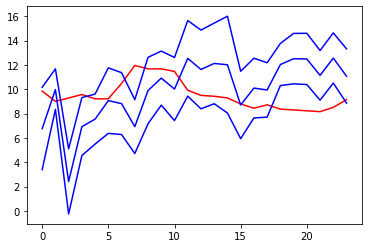

In [32]:
index = 1
plt.plot(true[index, :], color='red')
plt.plot(pred[index, :], color='blue')
plt.plot(pred_lower[index, :], color='blue')
plt.plot(pred_upper[index, :], color='blue')

(array([1., 0., 0., 0., 2., 1., 0., 0., 0., 1.]),
 array([ 2.02520407,  3.70538536,  5.38556665,  7.06574795,  8.74592924,
        10.42611053, 12.10629182, 13.78647312, 15.46665441, 17.1468357 ,
        18.82701699]),
 <BarContainer object of 10 artists>)

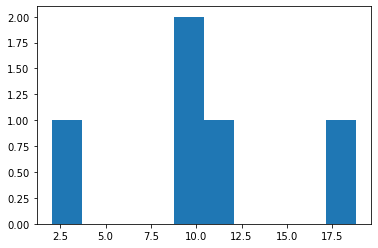

In [34]:
plt.hist(np.mean((true-pred)**2, axis = 1))